In [1]:
from datetime import datetime
import math
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
from torch.func import jacrev
import torch.nn as nn

np.set_printoptions(threshold=sys.maxsize)

In [2]:
class PolynomialRegression:
    
    def __init__(self, coef_lb, coef_ub, degree):
        self.coef_arr = np.random.uniform(coef_lb, coef_ub, degree + 1)

    def __call__(self, x):
        return np.sum([coef * x ** i for i, coef in enumerate(self.coef_arr)], axis=0)
    
def get_gaussian_data(d0, data_size, target_fn):
    x = np.random.normal(size=(data_size, d0))
    y = target_fn(x)
    return x, y

In [3]:
class TwoLayerNet(nn.Module):
    
    def __init__(self, d0, d1, d2):
        super(TwoLayerNet, self).__init__()
        
        layers = []
        
        lin_layer1 = nn.Linear(d0, d1)        
#         torch.nn.init.zeros_(lin_layer1.bias)
        torch.nn.init.normal_(lin_layer1.bias, mean=0., std=np.sqrt(2. / d0))        
        torch.nn.init.kaiming_normal_(lin_layer1.weight, nonlinearity='relu')
        layers.append(lin_layer1)
        layers.append(nn.ReLU())
        
        lin_layer2 = nn.Linear(d1, d2, bias=False)
        torch.nn.init.normal_(lin_layer2.weight, mean=0., std=np.sqrt(1. / d1))
        # Freeze the weights in the last layer
        lin_layer2.weight.requires_grad = False
        layers.append(lin_layer2)
        
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    
def get_A_and_rank(model, x):
    out1 = model.layers[0](x).detach().numpy()
    pattern = out1 > 0
    rank = np.linalg.matrix_rank(pattern.astype(np.float64))    
    return pattern, rank

def get_distance_to_boundary(model, x):
    np_weight = model.layers[0].weight.detach().numpy()
    np_bias = model.layers[0].bias.detach().numpy()
    np_x = x.detach().numpy()
    distance_arr = [np.min([np.abs((b + one_x[0] * w[0])) / np.linalg.norm([1, one_x[0]])
                            for w, b in zip(np_weight, np_bias)]) for one_x in np_x]    
    return distance_arr
                
# Relatively slow but certain
# Rewrite later if needed 
def get_jacobian_rank_spectrum(model, x):
    jacobian = []
    for one_x in x:
        model(one_x).backward()        
        grads = [param.grad.view(-1) for param in model.parameters() if param.grad is not None]
        jacobian.append(torch.cat(grads).numpy())
        
    jacobian = np.asarray(jacobian)
#     rank = np.linalg.matrix_rank(jacobian.astype(np.float64))
    
    spectrum = scipy.linalg.svdvals(jacobian)
    ratio = np.min(spectrum) / np.max(spectrum)
    
#     return rank, ratio
    return None, ratio

def train(model, optimizer, loss_fn, x, y, epochs_num, distance_epoch):
    start_time = datetime.now()
    
    loss_arr = []
    rank_arr = []
    ratio_arr = []
    a_rank_arr = []
    pattern_arr = []
    distance_arr = []
    
    pred_y = model(x)
    loss = loss_fn(pred_y, y)
    loss_arr.append(loss.detach().numpy())
    
    rank, ratio = get_jacobian_rank_spectrum(model, x)
    rank_arr.append(rank)
    ratio_arr.append(ratio)
    
    pattern, a_rank = get_A_and_rank(model, x)
    pattern_arr.append(pattern)
    a_rank_arr.append(a_rank)
    
    distance_arr.append(get_distance_to_boundary(model, x))

    for e_id in range(epochs_num):
        model.train(True)
        
        # We use full-batch gradient descent
        optimizer.zero_grad()

        pred_y = model(x)
        loss = loss_fn(pred_y, y)
        
        loss.backward()
        optimizer.step()     

        print(f'Epoch {e_id + 1}. Loss: {loss.item()}')
        
        loss_arr.append(loss.detach().numpy())
        
        rank, ratio = get_jacobian_rank_spectrum(model, x)
        rank_arr.append(rank)
        ratio_arr.append(ratio)
        
        pattern, a_rank = get_A_and_rank(model, x)
        pattern_arr.append(pattern)
        a_rank_arr.append(a_rank)
    
        if (e_id + 1) % distance_epoch == 0:
            distance_arr.append(get_distance_to_boundary(model, x))
            
    total_time = datetime.now() - start_time
    hours = int(total_time.seconds / 3600)
    minutes = int(total_time.seconds / 60 - hours * 60)
    seconds = int(total_time.seconds - hours * 3600 - minutes * 60)
    print(f'Elapsed time: {hours}h {minutes}min {int(seconds)}s')
        
    return loss_arr, rank_arr, ratio_arr, pattern_arr, distance_arr, a_rank_arr

# Step 1. Train the network

=== Run 1/4 ===
Epoch 1. Loss: 2.423470973968506
Epoch 2. Loss: 1.3157633543014526
Epoch 3. Loss: 1.0071325302124023
Epoch 4. Loss: 0.5052335858345032
Epoch 5. Loss: 0.24538716673851013
Epoch 6. Loss: 0.5445325970649719
Epoch 7. Loss: 0.7308553457260132
Epoch 8. Loss: 0.5462421774864197
Epoch 9. Loss: 0.35898396372795105
Epoch 10. Loss: 0.35803213715553284
Epoch 11. Loss: 0.37469181418418884
Epoch 12. Loss: 0.2616315186023712
Epoch 13. Loss: 0.10557419061660767
Epoch 14. Loss: 0.05721288546919823
Epoch 15. Loss: 0.12998436391353607
Epoch 16. Loss: 0.20235881209373474
Epoch 17. Loss: 0.19501881301403046
Epoch 18. Loss: 0.15030179917812347
Epoch 19. Loss: 0.13780882954597473
Epoch 20. Loss: 0.15858161449432373
Epoch 21. Loss: 0.15851245820522308
Epoch 22. Loss: 0.11202526092529297
Epoch 23. Loss: 0.05644230544567108
Epoch 24. Loss: 0.04039989411830902
Epoch 25. Loss: 0.062382861971855164
Epoch 26. Loss: 0.07993914932012558
Epoch 27. Loss: 0.07064052671194077
Epoch 28. Loss: 0.05637642368

Epoch 220. Loss: 0.001820222707465291
Epoch 221. Loss: 0.0018037442350760102
Epoch 222. Loss: 0.001787505461834371
Epoch 223. Loss: 0.0017720230389386415
Epoch 224. Loss: 0.0017573669319972396
Epoch 225. Loss: 0.0017432692693546414
Epoch 226. Loss: 0.001729388372041285
Epoch 227. Loss: 0.0017157170223072171
Epoch 228. Loss: 0.0017022371757775545
Epoch 229. Loss: 0.0016893822466954589
Epoch 230. Loss: 0.0016767713241279125
Epoch 231. Loss: 0.0016644018469378352
Epoch 232. Loss: 0.0016524404054507613
Epoch 233. Loss: 0.0016406155191361904
Epoch 234. Loss: 0.0016289561754092574
Epoch 235. Loss: 0.0016174358315765858
Epoch 236. Loss: 0.0016060267807915807
Epoch 237. Loss: 0.0015947282081469893
Epoch 238. Loss: 0.0015835532685741782
Epoch 239. Loss: 0.0015724829863756895
Epoch 240. Loss: 0.0015615198062732816
Epoch 241. Loss: 0.00155069085303694
Epoch 242. Loss: 0.0015399523545056581
Epoch 243. Loss: 0.0015292890602722764
Epoch 244. Loss: 0.0015187120297923684
Epoch 245. Loss: 0.00150822091

Epoch 433. Loss: 0.0005476117366924882
Epoch 434. Loss: 0.0005453492631204426
Epoch 435. Loss: 0.0005431064055301249
Epoch 436. Loss: 0.0005408797296695411
Epoch 437. Loss: 0.0005386607954278588
Epoch 438. Loss: 0.0005364582757465541
Epoch 439. Loss: 0.0005342699005268514
Epoch 440. Loss: 0.000532100151758641
Epoch 441. Loss: 0.0005299392505548894
Epoch 442. Loss: 0.0005277937743812799
Epoch 443. Loss: 0.0005256631411612034
Epoch 444. Loss: 0.0005235479911789298
Epoch 445. Loss: 0.0005214488483034074
Epoch 446. Loss: 0.0005193610559217632
Epoch 447. Loss: 0.0005172883393242955
Epoch 448. Loss: 0.0005152339581400156
Epoch 449. Loss: 0.0005131873767822981
Epoch 450. Loss: 0.0005111583159305155
Epoch 451. Loss: 0.0005091405473649502
Epoch 452. Loss: 0.0005071383202448487
Epoch 453. Loss: 0.0005051498301327229
Epoch 454. Loss: 0.0005031770560890436
Epoch 455. Loss: 0.0005012142355553806
Epoch 456. Loss: 0.0004992664325982332
Epoch 457. Loss: 0.0004973321338184178
Epoch 458. Loss: 0.0004954

Epoch 642. Loss: 0.0002918877871707082
Epoch 643. Loss: 0.0002911411866080016
Epoch 644. Loss: 0.00029039778746664524
Epoch 645. Loss: 0.00028965360252186656
Epoch 646. Loss: 0.000288911338429898
Epoch 647. Loss: 0.0002881709369830787
Epoch 648. Loss: 0.00028743367874994874
Epoch 649. Loss: 0.0002866951108444482
Epoch 650. Loss: 0.0002859606174752116
Epoch 651. Loss: 0.00028522434877231717
Epoch 652. Loss: 0.00028449404635466635
Epoch 653. Loss: 0.0002837632200680673
Epoch 654. Loss: 0.0002830319863278419
Epoch 655. Loss: 0.00028230302268639207
Epoch 656. Loss: 0.0002815758343786001
Epoch 657. Loss: 0.00028085167286917567
Epoch 658. Loss: 0.0002801278023980558
Epoch 659. Loss: 0.0002794054162222892
Epoch 660. Loss: 0.00027868361212313175
Epoch 661. Loss: 0.0002779605274554342
Epoch 662. Loss: 0.0002772426523733884
Epoch 663. Loss: 0.0002765262615866959
Epoch 664. Loss: 0.0002758098125923425
Epoch 665. Loss: 0.00027509426581673324
Epoch 666. Loss: 0.0002743820077739656
Epoch 667. Loss: 

Epoch 850. Loss: 0.000164866098202765
Epoch 851. Loss: 0.0001643780415179208
Epoch 852. Loss: 0.00016389194934163243
Epoch 853. Loss: 0.00016340604634024203
Epoch 854. Loss: 0.00016292117652483284
Epoch 855. Loss: 0.00016243748541455716
Epoch 856. Loss: 0.00016195492935366929
Epoch 857. Loss: 0.0001614743669051677
Epoch 858. Loss: 0.00016099557979032397
Epoch 859. Loss: 0.00016051638522185385
Epoch 860. Loss: 0.00016003873315639794
Epoch 861. Loss: 0.0001595643552718684
Epoch 862. Loss: 0.0001590892643434927
Epoch 863. Loss: 0.00015861682186368853
Epoch 864. Loss: 0.0001581442338647321
Epoch 865. Loss: 0.0001576742361066863
Epoch 866. Loss: 0.00015720506780780852
Epoch 867. Loss: 0.00015673571033403277
Epoch 868. Loss: 0.00015626911772415042
Epoch 869. Loss: 0.00015580235049128532
Epoch 870. Loss: 0.00015533884288743138
Epoch 871. Loss: 0.0001548735162941739
Epoch 872. Loss: 0.00015440840797964483
Epoch 873. Loss: 0.0001539468066766858
Epoch 874. Loss: 0.00015348383749369532
Epoch 875.

Epoch 1059. Loss: 8.736907329875976e-05
Epoch 1060. Loss: 8.701853221282363e-05
Epoch 1061. Loss: 8.608098869444802e-05
Epoch 1062. Loss: 8.518341928720474e-05
Epoch 1063. Loss: 8.480375981889665e-05
Epoch 1064. Loss: 8.488297316944227e-05
Epoch 1065. Loss: 8.499935211148113e-05
Epoch 1066. Loss: 8.478595555061474e-05
Epoch 1067. Loss: 8.422618702752516e-05
Epoch 1068. Loss: 8.359072671737522e-05
Epoch 1069. Loss: 8.316567254951224e-05
Epoch 1070. Loss: 8.300905756186694e-05
Epoch 1071. Loss: 8.296217856695876e-05
Epoch 1072. Loss: 8.281620830530301e-05
Epoch 1073. Loss: 8.247913501691073e-05
Epoch 1074. Loss: 8.203097968362272e-05
Epoch 1075. Loss: 8.161468576872721e-05
Epoch 1076. Loss: 8.132727816700935e-05
Epoch 1077. Loss: 8.115022501442581e-05
Epoch 1078. Loss: 8.09932971606031e-05
Epoch 1079. Loss: 8.076992526184767e-05
Epoch 1080. Loss: 8.045965660130605e-05
Epoch 1081. Loss: 8.010878809727728e-05
Epoch 1082. Loss: 7.978254870977253e-05
Epoch 1083. Loss: 7.951817678986117e-05
E

Epoch 1265. Loss: 4.741298471344635e-05
Epoch 1266. Loss: 5.915521614952013e-05
Epoch 1267. Loss: 6.322094122879207e-05
Epoch 1268. Loss: 5.483224958879873e-05
Epoch 1269. Loss: 4.499500209931284e-05
Epoch 1270. Loss: 4.437130701262504e-05
Epoch 1271. Loss: 5.088324542157352e-05
Epoch 1272. Loss: 5.467670416692272e-05
Epoch 1273. Loss: 5.101168426335789e-05
Epoch 1274. Loss: 4.470760904951021e-05
Epoch 1275. Loss: 4.268983320798725e-05
Epoch 1276. Loss: 4.575038474285975e-05
Epoch 1277. Loss: 4.88753903482575e-05
Epoch 1278. Loss: 4.800688839168288e-05
Epoch 1279. Loss: 4.434365837369114e-05
Epoch 1280. Loss: 4.196096779196523e-05
Epoch 1281. Loss: 4.276636536815204e-05
Epoch 1282. Loss: 4.4868058466818184e-05
Epoch 1283. Loss: 4.53751054010354e-05
Epoch 1284. Loss: 4.369366797618568e-05
Epoch 1285. Loss: 4.168795931036584e-05
Epoch 1286. Loss: 4.121813617530279e-05
Epoch 1287. Loss: 4.219070615363307e-05
Epoch 1288. Loss: 4.304744288674556e-05
Epoch 1289. Loss: 4.267154145054519e-05
E

Epoch 1470. Loss: 0.04739106819033623
Epoch 1471. Loss: 0.04958011955022812
Epoch 1472. Loss: 0.031531140208244324
Epoch 1473. Loss: 0.007370492909103632
Epoch 1474. Loss: 0.0011527512688189745
Epoch 1475. Loss: 0.01427895575761795
Epoch 1476. Loss: 0.02450719103217125
Epoch 1477. Loss: 0.016230178996920586
Epoch 1478. Loss: 0.0024989149533212185
Epoch 1479. Loss: 0.0030290517024695873
Epoch 1480. Loss: 0.012647632509469986
Epoch 1481. Loss: 0.013008956797420979
Epoch 1482. Loss: 0.003732702462002635
Epoch 1483. Loss: 0.0006313269841484725
Epoch 1484. Loss: 0.00672961724922061
Epoch 1485. Loss: 0.009143322706222534
Epoch 1486. Loss: 0.003491226816549897
Epoch 1487. Loss: 6.743839185219258e-05
Epoch 1488. Loss: 0.0036163954064249992
Epoch 1489. Loss: 0.006044646725058556
Epoch 1490. Loss: 0.0027828109450638294
Epoch 1491. Loss: 0.00012876479013357311
Epoch 1492. Loss: 0.002142371842637658
Epoch 1493. Loss: 0.003888582345098257
Epoch 1494. Loss: 0.0019065015949308872
Epoch 1495. Loss: 0.

Epoch 1676. Loss: 0.005027267150580883
Epoch 1677. Loss: 0.002611191011965275
Epoch 1678. Loss: 0.00023018773936200887
Epoch 1679. Loss: 0.0005907664308324456
Epoch 1680. Loss: 0.002461774740368128
Epoch 1681. Loss: 0.0029643538873642683
Epoch 1682. Loss: 0.0015067714266479015
Epoch 1683. Loss: 0.00012610372505150735
Epoch 1684. Loss: 0.00039743856177665293
Epoch 1685. Loss: 0.001509792055003345
Epoch 1686. Loss: 0.0017550456104800105
Epoch 1687. Loss: 0.0008623971953056753
Epoch 1688. Loss: 7.226764864753932e-05
Epoch 1689. Loss: 0.0002672020345926285
Epoch 1690. Loss: 0.0009233003947883844
Epoch 1691. Loss: 0.0010458937613293529
Epoch 1692. Loss: 0.0005090140621177852
Epoch 1693. Loss: 4.9472459068056196e-05
Epoch 1694. Loss: 0.00016961641085799783
Epoch 1695. Loss: 0.0005558973643928766
Epoch 1696. Loss: 0.0006297513609752059
Epoch 1697. Loss: 0.0003165505186188966
Epoch 1698. Loss: 4.00953613279853e-05
Epoch 1699. Loss: 0.00010014458530349657
Epoch 1700. Loss: 0.0003280817472841590

Epoch 1879. Loss: 1.2105942914786283e-05
Epoch 1880. Loss: 1.2159193829575088e-05
Epoch 1881. Loss: 1.2261702977411915e-05
Epoch 1882. Loss: 1.2450972462829668e-05
Epoch 1883. Loss: 1.2796167538908776e-05
Epoch 1884. Loss: 1.3421951734926552e-05
Epoch 1885. Loss: 1.455391975468956e-05
Epoch 1886. Loss: 1.661192436586134e-05
Epoch 1887. Loss: 2.0362822397146374e-05
Epoch 1888. Loss: 2.7243446311331354e-05
Epoch 1889. Loss: 3.9933202060637996e-05
Epoch 1890. Loss: 6.34890457149595e-05
Epoch 1891. Loss: 0.00010746293992269784
Epoch 1892. Loss: 0.00019003552733920515
Epoch 1893. Loss: 0.0003458393330220133
Epoch 1894. Loss: 0.0006408237386494875
Epoch 1895. Loss: 0.0012010239297524095
Epoch 1896. Loss: 0.002261163666844368
Epoch 1897. Loss: 0.004253720864653587
Epoch 1898. Loss: 0.007915401831269264
Epoch 1899. Loss: 0.014368078671395779
Epoch 1900. Loss: 0.02467932738363743
Epoch 1901. Loss: 0.038066111505031586
Epoch 1902. Loss: 0.04918818175792694
Epoch 1903. Loss: 0.0466865636408329
Ep

Epoch 2085. Loss: 1.5914232790237293e-05
Epoch 2086. Loss: 1.805806823540479e-05
Epoch 2087. Loss: 1.8546141291153617e-05
Epoch 2088. Loss: 1.7375738025293685e-05
Epoch 2089. Loss: 1.5150258150242735e-05
Epoch 2090. Loss: 1.2726030945486855e-05
Epoch 2091. Loss: 1.0854744687094353e-05
Epoch 2092. Loss: 9.94962829281576e-06
Epoch 2093. Loss: 1.0025300070992671e-05
Epoch 2094. Loss: 1.0788639883685391e-05
Epoch 2095. Loss: 1.180233357445104e-05
Epoch 2096. Loss: 1.2652417353820056e-05
Epoch 2097. Loss: 1.3070309250906575e-05
Epoch 2098. Loss: 1.2975789104530122e-05
Epoch 2099. Loss: 1.2454605894163251e-05
Epoch 2100. Loss: 1.1696343790390529e-05
Epoch 2101. Loss: 1.0913600817730185e-05
Epoch 2102. Loss: 1.0280083188263234e-05
Epoch 2103. Loss: 9.896712072077207e-06
Epoch 2104. Loss: 9.78132629825268e-06
Epoch 2105. Loss: 9.885666258924175e-06
Epoch 2106. Loss: 1.0124906111741439e-05
Epoch 2107. Loss: 1.040488132275641e-05
Epoch 2108. Loss: 1.0644359463185538e-05
Epoch 2109. Loss: 1.07923

Epoch 2290. Loss: 9.227961527358275e-06
Epoch 2291. Loss: 9.215803402184974e-06
Epoch 2292. Loss: 9.195341590384487e-06
Epoch 2293. Loss: 9.170002158498392e-06
Epoch 2294. Loss: 9.144293471763376e-06
Epoch 2295. Loss: 9.122143637796398e-06
Epoch 2296. Loss: 9.104714081331622e-06
Epoch 2297. Loss: 9.093881089938805e-06
Epoch 2298. Loss: 9.086652426049113e-06
Epoch 2299. Loss: 9.084158591576852e-06
Epoch 2300. Loss: 9.08190031623235e-06
Epoch 2301. Loss: 9.079220944840927e-06
Epoch 2302. Loss: 9.075807611225173e-06
Epoch 2303. Loss: 9.068860890693031e-06
Epoch 2304. Loss: 9.059465810423717e-06
Epoch 2305. Loss: 9.047751518664882e-06
Epoch 2306. Loss: 9.033854439621791e-06
Epoch 2307. Loss: 9.019022400025278e-06
Epoch 2308. Loss: 9.00348459254019e-06
Epoch 2309. Loss: 8.98884445632575e-06
Epoch 2310. Loss: 8.974596312327776e-06
Epoch 2311. Loss: 8.961195817391854e-06
Epoch 2312. Loss: 8.948900358518586e-06
Epoch 2313. Loss: 8.93821197678335e-06
Epoch 2314. Loss: 8.928770512284245e-06
Epoc

Epoch 2496. Loss: 0.00030968833016231656
Epoch 2497. Loss: 0.00025580974761396646
Epoch 2498. Loss: 0.0001486954279243946
Epoch 2499. Loss: 5.1573497330537066e-05
Epoch 2500. Loss: 9.963451702788007e-06
Epoch 2501. Loss: 3.0139466616674326e-05
Epoch 2502. Loss: 8.406737470068038e-05
Epoch 2503. Loss: 0.0001318523718509823
Epoch 2504. Loss: 0.00014549515617545694
Epoch 2505. Loss: 0.00012088187213521451
Epoch 2506. Loss: 7.4852752732113e-05
Epoch 2507. Loss: 3.201993240509182e-05
Epoch 2508. Loss: 1.0601122994557954e-05
Epoch 2509. Loss: 1.468417849537218e-05
Epoch 2510. Loss: 3.526050932123326e-05
Epoch 2511. Loss: 5.741952554672025e-05
Epoch 2512. Loss: 6.873091479064897e-05
Epoch 2513. Loss: 6.454405229305848e-05
Epoch 2514. Loss: 4.845472358283587e-05
Epoch 2515. Loss: 2.887503069359809e-05
Epoch 2516. Loss: 1.4164299500407651e-05
Epoch 2517. Loss: 8.917433660826646e-06
Epoch 2518. Loss: 1.2746549145958852e-05
Epoch 2519. Loss: 2.152411798306275e-05
Epoch 2520. Loss: 2.9950879252282

Epoch 2701. Loss: 9.952443360816687e-05
Epoch 2702. Loss: 0.00013529531133826822
Epoch 2703. Loss: 0.00018549058586359024
Epoch 2704. Loss: 0.0002579259453341365
Epoch 2705. Loss: 0.00036418589297682047
Epoch 2706. Loss: 0.0005217917496338487
Epoch 2707. Loss: 0.0007556668133474886
Epoch 2708. Loss: 0.0011031918693333864
Epoch 2709. Loss: 0.0016171756433323026
Epoch 2710. Loss: 0.002373691415414214
Epoch 2711. Loss: 0.003473791992291808
Epoch 2712. Loss: 0.005043708253651857
Epoch 2713. Loss: 0.0072004469111561775
Epoch 2714. Loss: 0.009973118081688881
Epoch 2715. Loss: 0.013210304081439972
Epoch 2716. Loss: 0.016170455142855644
Epoch 2717. Loss: 0.017986418679356575
Epoch 2718. Loss: 0.01724964752793312
Epoch 2719. Loss: 0.013698938302695751
Epoch 2720. Loss: 0.008138188160955906
Epoch 2721. Loss: 0.0029550595209002495
Epoch 2722. Loss: 0.0003517626319080591
Epoch 2723. Loss: 0.0008768992847763002
Epoch 2724. Loss: 0.0033284896053373814
Epoch 2725. Loss: 0.005727340001612902
Epoch 272

Epoch 2906. Loss: 0.0003983498318120837
Epoch 2907. Loss: 6.0655762354144827e-05
Epoch 2908. Loss: 4.5949011109769344e-05
Epoch 2909. Loss: 0.00027736424817703664
Epoch 2910. Loss: 0.00044993896153755486
Epoch 2911. Loss: 0.00037901700125075877
Epoch 2912. Loss: 0.00015918466669972986
Epoch 2913. Loss: 1.571226675878279e-05
Epoch 2914. Loss: 5.689396493835375e-05
Epoch 2915. Loss: 0.00019144672842230648
Epoch 2916. Loss: 0.00025681228726170957
Epoch 2917. Loss: 0.0001901401556096971
Epoch 2918. Loss: 6.890844815643504e-05
Epoch 2919. Loss: 8.55331563798245e-06
Epoch 2920. Loss: 4.5319367927731946e-05
Epoch 2921. Loss: 0.00011765944509534165
Epoch 2922. Loss: 0.0001435443409718573
Epoch 2923. Loss: 0.00010103434033226222
Epoch 2924. Loss: 3.646753611974418e-05
Epoch 2925. Loss: 8.03935563453706e-06
Epoch 2926. Loss: 3.0004666768945754e-05
Epoch 2927. Loss: 6.850497447885573e-05
Epoch 2928. Loss: 8.1825208326336e-05
Epoch 2929. Loss: 5.936325032962486e-05
Epoch 2930. Loss: 2.483146818121

Epoch 3111. Loss: 6.497058620880125e-06
Epoch 3112. Loss: 6.486732672783546e-06
Epoch 3113. Loss: 6.477170245489106e-06
Epoch 3114. Loss: 6.4693922467995435e-06
Epoch 3115. Loss: 6.463655608968111e-06
Epoch 3116. Loss: 6.459848464146489e-06
Epoch 3117. Loss: 6.458667485276237e-06
Epoch 3118. Loss: 6.45954605715815e-06
Epoch 3119. Loss: 6.462503733928315e-06
Epoch 3120. Loss: 6.4683385971875396e-06
Epoch 3121. Loss: 6.476753696915694e-06
Epoch 3122. Loss: 6.489143743237946e-06
Epoch 3123. Loss: 6.506421868834877e-06
Epoch 3124. Loss: 6.5308577177347615e-06
Epoch 3125. Loss: 6.563909209944541e-06
Epoch 3126. Loss: 6.609771389776142e-06
Epoch 3127. Loss: 6.674454198218882e-06
Epoch 3128. Loss: 6.764377303625224e-06
Epoch 3129. Loss: 6.890364602440968e-06
Epoch 3130. Loss: 7.069143066473771e-06
Epoch 3131. Loss: 7.323851605178788e-06
Epoch 3132. Loss: 7.688278856221586e-06
Epoch 3133. Loss: 8.21340836409945e-06
Epoch 3134. Loss: 8.976991011877544e-06
Epoch 3135. Loss: 1.009439438348636e-05

Epoch 3316. Loss: 8.437094038526993e-06
Epoch 3317. Loss: 2.8853257390437648e-05
Epoch 3318. Loss: 5.192251774133183e-05
Epoch 3319. Loss: 5.774992678198032e-05
Epoch 3320. Loss: 4.343616819824092e-05
Epoch 3321. Loss: 2.1671003196388483e-05
Epoch 3322. Loss: 8.142334081640001e-06
Epoch 3323. Loss: 9.509840310784057e-06
Epoch 3324. Loss: 2.049597242148593e-05
Epoch 3325. Loss: 3.0175668143783696e-05
Epoch 3326. Loss: 3.091486723860726e-05
Epoch 3327. Loss: 2.3038390281726606e-05
Epoch 3328. Loss: 1.2913104001199827e-05
Epoch 3329. Loss: 7.242324045364512e-06
Epoch 3330. Loss: 8.353668818017468e-06
Epoch 3331. Loss: 1.3540952750190627e-05
Epoch 3332. Loss: 1.7948363165487535e-05
Epoch 3333. Loss: 1.8274859030498192e-05
Epoch 3334. Loss: 1.4639867004007101e-05
Epoch 3335. Loss: 9.78907246462768e-06
Epoch 3336. Loss: 6.755513823009096e-06
Epoch 3337. Loss: 6.836128704890143e-06
Epoch 3338. Loss: 9.114422027778346e-06
Epoch 3339. Loss: 1.1491488294268493e-05
Epoch 3340. Loss: 1.22400015243

Epoch 3522. Loss: 1.9294373487355188e-05
Epoch 3523. Loss: 1.9473298380034976e-05
Epoch 3524. Loss: 1.3831038813805208e-05
Epoch 3525. Loss: 7.621639724675333e-06
Epoch 3526. Loss: 5.588050498772645e-06
Epoch 3527. Loss: 8.144971616275143e-06
Epoch 3528. Loss: 1.1911726687685587e-05
Epoch 3529. Loss: 1.3232623132353183e-05
Epoch 3530. Loss: 1.1178530257893726e-05
Epoch 3531. Loss: 7.735272447462194e-06
Epoch 3532. Loss: 5.626576694339747e-06
Epoch 3533. Loss: 6.011927780491533e-06
Epoch 3534. Loss: 7.896717761468608e-06
Epoch 3535. Loss: 9.340428732684813e-06
Epoch 3536. Loss: 9.144931027549319e-06
Epoch 3537. Loss: 7.615423328388715e-06
Epoch 3538. Loss: 6.019901320541976e-06
Epoch 3539. Loss: 5.4380034271162e-06
Epoch 3540. Loss: 5.992986189085059e-06
Epoch 3541. Loss: 6.958170615689596e-06
Epoch 3542. Loss: 7.460853794327704e-06
Epoch 3543. Loss: 7.145823474274948e-06
Epoch 3544. Loss: 6.326249604171608e-06
Epoch 3545. Loss: 5.619184776151087e-06
Epoch 3546. Loss: 5.450035132525954e

Epoch 3727. Loss: 4.849283868679777e-06
Epoch 3728. Loss: 4.845978764933534e-06
Epoch 3729. Loss: 4.841800091526238e-06
Epoch 3730. Loss: 4.836594598600641e-06
Epoch 3731. Loss: 4.830903435504297e-06
Epoch 3732. Loss: 4.825536507269135e-06
Epoch 3733. Loss: 4.820610229216982e-06
Epoch 3734. Loss: 4.817793524125591e-06
Epoch 3735. Loss: 4.815921329281991e-06
Epoch 3736. Loss: 4.8158603931369726e-06
Epoch 3737. Loss: 4.817328772332985e-06
Epoch 3738. Loss: 4.821339189220453e-06
Epoch 3739. Loss: 4.828298642678419e-06
Epoch 3740. Loss: 4.84003612655215e-06
Epoch 3741. Loss: 4.858836746279849e-06
Epoch 3742. Loss: 4.8889419304032344e-06
Epoch 3743. Loss: 4.9361842684447765e-06
Epoch 3744. Loss: 5.009151209378615e-06
Epoch 3745. Loss: 5.121225058246637e-06
Epoch 3746. Loss: 5.293067260936368e-06
Epoch 3747. Loss: 5.558092198043596e-06
Epoch 3748. Loss: 5.967314791632816e-06
Epoch 3749. Loss: 6.602453595405677e-06
Epoch 3750. Loss: 7.593859209009679e-06
Epoch 3751. Loss: 9.152860002359375e-0

Epoch 3933. Loss: 0.000896613288205117
Epoch 3934. Loss: 0.0014912476763129234
Epoch 3935. Loss: 0.0024794521741569042
Epoch 3936. Loss: 0.0041079334914684296
Epoch 3937. Loss: 0.0067472904920578
Epoch 3938. Loss: 0.010796465910971165
Epoch 3939. Loss: 0.016610434278845787
Epoch 3940. Loss: 0.023585129529237747
Epoch 3941. Loss: 0.029756877571344376
Epoch 3942. Loss: 0.030818061903119087
Epoch 3943. Loss: 0.023678617551922798
Epoch 3944. Loss: 0.011075464077293873
Epoch 3945. Loss: 0.0014810094144195318
Epoch 3946. Loss: 0.0009592482238076627
Epoch 3947. Loss: 0.007352776359766722
Epoch 3948. Loss: 0.013052867725491524
Epoch 3949. Loss: 0.012136545963585377
Epoch 3950. Loss: 0.005706461612135172
Epoch 3951. Loss: 0.0004929094575345516
Epoch 3952. Loss: 0.0010846335208043456
Epoch 3953. Loss: 0.005216346587985754
Epoch 3954. Loss: 0.007297830656170845
Epoch 3955. Loss: 0.004948549438267946
Epoch 3956. Loss: 0.0011564892483875155
Epoch 3957. Loss: 0.00010892134014284238
Epoch 3958. Loss:

Epoch 4139. Loss: 0.0031849027145653963
Epoch 4140. Loss: 0.00016099406639114022
Epoch 4141. Loss: 0.0011128789046779275
Epoch 4142. Loss: 0.003720690496265888
Epoch 4143. Loss: 0.004014682024717331
Epoch 4144. Loss: 0.0017508850432932377
Epoch 4145. Loss: 5.284456710796803e-05
Epoch 4146. Loss: 0.0007665723678655922
Epoch 4147. Loss: 0.0023059111554175615
Epoch 4148. Loss: 0.0023397174663841724
Epoch 4149. Loss: 0.0009338082163594663
Epoch 4150. Loss: 1.3706914614886045e-05
Epoch 4151. Loss: 0.0005320446798577905
Epoch 4152. Loss: 0.0014250900130718946
Epoch 4153. Loss: 0.001364035182632506
Epoch 4154. Loss: 0.0005062689888291061
Epoch 4155. Loss: 7.963933967403136e-06
Epoch 4156. Loss: 0.00035440557985566556
Epoch 4157. Loss: 0.0008694541174918413
Epoch 4158. Loss: 0.0007998482906259596
Epoch 4159. Loss: 0.00028527816175483167
Epoch 4160. Loss: 7.334464498853777e-06
Epoch 4161. Loss: 0.00022333003289531916
Epoch 4162. Loss: 0.000524386006873101
Epoch 4163. Loss: 0.0004776770656462759

Epoch 4343. Loss: 0.03762630373239517
Epoch 4344. Loss: 0.03447074070572853
Epoch 4345. Loss: 0.02059044875204563
Epoch 4346. Loss: 0.005150964949280024
Epoch 4347. Loss: 0.00013570362352766097
Epoch 4348. Loss: 0.006914638914167881
Epoch 4349. Loss: 0.0156392902135849
Epoch 4350. Loss: 0.01599675789475441
Epoch 4351. Loss: 0.007731200661510229
Epoch 4352. Loss: 0.0005879527889192104
Epoch 4353. Loss: 0.001731493161059916
Epoch 4354. Loss: 0.0074707274325191975
Epoch 4355. Loss: 0.009363021701574326
Epoch 4356. Loss: 0.005083950702100992
Epoch 4357. Loss: 0.0004964123945683241
Epoch 4358. Loss: 0.0009283694671466947
Epoch 4359. Loss: 0.004399341065436602
Epoch 4360. Loss: 0.0054443287663161755
Epoch 4361. Loss: 0.0027455620002001524
Epoch 4362. Loss: 0.00017348396067973226
Epoch 4363. Loss: 0.0007673122454434633
Epoch 4364. Loss: 0.0028548813425004482
Epoch 4365. Loss: 0.003133288351818919
Epoch 4366. Loss: 0.0013299882411956787
Epoch 4367. Loss: 2.6623751182341948e-05
Epoch 4368. Loss

Epoch 4550. Loss: 0.00012978175072930753
Epoch 4551. Loss: 0.00039487757021561265
Epoch 4552. Loss: 0.00043527811067178845
Epoch 4553. Loss: 0.00021733541507273912
Epoch 4554. Loss: 2.1592528355540708e-05
Epoch 4555. Loss: 5.131664511281997e-05
Epoch 4556. Loss: 0.00020876932831015438
Epoch 4557. Loss: 0.00026805500965565443
Epoch 4558. Loss: 0.00016260225675068796
Epoch 4559. Loss: 3.058213769691065e-05
Epoch 4560. Loss: 1.562749093864113e-05
Epoch 4561. Loss: 0.00010070038115372881
Epoch 4562. Loss: 0.0001591304171597585
Epoch 4563. Loss: 0.00012018125562462956
Epoch 4564. Loss: 3.772218769881874e-05
Epoch 4565. Loss: 5.016941486246651e-06
Epoch 4566. Loss: 4.216287925373763e-05
Epoch 4567. Loss: 8.816015179036185e-05
Epoch 4568. Loss: 8.474159403704107e-05
Epoch 4569. Loss: 4.009707845398225e-05
Epoch 4570. Loss: 6.62450338495546e-06
Epoch 4571. Loss: 1.4659442967968062e-05
Epoch 4572. Loss: 4.383379200589843e-05
Epoch 4573. Loss: 5.5282271205214784e-05
Epoch 4574. Loss: 3.713603655

Epoch 4754. Loss: 0.0003630247665569186
Epoch 4755. Loss: 0.0006245822296477854
Epoch 4756. Loss: 0.0010801814496517181
Epoch 4757. Loss: 0.001872554887086153
Epoch 4758. Loss: 0.0032442433293908834
Epoch 4759. Loss: 0.005579033400863409
Epoch 4760. Loss: 0.009430599398911
Epoch 4761. Loss: 0.015393247827887535
Epoch 4762. Loss: 0.023583590984344482
Epoch 4763. Loss: 0.03237859904766083
Epoch 4764. Loss: 0.03725728020071983
Epoch 4765. Loss: 0.03268902003765106
Epoch 4766. Loss: 0.01834345981478691
Epoch 4767. Loss: 0.003965332638472319
Epoch 4768. Loss: 0.00033954967511817813
Epoch 4769. Loss: 0.007509542629122734
Epoch 4770. Loss: 0.01564118079841137
Epoch 4771. Loss: 0.015376575291156769
Epoch 4772. Loss: 0.007220389787107706
Epoch 4773. Loss: 0.0005039629759266973
Epoch 4774. Loss: 0.001728978124447167
Epoch 4775. Loss: 0.00725287152454257
Epoch 4776. Loss: 0.009146226570010185
Epoch 4777. Loss: 0.005147901829332113
Epoch 4778. Loss: 0.0006085109198465943
Epoch 4779. Loss: 0.000725

Epoch 4961. Loss: 5.0920916692120954e-06
Epoch 4962. Loss: 6.976656550250482e-06
Epoch 4963. Loss: 7.648198334209155e-06
Epoch 4964. Loss: 6.785783170926152e-06
Epoch 4965. Loss: 5.061168394604465e-06
Epoch 4966. Loss: 3.5322220810485305e-06
Epoch 4967. Loss: 2.9405034638330108e-06
Epoch 4968. Loss: 3.348139898662339e-06
Epoch 4969. Loss: 4.24362360718078e-06
Epoch 4970. Loss: 4.9530908654560335e-06
Epoch 4971. Loss: 5.0465910135244485e-06
Epoch 4972. Loss: 4.529782017925754e-06
Epoch 4973. Loss: 3.74167052541452e-06
Epoch 4974. Loss: 3.105153382421122e-06
Epoch 4975. Loss: 2.8817576094297692e-06
Epoch 4976. Loss: 3.066868430323666e-06
Epoch 4977. Loss: 3.4491013138904236e-06
Epoch 4978. Loss: 3.761318566830596e-06
Epoch 4979. Loss: 3.830961759376805e-06
Epoch 4980. Loss: 3.642529009084683e-06
Epoch 4981. Loss: 3.3136509500764078e-06
Epoch 4982. Loss: 3.007656459885766e-06
Epoch 4983. Loss: 2.8452832339098677e-06
Epoch 4984. Loss: 2.8565439151861938e-06
Epoch 4985. Loss: 2.985764695040

Epoch 5165. Loss: 3.993991413153708e-06
Epoch 5166. Loss: 2.4682460207259282e-05
Epoch 5167. Loss: 5.245915599516593e-05
Epoch 5168. Loss: 5.658698864863254e-05
Epoch 5169. Loss: 3.498245496302843e-05
Epoch 5170. Loss: 1.0413869858894031e-05
Epoch 5171. Loss: 4.192788310319884e-06
Epoch 5172. Loss: 1.6635276551824063e-05
Epoch 5173. Loss: 3.0960814910940826e-05
Epoch 5174. Loss: 3.211921648471616e-05
Epoch 5175. Loss: 2.015814243350178e-05
Epoch 5176. Loss: 7.109365014912328e-06
Epoch 5177. Loss: 3.74283763449057e-06
Epoch 5178. Loss: 1.0179945093113929e-05
Epoch 5179. Loss: 1.7922697225003503e-05
Epoch 5180. Loss: 1.9091274225502275e-05
Epoch 5181. Loss: 1.3177420441934373e-05
Epoch 5182. Loss: 5.991972102492582e-06
Epoch 5183. Loss: 3.3596400044189068e-06
Epoch 5184. Loss: 6.1193836700113025e-06
Epoch 5185. Loss: 1.0416456461825874e-05
Epoch 5186. Loss: 1.1904627172043547e-05
Epoch 5187. Loss: 9.486425369686913e-06
Epoch 5188. Loss: 5.564328603213653e-06
Epoch 5189. Loss: 3.342144736

Epoch 5369. Loss: 2.492726252967259e-06
Epoch 5370. Loss: 2.4920288979046745e-06
Epoch 5371. Loss: 2.497124569345033e-06
Epoch 5372. Loss: 2.5025974537129514e-06
Epoch 5373. Loss: 2.503369842088432e-06
Epoch 5374. Loss: 2.497821924407617e-06
Epoch 5375. Loss: 2.4861653855623445e-06
Epoch 5376. Loss: 2.4714117898838595e-06
Epoch 5377. Loss: 2.456454922139528e-06
Epoch 5378. Loss: 2.443743369440199e-06
Epoch 5379. Loss: 2.4350356397917494e-06
Epoch 5380. Loss: 2.430091171845561e-06
Epoch 5381. Loss: 2.4278374439745676e-06
Epoch 5382. Loss: 2.4265430056402693e-06
Epoch 5383. Loss: 2.4247906367236283e-06
Epoch 5384. Loss: 2.42146734308335e-06
Epoch 5385. Loss: 2.416367124169483e-06
Epoch 5386. Loss: 2.41006864598603e-06
Epoch 5387. Loss: 2.40256099459657e-06
Epoch 5388. Loss: 2.3947741283336654e-06
Epoch 5389. Loss: 2.387799895586795e-06
Epoch 5390. Loss: 2.3818058707547607e-06
Epoch 5391. Loss: 2.377161990807508e-06
Epoch 5392. Loss: 2.373531060584355e-06
Epoch 5393. Loss: 2.3710394998488

Epoch 5573. Loss: 0.0008351927972398698
Epoch 5574. Loss: 0.0013426430523395538
Epoch 5575. Loss: 0.0021589368116110563
Epoch 5576. Loss: 0.003460307139903307
Epoch 5577. Loss: 0.005487283691763878
Epoch 5578. Loss: 0.008528318256139755
Epoch 5579. Loss: 0.012758353725075722
Epoch 5580. Loss: 0.01796797104179859
Epoch 5581. Loss: 0.022897254675626755
Epoch 5582. Loss: 0.025145873427391052
Epoch 5583. Loss: 0.02208850346505642
Epoch 5584. Loss: 0.01383280660957098
Epoch 5585. Loss: 0.004664297681301832
Epoch 5586. Loss: 0.00011076296505052596
Epoch 5587. Loss: 0.0019358753925189376
Epoch 5588. Loss: 0.007025938015431166
Epoch 5589. Loss: 0.010392921045422554
Epoch 5590. Loss: 0.009059258736670017
Epoch 5591. Loss: 0.004378512501716614
Epoch 5592. Loss: 0.0005502221174538136
Epoch 5593. Loss: 0.00045142904855310917
Epoch 5594. Loss: 0.0031169906724244356
Epoch 5595. Loss: 0.005281419958919287
Epoch 5596. Loss: 0.0047334469854831696
Epoch 5597. Loss: 0.002191311214119196
Epoch 5598. Loss:

Epoch 5778. Loss: 0.005905820056796074
Epoch 5779. Loss: 0.010388287715613842
Epoch 5780. Loss: 0.01783413626253605
Epoch 5781. Loss: 0.029081858694553375
Epoch 5782. Loss: 0.043504249304533005
Epoch 5783. Loss: 0.05576852709054947
Epoch 5784. Loss: 0.05619717016816139
Epoch 5785. Loss: 0.03820467367768288
Epoch 5786. Loss: 0.012450679205358028
Epoch 5787. Loss: 6.752279296051711e-05
Epoch 5788. Loss: 0.00829243939369917
Epoch 5789. Loss: 0.023134110495448112
Epoch 5790. Loss: 0.025913653895258904
Epoch 5791. Loss: 0.013467365875840187
Epoch 5792. Loss: 0.0012395777739584446
Epoch 5793. Loss: 0.0025706805754452944
Epoch 5794. Loss: 0.01195430476218462
Epoch 5795. Loss: 0.014876509085297585
Epoch 5796. Loss: 0.007569851819425821
Epoch 5797. Loss: 0.00047382162301801145
Epoch 5798. Loss: 0.0021196722518652678
Epoch 5799. Loss: 0.007839346304535866
Epoch 5800. Loss: 0.008372563868761063
Epoch 5801. Loss: 0.003274694085121155
Epoch 5802. Loss: 2.0793702788068913e-05
Epoch 5803. Loss: 0.002

Epoch 5986. Loss: 0.0006949263624846935
Epoch 5987. Loss: 0.0005604222533293068
Epoch 5988. Loss: 0.00019624963169917464
Epoch 5989. Loss: 3.939939233532641e-06
Epoch 5990. Loss: 0.0001264630409423262
Epoch 5991. Loss: 0.00034608435817062855
Epoch 5992. Loss: 0.0003868041967507452
Epoch 5993. Loss: 0.00021743017714470625
Epoch 5994. Loss: 3.657506385934539e-05
Epoch 5995. Loss: 1.832525413192343e-05
Epoch 5996. Loss: 0.00013484765077009797
Epoch 5997. Loss: 0.00022523604275193065
Epoch 5998. Loss: 0.00018819011165760458
Epoch 5999. Loss: 7.456500316038728e-05
Epoch 6000. Loss: 4.820683898287825e-06
Epoch 6001. Loss: 3.232796734664589e-05
Epoch 6002. Loss: 0.0001023507138597779
Epoch 6003. Loss: 0.00012874777894467115
Epoch 6004. Loss: 8.67169801495038e-05
Epoch 6005. Loss: 2.508153374947142e-05
Epoch 6006. Loss: 3.2551909043831984e-06
Epoch 6007. Loss: 3.0271672585513443e-05
Epoch 6008. Loss: 6.597120955120772e-05
Epoch 6009. Loss: 7.00107921147719e-05
Epoch 6010. Loss: 4.0986258682096

Epoch 6192. Loss: 0.0034977449104189873
Epoch 6193. Loss: 0.00021932566596660763
Epoch 6194. Loss: 0.005746394395828247
Epoch 6195. Loss: 0.011372999288141727
Epoch 6196. Loss: 0.009820768609642982
Epoch 6197. Loss: 0.0034437295980751514
Epoch 6198. Loss: 2.060915358015336e-05
Epoch 6199. Loss: 0.0025122391525655985
Epoch 6200. Loss: 0.006269597914069891
Epoch 6201. Loss: 0.005997033324092627
Epoch 6202. Loss: 0.0023255248088389635
Epoch 6203. Loss: 2.9285656637512147e-05
Epoch 6204. Loss: 0.0013491596328094602
Epoch 6205. Loss: 0.0036481923889368773
Epoch 6206. Loss: 0.0035940047819167376
Epoch 6207. Loss: 0.0014300585025921464
Epoch 6208. Loss: 2.25270905502839e-05
Epoch 6209. Loss: 0.0007793770637363195
Epoch 6210. Loss: 0.00215271208435297
Epoch 6211. Loss: 0.002135989721864462
Epoch 6212. Loss: 0.0008573136292397976
Epoch 6213. Loss: 1.568766856507864e-05
Epoch 6214. Loss: 0.0004568610747810453
Epoch 6215. Loss: 0.0012766291620209813
Epoch 6216. Loss: 0.001282885787077248
Epoch 62

Epoch 6397. Loss: 1.1869270565512124e-05
Epoch 6398. Loss: 2.3260088710230775e-05
Epoch 6399. Loss: 2.434900488879066e-05
Epoch 6400. Loss: 1.494804018875584e-05
Epoch 6401. Loss: 4.797561359737301e-06
Epoch 6402. Loss: 2.5254162210330833e-06
Epoch 6403. Loss: 7.903357982286252e-06
Epoch 6404. Loss: 1.3824816960550379e-05
Epoch 6405. Loss: 1.4148332411423326e-05
Epoch 6406. Loss: 9.05559954844648e-06
Epoch 6407. Loss: 3.609377017710358e-06
Epoch 6408. Loss: 2.248133569082711e-06
Epoch 6409. Loss: 4.966612323187292e-06
Epoch 6410. Loss: 8.21220783109311e-06
Epoch 6411. Loss: 8.706536391400732e-06
Epoch 6412. Loss: 6.237788056751015e-06
Epoch 6413. Loss: 3.213511718058726e-06
Epoch 6414. Loss: 2.071916924251127e-06
Epoch 6415. Loss: 3.193872998963343e-06
Epoch 6416. Loss: 4.998188160243444e-06
Epoch 6417. Loss: 5.663175670633791e-06
Epoch 6418. Loss: 4.688582066592062e-06
Epoch 6419. Loss: 3.0450762551481603e-06
Epoch 6420. Loss: 2.0720844986499287e-06
Epoch 6421. Loss: 2.312405513293924

Epoch 6601. Loss: 0.0010784954065456986
Epoch 6602. Loss: 0.0006271058809943497
Epoch 6603. Loss: 4.5918499381514266e-05
Epoch 6604. Loss: 0.00017704209312796593
Epoch 6605. Loss: 0.0006194199086166918
Epoch 6606. Loss: 0.000580417166929692
Epoch 6607. Loss: 0.00015723227988928556
Epoch 6608. Loss: 1.716860970191192e-05
Epoch 6609. Loss: 0.0002756839385256171
Epoch 6610. Loss: 0.0004284862370695919
Epoch 6611. Loss: 0.00023081064864527434
Epoch 6612. Loss: 1.4647757780039683e-05
Epoch 6613. Loss: 7.861186168156564e-05
Epoch 6614. Loss: 0.0002489950566086918
Epoch 6615. Loss: 0.00022988933778833598
Epoch 6616. Loss: 6.495688285212964e-05
Epoch 6617. Loss: 7.365616056631552e-06
Epoch 6618. Loss: 0.00010513899178477004
Epoch 6619. Loss: 0.00017043144907802343
Epoch 6620. Loss: 0.00010057206236524507
Epoch 6621. Loss: 1.109072400140576e-05
Epoch 6622. Loss: 2.504734402464237e-05
Epoch 6623. Loss: 9.292704635299742e-05
Epoch 6624. Loss: 9.776137449080124e-05
Epoch 6625. Loss: 3.672346065286

Epoch 6807. Loss: 5.577355113928206e-05
Epoch 6808. Loss: 7.6087853813078254e-06
Epoch 6809. Loss: 1.4770132111152634e-05
Epoch 6810. Loss: 5.275455623632297e-05
Epoch 6811. Loss: 6.382726860465482e-05
Epoch 6812. Loss: 3.525396823533811e-05
Epoch 6813. Loss: 6.235352884687018e-06
Epoch 6814. Loss: 9.281165148422588e-06
Epoch 6815. Loss: 3.159661719109863e-05
Epoch 6816. Loss: 3.9632661355426535e-05
Epoch 6817. Loss: 2.3935466742841527e-05
Epoch 6818. Loss: 5.889018211746588e-06
Epoch 6819. Loss: 5.74483283344307e-06
Epoch 6820. Loss: 1.8525994164519943e-05
Epoch 6821. Loss: 2.494748514436651e-05
Epoch 6822. Loss: 1.7168535123346373e-05
Epoch 6823. Loss: 5.856729785591597e-06
Epoch 6824. Loss: 3.8816083360870834e-06
Epoch 6825. Loss: 1.0761061275843531e-05
Epoch 6826. Loss: 1.5853131117182784e-05
Epoch 6827. Loss: 1.2743493243760895e-05
Epoch 6828. Loss: 5.851585228811018e-06
Epoch 6829. Loss: 3.169738420183421e-06
Epoch 6830. Loss: 6.372735242621275e-06
Epoch 6831. Loss: 1.01464347608

Epoch 7010. Loss: 0.002746538259088993
Epoch 7011. Loss: 0.0050203558057546616
Epoch 7012. Loss: 0.009103404358029366
Epoch 7013. Loss: 0.016097718849778175
Epoch 7014. Loss: 0.027286166325211525
Epoch 7015. Loss: 0.04248315840959549
Epoch 7016. Loss: 0.05768120661377907
Epoch 7017. Loss: 0.061702098697423935
Epoch 7018. Loss: 0.04535377398133278
Epoch 7019. Loss: 0.016648245975375175
Epoch 7020. Loss: 0.00030125502962619066
Epoch 7021. Loss: 0.007889359258115292
Epoch 7022. Loss: 0.024708779528737068
Epoch 7023. Loss: 0.028313694521784782
Epoch 7024. Loss: 0.014243073761463165
Epoch 7025. Loss: 0.000973164162132889
Epoch 7026. Loss: 0.0036723879165947437
Epoch 7027. Loss: 0.01427501905709505
Epoch 7028. Loss: 0.01575876772403717
Epoch 7029. Loss: 0.006366121582686901
Epoch 7030. Loss: 4.9013891839422286e-05
Epoch 7031. Loss: 0.004140414763242006
Epoch 7032. Loss: 0.009866506792604923
Epoch 7033. Loss: 0.0077670179307460785
Epoch 7034. Loss: 0.001567873521707952
Epoch 7035. Loss: 0.000

Epoch 7216. Loss: 0.01241292618215084
Epoch 7217. Loss: 0.005740666761994362
Epoch 7218. Loss: 0.0004429091641213745
Epoch 7219. Loss: 0.0012480407021939754
Epoch 7220. Loss: 0.005568733438849449
Epoch 7221. Loss: 0.007503002416342497
Epoch 7222. Loss: 0.004828196484595537
Epoch 7223. Loss: 0.0009655242902226746
Epoch 7224. Loss: 0.000214246436371468
Epoch 7225. Loss: 0.0025078952312469482
Epoch 7226. Loss: 0.0042675998993217945
Epoch 7227. Loss: 0.003232009708881378
Epoch 7228. Loss: 0.0008759910124354064
Epoch 7229. Loss: 4.020074993604794e-05
Epoch 7230. Loss: 0.0012318432563915849
Epoch 7231. Loss: 0.002438976662233472
Epoch 7232. Loss: 0.0020300159230828285
Epoch 7233. Loss: 0.0006399591802619398
Epoch 7234. Loss: 9.510157724434976e-06
Epoch 7235. Loss: 0.0006385634769685566
Epoch 7236. Loss: 0.0014080597320571542
Epoch 7237. Loss: 0.0012507023056969047
Epoch 7238. Loss: 0.0004400409525260329
Epoch 7239. Loss: 5.049437277193647e-06
Epoch 7240. Loss: 0.00033013473148457706
Epoch 72

Epoch 7421. Loss: 4.254234227119014e-06
Epoch 7422. Loss: 5.352350399334682e-06
Epoch 7423. Loss: 7.139115496102022e-06
Epoch 7424. Loss: 1.0061098691949155e-05
Epoch 7425. Loss: 1.4877030480420217e-05
Epoch 7426. Loss: 2.2854974304209463e-05
Epoch 7427. Loss: 3.6173045373288915e-05
Epoch 7428. Loss: 5.8514484408078715e-05
Epoch 7429. Loss: 9.626377141103148e-05
Epoch 7430. Loss: 0.00016034716099966317
Epoch 7431. Loss: 0.0002698066527955234
Epoch 7432. Loss: 0.00045747298281639814
Epoch 7433. Loss: 0.0007807721849530935
Epoch 7434. Loss: 0.0013384115882217884
Epoch 7435. Loss: 0.0023012461606413126
Epoch 7436. Loss: 0.003951048944145441
Epoch 7437. Loss: 0.006757458671927452
Epoch 7438. Loss: 0.011364465579390526
Epoch 7439. Loss: 0.018565811216831207
Epoch 7440. Loss: 0.028591787442564964
Epoch 7441. Loss: 0.04014883562922478
Epoch 7442. Loss: 0.048053912818431854
Epoch 7443. Loss: 0.045045558363199234
Epoch 7444. Loss: 0.028370875865221024
Epoch 7445. Loss: 0.008391017094254494
Epoc

Epoch 7627. Loss: 0.007557368371635675
Epoch 7628. Loss: 0.0065362476743757725
Epoch 7629. Loss: 0.0023249955847859383
Epoch 7630. Loss: 1.515091207693331e-05
Epoch 7631. Loss: 0.0016097777988761663
Epoch 7632. Loss: 0.004113277420401573
Epoch 7633. Loss: 0.004016577731817961
Epoch 7634. Loss: 0.0016242234269157052
Epoch 7635. Loss: 3.280288365203887e-05
Epoch 7636. Loss: 0.0008179355645552278
Epoch 7637. Loss: 0.002352928975597024
Epoch 7638. Loss: 0.002411361550912261
Epoch 7639. Loss: 0.0010246093152090907
Epoch 7640. Loss: 3.0435321605182253e-05
Epoch 7641. Loss: 0.00045287690591067076
Epoch 7642. Loss: 0.001373832579702139
Epoch 7643. Loss: 0.001443325774744153
Epoch 7644. Loss: 0.000634988013189286
Epoch 7645. Loss: 2.5802564778132364e-05
Epoch 7646. Loss: 0.00025198672665283084
Epoch 7647. Loss: 0.0008016685605980456
Epoch 7648. Loss: 0.0008684956119395792
Epoch 7649. Loss: 0.00040265460847876966
Epoch 7650. Loss: 2.3822058210498653e-05
Epoch 7651. Loss: 0.00013252737699076533
E

Epoch 7833. Loss: 0.013470875099301338
Epoch 7834. Loss: 0.0013519265921786427
Epoch 7835. Loss: 0.0023521198891103268
Epoch 7836. Loss: 0.011478564701974392
Epoch 7837. Loss: 0.014518063515424728
Epoch 7838. Loss: 0.0075192381627857685
Epoch 7839. Loss: 0.0005113843362778425
Epoch 7840. Loss: 0.0020042394753545523
Epoch 7841. Loss: 0.007587730884552002
Epoch 7842. Loss: 0.008169424720108509
Epoch 7843. Loss: 0.003205150132998824
Epoch 7844. Loss: 2.2575386537937447e-05
Epoch 7845. Loss: 0.0022022882476449013
Epoch 7846. Loss: 0.005197919439524412
Epoch 7847. Loss: 0.004206640645861626
Epoch 7848. Loss: 0.0009827661560848355
Epoch 7849. Loss: 0.00016402328037656844
Epoch 7850. Loss: 0.0021439006086438894
Epoch 7851. Loss: 0.00330002186819911
Epoch 7852. Loss: 0.0018802876584231853
Epoch 7853. Loss: 0.00016264240548480302
Epoch 7854. Loss: 0.0004406716616358608
Epoch 7855. Loss: 0.0017526294104754925
Epoch 7856. Loss: 0.0018700632499530911
Epoch 7857. Loss: 0.0006968129891902208
Epoch 7

Epoch 8038. Loss: 0.023802779614925385
Epoch 8039. Loss: 0.01196342147886753
Epoch 8040. Loss: 0.0020428437273949385
Epoch 8041. Loss: 0.0005358490743674338
Epoch 8042. Loss: 0.0062529235146939754
Epoch 8043. Loss: 0.012196261435747147
Epoch 8044. Loss: 0.012196511030197144
Epoch 8045. Loss: 0.006403954233974218
Epoch 8046. Loss: 0.0008723514038138092
Epoch 8047. Loss: 0.0006242585950531065
Epoch 8048. Loss: 0.004398866090923548
Epoch 8049. Loss: 0.006996660027652979
Epoch 8050. Loss: 0.005379317793995142
Epoch 8051. Loss: 0.001661802874878049
Epoch 8052. Loss: 1.1218749023100827e-05
Epoch 8053. Loss: 0.0015675273025408387
Epoch 8054. Loss: 0.003681543283164501
Epoch 8055. Loss: 0.003589284373447299
Epoch 8056. Loss: 0.0015556018333882093
Epoch 8057. Loss: 6.70812078169547e-05
Epoch 8058. Loss: 0.0005463619017973542
Epoch 8059. Loss: 0.001892900443635881
Epoch 8060. Loss: 0.0022301278077065945
Epoch 8061. Loss: 0.0012114415876567364
Epoch 8062. Loss: 0.0001462845248170197
Epoch 8063. L

Epoch 8244. Loss: 0.01279322151094675
Epoch 8245. Loss: 0.008223969489336014
Epoch 8246. Loss: 0.0014206066261976957
Epoch 8247. Loss: 0.0006080718012526631
Epoch 8248. Loss: 0.005034782458096743
Epoch 8249. Loss: 0.007496003992855549
Epoch 8250. Loss: 0.004625480156391859
Epoch 8251. Loss: 0.0006522446637973189
Epoch 8252. Loss: 0.0005311811692081392
Epoch 8253. Loss: 0.0033001864794641733
Epoch 8254. Loss: 0.004424274433404207
Epoch 8255. Loss: 0.002400200115516782
Epoch 8256. Loss: 0.0002089669433189556
Epoch 8257. Loss: 0.0005262091872282326
Epoch 8258. Loss: 0.0022209829185158014
Epoch 8259. Loss: 0.0025757711846381426
Epoch 8260. Loss: 0.0011778404004871845
Epoch 8261. Loss: 4.608430390362628e-05
Epoch 8262. Loss: 0.0004782892356161028
Epoch 8263. Loss: 0.001465917332097888
Epoch 8264. Loss: 0.0014729256508871913
Epoch 8265. Loss: 0.0005607855273410678
Epoch 8266. Loss: 8.669410817674361e-06
Epoch 8267. Loss: 0.0003853686503134668
Epoch 8268. Loss: 0.0009377091191709042
Epoch 826

Epoch 8448. Loss: 0.0007546456181444228
Epoch 8449. Loss: 0.0003693917824421078
Epoch 8450. Loss: 0.0029022505041211843
Epoch 8451. Loss: 0.004463888239115477
Epoch 8452. Loss: 0.0030508795753121376
Epoch 8453. Loss: 0.0006479475414380431
Epoch 8454. Loss: 0.00012053505633957684
Epoch 8455. Loss: 0.0015388366300612688
Epoch 8456. Loss: 0.0026063336990773678
Epoch 8457. Loss: 0.001900264760479331
Epoch 8458. Loss: 0.00045856356155127287
Epoch 8459. Loss: 4.7454945161007345e-05
Epoch 8460. Loss: 0.0008472217596136034
Epoch 8461. Loss: 0.0015298433136194944
Epoch 8462. Loss: 0.0011737842578440905
Epoch 8463. Loss: 0.00031706009758636355
Epoch 8464. Loss: 1.872825851023663e-05
Epoch 8465. Loss: 0.0004610931209754199
Epoch 8466. Loss: 0.0008955335360951722
Epoch 8467. Loss: 0.0007324345642700791
Epoch 8468. Loss: 0.0002266456140205264
Epoch 8469. Loss: 5.780486389994621e-06
Epoch 8470. Loss: 0.00023763944045640528
Epoch 8471. Loss: 0.0005171068478375673
Epoch 8472. Loss: 0.00046401403960771

Epoch 8652. Loss: 0.00018305213598068804
Epoch 8653. Loss: 1.0283721167070325e-05
Epoch 8654. Loss: 0.00025503506185486913
Epoch 8655. Loss: 0.0005345117533579469
Epoch 8656. Loss: 0.0005059471004642546
Epoch 8657. Loss: 0.0002275924343848601
Epoch 8658. Loss: 1.718657949822955e-05
Epoch 8659. Loss: 6.117935117799789e-05
Epoch 8660. Loss: 0.0002421315002720803
Epoch 8661. Loss: 0.000323175365338102
Epoch 8662. Loss: 0.00022058143804315478
Epoch 8663. Loss: 5.999711720505729e-05
Epoch 8664. Loss: 4.513076419243589e-06
Epoch 8665. Loss: 7.833245035726577e-05
Epoch 8666. Loss: 0.00016936361498665065
Epoch 8667. Loss: 0.00017082470003515482
Epoch 8668. Loss: 8.886350406100973e-05
Epoch 8669. Loss: 1.3759317880612798e-05
Epoch 8670. Loss: 1.2145393156970385e-05
Epoch 8671. Loss: 6.481239688582718e-05
Epoch 8672. Loss: 0.00010292077786289155
Epoch 8673. Loss: 8.604662434663624e-05
Epoch 8674. Loss: 3.6329405702417716e-05
Epoch 8675. Loss: 4.203461230645189e-06
Epoch 8676. Loss: 1.35674608827

Epoch 8858. Loss: 0.0012126765213906765
Epoch 8859. Loss: 0.0008969666087068617
Epoch 8860. Loss: 0.00019664682622533292
Epoch 8861. Loss: 3.989837568951771e-05
Epoch 8862. Loss: 0.00046530814142897725
Epoch 8863. Loss: 0.0007428792305290699
Epoch 8864. Loss: 0.0004834625869989395
Epoch 8865. Loss: 8.061382686719298e-05
Epoch 8866. Loss: 4.48840219178237e-05
Epoch 8867. Loss: 0.0003148156392853707
Epoch 8868. Loss: 0.00044808106031268835
Epoch 8869. Loss: 0.00026785951922647655
Epoch 8870. Loss: 3.723840563907288e-05
Epoch 8871. Loss: 3.65012492693495e-05
Epoch 8872. Loss: 0.0002004560228670016
Epoch 8873. Loss: 0.00026909305597655475
Epoch 8874. Loss: 0.00015547819202765822
Epoch 8875. Loss: 2.1167617887840606e-05
Epoch 8876. Loss: 2.4166665753000416e-05
Epoch 8877. Loss: 0.00012149348913226277
Epoch 8878. Loss: 0.00016221623809542507
Epoch 8879. Loss: 9.602833597455174e-05
Epoch 8880. Loss: 1.5329831512644887e-05
Epoch 8881. Loss: 1.3563710126618389e-05
Epoch 8882. Loss: 7.0166970544

Epoch 9063. Loss: 2.95391009785817e-06
Epoch 9064. Loss: 3.695246959978249e-06
Epoch 9065. Loss: 3.825699423032347e-06
Epoch 9066. Loss: 3.2938771710178116e-06
Epoch 9067. Loss: 2.545397137510008e-06
Epoch 9068. Loss: 2.0962293092452455e-06
Epoch 9069. Loss: 2.150251475541154e-06
Epoch 9070. Loss: 2.5188917334162397e-06
Epoch 9071. Loss: 2.836702606145991e-06
Epoch 9072. Loss: 2.8526246751425788e-06
Epoch 9073. Loss: 2.5783758701436454e-06
Epoch 9074. Loss: 2.2242613795242505e-06
Epoch 9075. Loss: 2.013982339121867e-06
Epoch 9076. Loss: 2.0316279005783144e-06
Epoch 9077. Loss: 2.195175511587877e-06
Epoch 9078. Loss: 2.345700295336428e-06
Epoch 9079. Loss: 2.3677209810557542e-06
Epoch 9080. Loss: 2.254405899293488e-06
Epoch 9081. Loss: 2.087977009068709e-06
Epoch 9082. Loss: 1.9689587134053e-06
Epoch 9083. Loss: 1.947601958818268e-06
Epoch 9084. Loss: 2.0047707494086353e-06
Epoch 9085. Loss: 2.0778647922270466e-06
Epoch 9086. Loss: 2.1090068003104534e-06
Epoch 9087. Loss: 2.078609895761

Epoch 9266. Loss: 0.0005021609831601381
Epoch 9267. Loss: 0.0005665635108016431
Epoch 9268. Loss: 0.00029992207419127226
Epoch 9269. Loss: 3.998166721430607e-05
Epoch 9270. Loss: 5.791326839243993e-05
Epoch 9271. Loss: 0.00024874028167687356
Epoch 9272. Loss: 0.00032849371200427413
Epoch 9273. Loss: 0.00020246152416802943
Epoch 9274. Loss: 3.8134170608827844e-05
Epoch 9275. Loss: 1.8167005691793747e-05
Epoch 9276. Loss: 0.00012479805445764214
Epoch 9277. Loss: 0.00019945931853726506
Epoch 9278. Loss: 0.00015272943710442632
Epoch 9279. Loss: 5.302387580741197e-05
Epoch 9280. Loss: 1.7306627341895364e-05
Epoch 9281. Loss: 6.860646681161597e-05
Epoch 9282. Loss: 0.0001286627957597375
Epoch 9283. Loss: 0.00012586239608936012
Epoch 9284. Loss: 7.451014971593395e-05
Epoch 9285. Loss: 4.177638766122982e-05
Epoch 9286. Loss: 6.345550355035812e-05
Epoch 9287. Loss: 0.00011108144099125639
Epoch 9288. Loss: 0.00013664262951351702
Epoch 9289. Loss: 0.00012980916653759778
Epoch 9290. Loss: 0.000123

Epoch 9472. Loss: 0.00048042819253169
Epoch 9473. Loss: 0.0007031351560726762
Epoch 9474. Loss: 0.0006924522458575666
Epoch 9475. Loss: 0.0004764407058246434
Epoch 9476. Loss: 0.00020462773682083935
Epoch 9477. Loss: 3.167320755892433e-05
Epoch 9478. Loss: 2.495732405805029e-05
Epoch 9479. Loss: 0.0001419878244632855
Epoch 9480. Loss: 0.0002780904178507626
Epoch 9481. Loss: 0.00034002456231974065
Epoch 9482. Loss: 0.0002964624436572194
Epoch 9483. Loss: 0.00018337334040552378
Epoch 9484. Loss: 6.906444468768314e-05
Epoch 9485. Loss: 9.790012882149313e-06
Epoch 9486. Loss: 2.068177127512172e-05
Epoch 9487. Loss: 7.629275205545127e-05
Epoch 9488. Loss: 0.0001329228252870962
Epoch 9489. Loss: 0.00015568107482977211
Epoch 9490. Loss: 0.00013510372082237154
Epoch 9491. Loss: 8.644729678053409e-05
Epoch 9492. Loss: 3.675772313727066e-05
Epoch 9493. Loss: 8.265340511570685e-06
Epoch 9494. Loss: 8.343065019289497e-06
Epoch 9495. Loss: 2.8927743187523447e-05
Epoch 9496. Loss: 5.3845724323764443

Epoch 9677. Loss: 0.001635629334487021
Epoch 9678. Loss: 0.0021121702156960964
Epoch 9679. Loss: 0.002718969015404582
Epoch 9680. Loss: 0.00347005482763052
Epoch 9681. Loss: 0.004366922192275524
Epoch 9682. Loss: 0.005393190309405327
Epoch 9683. Loss: 0.006481308955699205
Epoch 9684. Loss: 0.007510798051953316
Epoch 9685. Loss: 0.008273451589047909
Epoch 9686. Loss: 0.008530073799192905
Epoch 9687. Loss: 0.008074168115854263
Epoch 9688. Loss: 0.006852565798908472
Epoch 9689. Loss: 0.005044412799179554
Epoch 9690. Loss: 0.0030493808444589376
Epoch 9691. Loss: 0.0013438852038234472
Epoch 9692. Loss: 0.00028991763247177005
Epoch 9693. Loss: 7.758918400213588e-06
Epoch 9694. Loss: 0.0003701075620483607
Epoch 9695. Loss: 0.0010910606943070889
Epoch 9696. Loss: 0.0018429254414513707
Epoch 9697. Loss: 0.0023537694942206144
Epoch 9698. Loss: 0.00247034034691751
Epoch 9699. Loss: 0.0021828985773026943
Epoch 9700. Loss: 0.0016108144773170352
Epoch 9701. Loss: 0.000948835164308548
Epoch 9702. Los

Epoch 9883. Loss: 1.8261767763760872e-05
Epoch 9884. Loss: 2.1548481527133845e-05
Epoch 9885. Loss: 2.595826481410768e-05
Epoch 9886. Loss: 3.194944292772561e-05
Epoch 9887. Loss: 4.0184982935898006e-05
Epoch 9888. Loss: 5.166478149476461e-05
Epoch 9889. Loss: 6.786877202102914e-05
Epoch 9890. Loss: 9.107187361223623e-05
Epoch 9891. Loss: 0.0001247282634722069
Epoch 9892. Loss: 0.0001742402819218114
Epoch 9893. Loss: 0.00024796955403871834
Epoch 9894. Loss: 0.0003592931607272476
Epoch 9895. Loss: 0.0005290286499075592
Epoch 9896. Loss: 0.0007904459489509463
Epoch 9897. Loss: 0.0011954210931435227
Epoch 9898. Loss: 0.0018255584873259068
Epoch 9899. Loss: 0.002800852293148637
Epoch 9900. Loss: 0.004295479506254196
Epoch 9901. Loss: 0.006530634127557278
Epoch 9902. Loss: 0.009735775180161
Epoch 9903. Loss: 0.013975019566714764
Epoch 9904. Loss: 0.018797824159264565
Epoch 9905. Loss: 0.02289045788347721
Epoch 9906. Loss: 0.02404799498617649
Epoch 9907. Loss: 0.020783450454473495
Epoch 9908

Epoch 98. Loss: 0.004613033030182123
Epoch 99. Loss: 0.0045651705004274845
Epoch 100. Loss: 0.004493189509958029
Epoch 101. Loss: 0.004430683329701424
Epoch 102. Loss: 0.004394583869725466
Epoch 103. Loss: 0.0043531195260584354
Epoch 104. Loss: 0.004298463463783264
Epoch 105. Loss: 0.004255551844835281
Epoch 106. Loss: 0.004218888469040394
Epoch 107. Loss: 0.004168763291090727
Epoch 108. Loss: 0.004115198273211718
Epoch 109. Loss: 0.00407441845163703
Epoch 110. Loss: 0.00403570756316185
Epoch 111. Loss: 0.003990489989519119
Epoch 112. Loss: 0.003950120415538549
Epoch 113. Loss: 0.003915739711374044
Epoch 114. Loss: 0.003875905880704522
Epoch 115. Loss: 0.003832244547083974
Epoch 116. Loss: 0.003793907118961215
Epoch 117. Loss: 0.0037570151034742594
Epoch 118. Loss: 0.0037169354036450386
Epoch 119. Loss: 0.003679413814097643
Epoch 120. Loss: 0.0036459891125559807
Epoch 121. Loss: 0.0036106437910348177
Epoch 122. Loss: 0.0035734684206545353
Epoch 123. Loss: 0.003538798075169325
Epoch 124

Epoch 312. Loss: 0.0008580985595472157
Epoch 313. Loss: 0.0008529355982318521
Epoch 314. Loss: 0.0008478157105855644
Epoch 315. Loss: 0.0008427253924310207
Epoch 316. Loss: 0.0008376644691452384
Epoch 317. Loss: 0.0008324836380779743
Epoch 318. Loss: 0.0008272179402410984
Epoch 319. Loss: 0.0008218875736929476
Epoch 320. Loss: 0.0008164957398548722
Epoch 321. Loss: 0.0008110638591460884
Epoch 322. Loss: 0.0008056020014919341
Epoch 323. Loss: 0.0008001106907613575
Epoch 324. Loss: 0.0007945465040393174
Epoch 325. Loss: 0.0007887099636718631
Epoch 326. Loss: 0.0007828077650628984
Epoch 327. Loss: 0.000776854285504669
Epoch 328. Loss: 0.0007708711782470345
Epoch 329. Loss: 0.0007648759055882692
Epoch 330. Loss: 0.0007588724256493151
Epoch 331. Loss: 0.0007528667338192463
Epoch 332. Loss: 0.0007468725671060383
Epoch 333. Loss: 0.0007408952806144953
Epoch 334. Loss: 0.0007349448860622942
Epoch 335. Loss: 0.0007290246430784464
Epoch 336. Loss: 0.0007231403724290431
Epoch 337. Loss: 0.0007172

Epoch 524. Loss: 0.0003202568623237312
Epoch 525. Loss: 0.00031913616112433374
Epoch 526. Loss: 0.00031800943543203175
Epoch 527. Loss: 0.0003168731927871704
Epoch 528. Loss: 0.00031573802698403597
Epoch 529. Loss: 0.0003145974187646061
Epoch 530. Loss: 0.0003134588187094778
Epoch 531. Loss: 0.00031231442699208856
Epoch 532. Loss: 0.0003111728001385927
Epoch 533. Loss: 0.00031003181356936693
Epoch 534. Loss: 0.00030889108893461525
Epoch 535. Loss: 0.00030774931656196713
Epoch 536. Loss: 0.0003066103090532124
Epoch 537. Loss: 0.0003054674598388374
Epoch 538. Loss: 0.0003043303149752319
Epoch 539. Loss: 0.00030319226789288223
Epoch 540. Loss: 0.0003020617878064513
Epoch 541. Loss: 0.0003009311913046986
Epoch 542. Loss: 0.00029981453553773463
Epoch 543. Loss: 0.00029870765865780413
Epoch 544. Loss: 0.0002976084069814533
Epoch 545. Loss: 0.0002965160529129207
Epoch 546. Loss: 0.00029542259289883077
Epoch 547. Loss: 0.00029433879535645247
Epoch 548. Loss: 0.0002932595380116254
Epoch 549. Lo

Epoch 732. Loss: 0.0001498260098742321
Epoch 733. Loss: 0.00014929857570677996
Epoch 734. Loss: 0.0001487715053372085
Epoch 735. Loss: 0.00014824880054220557
Epoch 736. Loss: 0.00014773265866097063
Epoch 737. Loss: 0.00014722002379130572
Epoch 738. Loss: 0.0001467167166993022
Epoch 739. Loss: 0.0001462217915104702
Epoch 740. Loss: 0.0001457388570997864
Epoch 741. Loss: 0.00014525711594615132
Epoch 742. Loss: 0.00014478986850008368
Epoch 743. Loss: 0.00014434642798732966
Epoch 744. Loss: 0.0001439398038201034
Epoch 745. Loss: 0.0001435922022210434
Epoch 746. Loss: 0.0001433413417544216
Epoch 747. Loss: 0.00014323953655548394
Epoch 748. Loss: 0.00014337590255308896
Epoch 749. Loss: 0.000143890138133429
Epoch 750. Loss: 0.00014501069381367415
Epoch 751. Loss: 0.00014712171105202287
Epoch 752. Loss: 0.00015085109043866396
Epoch 753. Loss: 0.0001572759501868859
Epoch 754. Loss: 0.00016821153985802084
Epoch 755. Loss: 0.0001868429098976776
Epoch 756. Loss: 0.00021858990658074617
Epoch 757. L

Epoch 943. Loss: 8.485273428959772e-05
Epoch 944. Loss: 9.541182953398675e-05
Epoch 945. Loss: 0.00011364075180608779
Epoch 946. Loss: 0.0001452533178962767
Epoch 947. Loss: 0.0002004899288294837
Epoch 948. Loss: 0.0002975469396915287
Epoch 949. Loss: 0.00046970770927146077
Epoch 950. Loss: 0.0007755823316983879
Epoch 951. Loss: 0.0013221176341176033
Epoch 952. Loss: 0.002290097763761878
Epoch 953. Loss: 0.003988523501902819
Epoch 954. Loss: 0.006854544393718243
Epoch 955. Loss: 0.011408252641558647
Epoch 956. Loss: 0.01766851358115673
Epoch 957. Loss: 0.02421962097287178
Epoch 958. Loss: 0.02688067965209484
Epoch 959. Loss: 0.021472938358783722
Epoch 960. Loss: 0.009713146835565567
Epoch 961. Loss: 0.0009126181248575449
Epoch 962. Loss: 0.001762622850947082
Epoch 963. Loss: 0.008674795739352703
Epoch 964. Loss: 0.012523719109594822
Epoch 965. Loss: 0.008650463074445724
Epoch 966. Loss: 0.0019710182677954435
Epoch 967. Loss: 0.0003221480583306402
Epoch 968. Loss: 0.0041634757071733475


Epoch 1149. Loss: 3.393222868908197e-05
Epoch 1150. Loss: 3.3824377169366926e-05
Epoch 1151. Loss: 3.3714612072799355e-05
Epoch 1152. Loss: 3.361200288054533e-05
Epoch 1153. Loss: 3.350018596393056e-05
Epoch 1154. Loss: 3.3394480851711705e-05
Epoch 1155. Loss: 3.328760794829577e-05
Epoch 1156. Loss: 3.3181964681716636e-05
Epoch 1157. Loss: 3.3076663385145366e-05
Epoch 1158. Loss: 3.2971889595501125e-05
Epoch 1159. Loss: 3.286681021563709e-05
Epoch 1160. Loss: 3.2763327908469364e-05
Epoch 1161. Loss: 3.265963096055202e-05
Epoch 1162. Loss: 3.255647243349813e-05
Epoch 1163. Loss: 3.245351035729982e-05
Epoch 1164. Loss: 3.235214535379782e-05
Epoch 1165. Loss: 3.224944157409482e-05
Epoch 1166. Loss: 3.214783646399155e-05
Epoch 1167. Loss: 3.204715540050529e-05
Epoch 1168. Loss: 3.194740565959364e-05
Epoch 1169. Loss: 3.184964589308947e-05
Epoch 1170. Loss: 3.175315578118898e-05
Epoch 1171. Loss: 3.1660743843531236e-05
Epoch 1172. Loss: 3.1574520107824355e-05
Epoch 1173. Loss: 3.14982644340

Epoch 1354. Loss: 1.9914443328161724e-05
Epoch 1355. Loss: 1.9864575733663514e-05
Epoch 1356. Loss: 1.9816965505015105e-05
Epoch 1357. Loss: 1.977046485990286e-05
Epoch 1358. Loss: 1.9724269805010408e-05
Epoch 1359. Loss: 1.9676734154927544e-05
Epoch 1360. Loss: 1.9629196685855277e-05
Epoch 1361. Loss: 1.958158827619627e-05
Epoch 1362. Loss: 1.9535240426193923e-05
Epoch 1363. Loss: 1.9490038539515808e-05
Epoch 1364. Loss: 1.9444551071501337e-05
Epoch 1365. Loss: 1.9399221855564974e-05
Epoch 1366. Loss: 1.9353195966687053e-05
Epoch 1367. Loss: 1.9308383343741298e-05
Epoch 1368. Loss: 1.9263345166109502e-05
Epoch 1369. Loss: 1.9219023670302704e-05
Epoch 1370. Loss: 1.9174794942955486e-05
Epoch 1371. Loss: 1.9131995941279456e-05
Epoch 1372. Loss: 1.908811100292951e-05
Epoch 1373. Loss: 1.9044586224481463e-05
Epoch 1374. Loss: 1.9002418412128463e-05
Epoch 1375. Loss: 1.8958369764732197e-05
Epoch 1376. Loss: 1.891661850095261e-05
Epoch 1377. Loss: 1.8874634406529367e-05
Epoch 1378. Loss: 1.

Epoch 1557. Loss: 2.5243107302230783e-05
Epoch 1558. Loss: 0.0002166801132261753
Epoch 1559. Loss: 0.0003329087339807302
Epoch 1560. Loss: 0.00018585467478260398
Epoch 1561. Loss: 2.440958451188635e-05
Epoch 1562. Loss: 7.351473323069513e-05
Epoch 1563. Loss: 0.00020058029622305185
Epoch 1564. Loss: 0.00018387712771072984
Epoch 1565. Loss: 6.024421236361377e-05
Epoch 1566. Loss: 1.9764178432524204e-05
Epoch 1567. Loss: 9.423677693121135e-05
Epoch 1568. Loss: 0.00014110551273915917
Epoch 1569. Loss: 8.682934276293963e-05
Epoch 1570. Loss: 2.090262933052145e-05
Epoch 1571. Loss: 3.346284938743338e-05
Epoch 1572. Loss: 8.420137601206079e-05
Epoch 1573. Loss: 8.609935321146622e-05
Epoch 1574. Loss: 3.982873022323474e-05
Epoch 1575. Loss: 1.545251507195644e-05
Epoch 1576. Loss: 3.880842632497661e-05
Epoch 1577. Loss: 6.34443640592508e-05
Epoch 1578. Loss: 5.050455729360692e-05
Epoch 1579. Loss: 2.1868745534447953e-05
Epoch 1580. Loss: 1.745639201544691e-05
Epoch 1581. Loss: 3.60158919647801

Epoch 1760. Loss: 1.1800529136962723e-05
Epoch 1761. Loss: 1.1790872122219298e-05
Epoch 1762. Loss: 1.1780942259065341e-05
Epoch 1763. Loss: 1.1770480341510847e-05
Epoch 1764. Loss: 1.1760640518332366e-05
Epoch 1765. Loss: 1.1751170859497506e-05
Epoch 1766. Loss: 1.1741522030206397e-05
Epoch 1767. Loss: 1.173094005935127e-05
Epoch 1768. Loss: 1.1721452210622374e-05
Epoch 1769. Loss: 1.171213443740271e-05
Epoch 1770. Loss: 1.1702268238877878e-05
Epoch 1771. Loss: 1.1692664884321857e-05
Epoch 1772. Loss: 1.1682455806294456e-05
Epoch 1773. Loss: 1.1673637345666066e-05
Epoch 1774. Loss: 1.1663863006106112e-05
Epoch 1775. Loss: 1.1654611625999678e-05
Epoch 1776. Loss: 1.164473269454902e-05
Epoch 1777. Loss: 1.163570414064452e-05
Epoch 1778. Loss: 1.162666012533009e-05
Epoch 1779. Loss: 1.1616947631409857e-05
Epoch 1780. Loss: 1.1608041859290097e-05
Epoch 1781. Loss: 1.1598549463087693e-05
Epoch 1782. Loss: 1.158964278147323e-05
Epoch 1783. Loss: 1.1580202226468828e-05
Epoch 1784. Loss: 1.15

Epoch 1964. Loss: 1.0986467714246828e-05
Epoch 1965. Loss: 1.0966286026814487e-05
Epoch 1966. Loss: 1.0938846571661998e-05
Epoch 1967. Loss: 1.0921778994088527e-05
Epoch 1968. Loss: 1.0918946827587206e-05
Epoch 1969. Loss: 1.0918375664914493e-05
Epoch 1970. Loss: 1.0909321645158343e-05
Epoch 1971. Loss: 1.0891556485148612e-05
Epoch 1972. Loss: 1.087532382371137e-05
Epoch 1973. Loss: 1.0866546290344559e-05
Epoch 1974. Loss: 1.08623098640237e-05
Epoch 1975. Loss: 1.0855906111828517e-05
Epoch 1976. Loss: 1.0843707968888339e-05
Epoch 1977. Loss: 1.0829131497303024e-05
Epoch 1978. Loss: 1.0816907888511196e-05
Epoch 1979. Loss: 1.0809681043610908e-05
Epoch 1980. Loss: 1.0803569239214994e-05
Epoch 1981. Loss: 1.0796316018968355e-05
Epoch 1982. Loss: 1.0785946869873442e-05
Epoch 1983. Loss: 1.0774117981782183e-05
Epoch 1984. Loss: 1.0764091712189838e-05
Epoch 1985. Loss: 1.0757071322586853e-05
Epoch 1986. Loss: 1.0749994544312358e-05
Epoch 1987. Loss: 1.0742236554506235e-05
Epoch 1988. Loss: 1

Epoch 2169. Loss: 1.5848698240006343e-05
Epoch 2170. Loss: 1.8089147488353774e-05
Epoch 2171. Loss: 1.4679871128464583e-05
Epoch 2172. Loss: 1.0189408385485876e-05
Epoch 2173. Loss: 9.611811037757434e-06
Epoch 2174. Loss: 1.2457515367714223e-05
Epoch 2175. Loss: 1.4409763025469147e-05
Epoch 2176. Loss: 1.3054826922598295e-05
Epoch 2177. Loss: 1.026809786708327e-05
Epoch 2178. Loss: 9.220479114446789e-06
Epoch 2179. Loss: 1.0521164767851587e-05
Epoch 2180. Loss: 1.2036402040394023e-05
Epoch 2181. Loss: 1.1829972208943218e-05
Epoch 2182. Loss: 1.0280547030561138e-05
Epoch 2183. Loss: 9.198397492582444e-06
Epoch 2184. Loss: 9.54246297624195e-06
Epoch 2185. Loss: 1.0535857654758729e-05
Epoch 2186. Loss: 1.0861138434847817e-05
Epoch 2187. Loss: 1.0193952221015934e-05
Epoch 2188. Loss: 9.355766451335512e-06
Epoch 2189. Loss: 9.205123205902055e-06
Epoch 2190. Loss: 9.715307896840386e-06
Epoch 2191. Loss: 1.018347484205151e-05
Epoch 2192. Loss: 1.0108296919497661e-05
Epoch 2193. Loss: 9.680697

Epoch 2374. Loss: 8.267106750281528e-06
Epoch 2375. Loss: 8.263890777016059e-06
Epoch 2376. Loss: 8.260560207418166e-06
Epoch 2377. Loss: 8.256970431830268e-06
Epoch 2378. Loss: 8.25343158794567e-06
Epoch 2379. Loss: 8.24997914605774e-06
Epoch 2380. Loss: 8.245529897976667e-06
Epoch 2381. Loss: 8.24129983811872e-06
Epoch 2382. Loss: 8.23668779048603e-06
Epoch 2383. Loss: 8.232222171500325e-06
Epoch 2384. Loss: 8.22736637928756e-06
Epoch 2385. Loss: 8.222160431614611e-06
Epoch 2386. Loss: 8.217704817070626e-06
Epoch 2387. Loss: 8.213203727791552e-06
Epoch 2388. Loss: 8.208694453060161e-06
Epoch 2389. Loss: 8.20443619886646e-06
Epoch 2390. Loss: 8.200389856938273e-06
Epoch 2391. Loss: 8.196300768759102e-06
Epoch 2392. Loss: 8.192225323000457e-06
Epoch 2393. Loss: 8.188090760086197e-06
Epoch 2394. Loss: 8.184180842363276e-06
Epoch 2395. Loss: 8.180077202268876e-06
Epoch 2396. Loss: 8.175844413926825e-06
Epoch 2397. Loss: 8.171887202479411e-06
Epoch 2398. Loss: 8.167743544618133e-06
Epoch 

Epoch 2581. Loss: 0.0004438400501385331
Epoch 2582. Loss: 0.0006741753313690424
Epoch 2583. Loss: 0.0010314133251085877
Epoch 2584. Loss: 0.001583695411682129
Epoch 2585. Loss: 0.0024357514921575785
Epoch 2586. Loss: 0.0037311844062060118
Epoch 2587. Loss: 0.005659779999405146
Epoch 2588. Loss: 0.008407465182244778
Epoch 2589. Loss: 0.012055844068527222
Epoch 2590. Loss: 0.016319798305630684
Epoch 2591. Loss: 0.02023393101990223
Epoch 2592. Loss: 0.022008761763572693
Epoch 2593. Loss: 0.01978483237326145
Epoch 2594. Loss: 0.013456330634653568
Epoch 2595. Loss: 0.005732672289013863
Epoch 2596. Loss: 0.0007069184794090688
Epoch 2597. Loss: 0.0005230570677667856
Epoch 2598. Loss: 0.003945846576243639
Epoch 2599. Loss: 0.007652618922293186
Epoch 2600. Loss: 0.00864928588271141
Epoch 2601. Loss: 0.006248803809285164
Epoch 2602. Loss: 0.00245644967071712
Epoch 2603. Loss: 0.0001526729465695098
Epoch 2604. Loss: 0.0006077921134419739
Epoch 2605. Loss: 0.0026955718640238047
Epoch 2606. Loss: 0

Epoch 2787. Loss: 0.0008752164430916309
Epoch 2788. Loss: 0.0014354423619806767
Epoch 2789. Loss: 0.002359190722927451
Epoch 2790. Loss: 0.0038700306322425604
Epoch 2791. Loss: 0.0062896073795855045
Epoch 2792. Loss: 0.010020694695413113
Epoch 2793. Loss: 0.015385828912258148
Epoch 2794. Loss: 0.022183682769536972
Epoch 2795. Loss: 0.028830094262957573
Epoch 2796. Loss: 0.03190366551280022
Epoch 2797. Loss: 0.027633845806121826
Epoch 2798. Loss: 0.016343889757990837
Epoch 2799. Loss: 0.00456253020092845
Epoch 2800. Loss: 1.6731744835851714e-05
Epoch 2801. Loss: 0.004039095714688301
Epoch 2802. Loss: 0.010973620228469372
Epoch 2803. Loss: 0.013654705137014389
Epoch 2804. Loss: 0.009553931653499603
Epoch 2805. Loss: 0.0029036125633865595
Epoch 2806. Loss: 1.1116575478808954e-05
Epoch 2807. Loss: 0.002500410657376051
Epoch 2808. Loss: 0.0063651795499026775
Epoch 2809. Loss: 0.006939955521374941
Epoch 2810. Loss: 0.003786667250096798
Epoch 2811. Loss: 0.0005378152709454298
Epoch 2812. Loss

Epoch 2992. Loss: 6.924942226760322e-06
Epoch 2993. Loss: 6.914197001606226e-06
Epoch 2994. Loss: 6.891037173772929e-06
Epoch 2995. Loss: 6.8620015554188285e-06
Epoch 2996. Loss: 6.832578037574422e-06
Epoch 2997. Loss: 6.806977125961566e-06
Epoch 2998. Loss: 6.78881906424067e-06
Epoch 2999. Loss: 6.778305305488175e-06
Epoch 3000. Loss: 6.774488156224834e-06
Epoch 3001. Loss: 6.775333986297483e-06
Epoch 3002. Loss: 6.777485850761877e-06
Epoch 3003. Loss: 6.780479907320114e-06
Epoch 3004. Loss: 6.780523563065799e-06
Epoch 3005. Loss: 6.778083843528293e-06
Epoch 3006. Loss: 6.772712367819622e-06
Epoch 3007. Loss: 6.764066711184569e-06
Epoch 3008. Loss: 6.753060006303713e-06
Epoch 3009. Loss: 6.741600373061374e-06
Epoch 3010. Loss: 6.7300866248842794e-06
Epoch 3011. Loss: 6.7198607212048955e-06
Epoch 3012. Loss: 6.711146397719858e-06
Epoch 3013. Loss: 6.70450390316546e-06
Epoch 3014. Loss: 6.6993293330597226e-06
Epoch 3015. Loss: 6.695622687402647e-06
Epoch 3016. Loss: 6.6934376263816375e-

Epoch 3197. Loss: 3.0386065191123635e-05
Epoch 3198. Loss: 4.107170752831735e-05
Epoch 3199. Loss: 5.6884098739828914e-05
Epoch 3200. Loss: 8.047367737162858e-05
Epoch 3201. Loss: 0.0001159615712822415
Epoch 3202. Loss: 0.00016984622925519943
Epoch 3203. Loss: 0.00025222994736395776
Epoch 3204. Loss: 0.0003788553876802325
Epoch 3205. Loss: 0.0005740758497267962
Epoch 3206. Loss: 0.0008761955541558564
Epoch 3207. Loss: 0.0013439957983791828
Epoch 3208. Loss: 0.0020669540390372276
Epoch 3209. Loss: 0.0031744958832859993
Epoch 3210. Loss: 0.004843245726078749
Epoch 3211. Loss: 0.007281229365617037
Epoch 3212. Loss: 0.010662533342838287
Epoch 3213. Loss: 0.014928252436220646
Epoch 3214. Loss: 0.019517023116350174
Epoch 3215. Loss: 0.022912967950105667
Epoch 3216. Loss: 0.023089008405804634
Epoch 3217. Loss: 0.018513983115553856
Epoch 3218. Loss: 0.010480615310370922
Epoch 3219. Loss: 0.003028321545571089
Epoch 3220. Loss: 2.050873990810942e-05
Epoch 3221. Loss: 0.002050237962976098
Epoch 3

Epoch 3404. Loss: 8.186714694602415e-06
Epoch 3405. Loss: 9.350052096124273e-06
Epoch 3406. Loss: 1.1109712431789376e-05
Epoch 3407. Loss: 1.37923043439514e-05
Epoch 3408. Loss: 1.7911052054842003e-05
Epoch 3409. Loss: 2.428593325021211e-05
Epoch 3410. Loss: 3.4203414543299004e-05
Epoch 3411. Loss: 4.977607022738084e-05
Epoch 3412. Loss: 7.431587437167764e-05
Epoch 3413. Loss: 0.00011337895557517186
Epoch 3414. Loss: 0.00017573617515154183
Epoch 3415. Loss: 0.00027640321059152484
Epoch 3416. Loss: 0.00043873104732483625
Epoch 3417. Loss: 0.0007030714768916368
Epoch 3418. Loss: 0.001130641088820994
Epoch 3419. Loss: 0.0018270000582560897
Epoch 3420. Loss: 0.002942471532151103
Epoch 3421. Loss: 0.004716638475656509
Epoch 3422. Loss: 0.007425367832183838
Epoch 3423. Loss: 0.011378787457942963
Epoch 3424. Loss: 0.01649489812552929
Epoch 3425. Loss: 0.022085607051849365
Epoch 3426. Loss: 0.02584448829293251
Epoch 3427. Loss: 0.025024212896823883
Epoch 3428. Loss: 0.018131153658032417
Epoch 

Epoch 3612. Loss: 6.996904176048702e-06
Epoch 3613. Loss: 6.545667474711081e-06
Epoch 3614. Loss: 6.181792286952259e-06
Epoch 3615. Loss: 5.914400844631018e-06
Epoch 3616. Loss: 5.739833795814775e-06
Epoch 3617. Loss: 5.6479052545910235e-06
Epoch 3618. Loss: 5.623117885988904e-06
Epoch 3619. Loss: 5.648266323987627e-06
Epoch 3620. Loss: 5.708465323550627e-06
Epoch 3621. Loss: 5.790664545202162e-06
Epoch 3622. Loss: 5.883545782126021e-06
Epoch 3623. Loss: 5.980329660815187e-06
Epoch 3624. Loss: 6.076191766624106e-06
Epoch 3625. Loss: 6.168413619889179e-06
Epoch 3626. Loss: 6.25758184469305e-06
Epoch 3627. Loss: 6.345184374367818e-06
Epoch 3628. Loss: 6.433746875700308e-06
Epoch 3629. Loss: 6.526955530716805e-06
Epoch 3630. Loss: 6.629409654124174e-06
Epoch 3631. Loss: 6.746705821569776e-06
Epoch 3632. Loss: 6.885633865749696e-06
Epoch 3633. Loss: 7.054519301163964e-06
Epoch 3634. Loss: 7.262995495693758e-06
Epoch 3635. Loss: 7.524773081968306e-06
Epoch 3636. Loss: 7.857077434891835e-06


Epoch 3817. Loss: 0.00031913540442474186
Epoch 3818. Loss: 9.15754062589258e-05
Epoch 3819. Loss: 6.96263032295974e-06
Epoch 3820. Loss: 7.86835589678958e-05
Epoch 3821. Loss: 0.00021597037266474217
Epoch 3822. Loss: 0.0003044519398827106
Epoch 3823. Loss: 0.0002852788020391017
Epoch 3824. Loss: 0.00018136842118110508
Epoch 3825. Loss: 6.67335043544881e-05
Epoch 3826. Loss: 8.285715921374504e-06
Epoch 3827. Loss: 2.5093206204473972e-05
Epoch 3828. Loss: 8.605317998444661e-05
Epoch 3829. Loss: 0.00013956375187262893
Epoch 3830. Loss: 0.00014936669322196394
Epoch 3831. Loss: 0.00011352937872288749
Epoch 3832. Loss: 5.824000618304126e-05
Epoch 3833. Loss: 1.653662729950156e-05
Epoch 3834. Loss: 7.097147317836061e-06
Epoch 3835. Loss: 2.6304680432076566e-05
Epoch 3836. Loss: 5.498112295754254e-05
Epoch 3837. Loss: 7.263829320436344e-05
Epoch 3838. Loss: 6.937869329703972e-05
Epoch 3839. Loss: 4.913736484013498e-05
Epoch 3840. Loss: 2.4664122975082137e-05
Epoch 3841. Loss: 8.592780432081781

Epoch 4024. Loss: 0.02088119089603424
Epoch 4025. Loss: 0.015634125098586082
Epoch 4026. Loss: 0.007815803401172161
Epoch 4027. Loss: 0.0017596720717847347
Epoch 4028. Loss: 0.0005410023732110858
Epoch 4029. Loss: 0.0035257013514637947
Epoch 4030. Loss: 0.007332189008593559
Epoch 4031. Loss: 0.008574294857680798
Epoch 4032. Loss: 0.006275063380599022
Epoch 4033. Loss: 0.0025151753798127174
Epoch 4034. Loss: 0.0003935605054721236
Epoch 4035. Loss: 0.0011392130982130766
Epoch 4036. Loss: 0.0033035743981599808
Epoch 4037. Loss: 0.0044739083386957645
Epoch 4038. Loss: 0.003518695244565606
Epoch 4039. Loss: 0.0014240748714655638
Epoch 4040. Loss: 9.101857722271234e-05
Epoch 4041. Loss: 0.0004260082496330142
Epoch 4042. Loss: 0.0016752256779000163
Epoch 4043. Loss: 0.002410999033600092
Epoch 4044. Loss: 0.0019468539394438267
Epoch 4045. Loss: 0.0008234743145294487
Epoch 4046. Loss: 9.750243043527007e-05
Epoch 4047. Loss: 0.0002639403101056814
Epoch 4048. Loss: 0.000906714063603431
Epoch 4049

Epoch 4231. Loss: 6.393829607986845e-06
Epoch 4232. Loss: 5.906377282371977e-06
Epoch 4233. Loss: 5.392054390540579e-06
Epoch 4234. Loss: 4.953883035341278e-06
Epoch 4235. Loss: 4.656374130718177e-06
Epoch 4236. Loss: 4.518643436313141e-06
Epoch 4237. Loss: 4.521344635577407e-06
Epoch 4238. Loss: 4.620402251021005e-06
Epoch 4239. Loss: 4.7622052079532295e-06
Epoch 4240. Loss: 4.89937383463257e-06
Epoch 4241. Loss: 4.997076302970527e-06
Epoch 4242. Loss: 5.038843482907396e-06
Epoch 4243. Loss: 5.024017355026444e-06
Epoch 4244. Loss: 4.9636450967227574e-06
Epoch 4245. Loss: 4.875394097325625e-06
Epoch 4246. Loss: 4.777857611770742e-06
Epoch 4247. Loss: 4.688204171543475e-06
Epoch 4248. Loss: 4.618123966793064e-06
Epoch 4249. Loss: 4.574606009555282e-06
Epoch 4250. Loss: 4.559078661259264e-06
Epoch 4251. Loss: 4.569756129058078e-06
Epoch 4252. Loss: 4.6019886212889105e-06
Epoch 4253. Loss: 4.651479230233235e-06
Epoch 4254. Loss: 4.7140497372311074e-06
Epoch 4255. Loss: 4.7868343244772404e

Epoch 4437. Loss: 7.602501227665925e-06
Epoch 4438. Loss: 6.899368145241169e-06
Epoch 4439. Loss: 6.36135473541799e-06
Epoch 4440. Loss: 5.954416792519623e-06
Epoch 4441. Loss: 5.650059392792173e-06
Epoch 4442. Loss: 5.428656095318729e-06
Epoch 4443. Loss: 5.273581336950883e-06
Epoch 4444. Loss: 5.174033049115678e-06
Epoch 4445. Loss: 5.122819402458845e-06
Epoch 4446. Loss: 5.116829925100319e-06
Epoch 4447. Loss: 5.155964572622906e-06
Epoch 4448. Loss: 5.243506166152656e-06
Epoch 4449. Loss: 5.3869271141593345e-06
Epoch 4450. Loss: 5.599511951004388e-06
Epoch 4451. Loss: 5.900868472963339e-06
Epoch 4452. Loss: 6.3201982811733615e-06
Epoch 4453. Loss: 6.900273092469433e-06
Epoch 4454. Loss: 7.702534276177175e-06
Epoch 4455. Loss: 8.815784894977696e-06
Epoch 4456. Loss: 1.0368136827310082e-05
Epoch 4457. Loss: 1.2545172467071097e-05
Epoch 4458. Loss: 1.5618850738974288e-05
Epoch 4459. Loss: 1.9994158719782718e-05
Epoch 4460. Loss: 2.6265672204317525e-05
Epoch 4461. Loss: 3.53242139681242

Epoch 4642. Loss: 5.145204340806231e-06
Epoch 4643. Loss: 5.959424470347585e-06
Epoch 4644. Loss: 6.7221239987702575e-06
Epoch 4645. Loss: 7.197107152023818e-06
Epoch 4646. Loss: 7.282785190909635e-06
Epoch 4647. Loss: 7.002958227531053e-06
Epoch 4648. Loss: 6.46735907139373e-06
Epoch 4649. Loss: 5.822468210681109e-06
Epoch 4650. Loss: 5.208332822803641e-06
Epoch 4651. Loss: 4.728719432023354e-06
Epoch 4652. Loss: 4.4375060497259255e-06
Epoch 4653. Loss: 4.340576197137125e-06
Epoch 4654. Loss: 4.4071339289075695e-06
Epoch 4655. Loss: 4.584538146445993e-06
Epoch 4656. Loss: 4.813776740775211e-06
Epoch 4657. Loss: 5.041446911491221e-06
Epoch 4658. Loss: 5.228331247053575e-06
Epoch 4659. Loss: 5.351153049559798e-06
Epoch 4660. Loss: 5.402979240898276e-06
Epoch 4661. Loss: 5.389882517192746e-06
Epoch 4662. Loss: 5.326553491613595e-06
Epoch 4663. Loss: 5.23282278663828e-06
Epoch 4664. Loss: 5.1290444389451295e-06
Epoch 4665. Loss: 5.03386445416254e-06
Epoch 4666. Loss: 4.963761512044584e-06

Epoch 4848. Loss: 3.204876702511683e-05
Epoch 4849. Loss: 2.4660803319420666e-05
Epoch 4850. Loss: 1.5639603589079343e-05
Epoch 4851. Loss: 8.064747817115858e-06
Epoch 4852. Loss: 3.898993782058824e-06
Epoch 4853. Loss: 3.553220494723064e-06
Epoch 4854. Loss: 6.09341987001244e-06
Epoch 4855. Loss: 9.861170838121325e-06
Epoch 4856. Loss: 1.3180866517359391e-05
Epoch 4857. Loss: 1.49003117257962e-05
Epoch 4858. Loss: 1.462841646571178e-05
Epoch 4859. Loss: 1.2683740351349115e-05
Epoch 4860. Loss: 9.825344022829086e-06
Epoch 4861. Loss: 6.920296073076315e-06
Epoch 4862. Loss: 4.6698987716808915e-06
Epoch 4863. Loss: 3.4505908388382522e-06
Epoch 4864. Loss: 3.286831997684203e-06
Epoch 4865. Loss: 3.929368176613934e-06
Epoch 4866. Loss: 4.985260147805093e-06
Epoch 4867. Loss: 6.0522183957800735e-06
Epoch 4868. Loss: 6.820015642006183e-06
Epoch 4869. Loss: 7.123584509827197e-06
Epoch 4870. Loss: 6.94536856826744e-06
Epoch 4871. Loss: 6.381719231285388e-06
Epoch 4872. Loss: 5.594036792899715e

Epoch 5055. Loss: 6.919344741618261e-05
Epoch 5056. Loss: 5.276002048049122e-05
Epoch 5057. Loss: 3.131352423224598e-05
Epoch 5058. Loss: 1.326071287621744e-05
Epoch 5059. Loss: 4.073315267305588e-06
Epoch 5060. Loss: 4.715397153631784e-06
Epoch 5061. Loss: 1.2271371815586463e-05
Epoch 5062. Loss: 2.1914154785918072e-05
Epoch 5063. Loss: 2.9117101803421974e-05
Epoch 5064. Loss: 3.1253639463102445e-05
Epoch 5065. Loss: 2.80776439467445e-05
Epoch 5066. Loss: 2.1304073015926406e-05
Epoch 5067. Loss: 1.3534417121263687e-05
Epoch 5068. Loss: 7.191722943389323e-06
Epoch 5069. Loss: 3.7344962038332596e-06
Epoch 5070. Loss: 3.40930932907213e-06
Epoch 5071. Loss: 5.448897809401387e-06
Epoch 5072. Loss: 8.548425284971017e-06
Epoch 5073. Loss: 1.1391492080292664e-05
Epoch 5074. Loss: 1.3044257684668992e-05
Epoch 5075. Loss: 1.3135500921634957e-05
Epoch 5076. Loss: 1.1826142326754052e-05
Epoch 5077. Loss: 9.63396996667143e-06
Epoch 5078. Loss: 7.205275323940441e-06
Epoch 5079. Loss: 5.110849542688

Epoch 5262. Loss: 0.00017692982510197908
Epoch 5263. Loss: 3.724247289937921e-05
Epoch 5264. Loss: 9.657696500653401e-05
Epoch 5265. Loss: 0.00026466549024917185
Epoch 5266. Loss: 0.0004139140364713967
Epoch 5267. Loss: 0.00045510136988013983
Epoch 5268. Loss: 0.0003756875521503389
Epoch 5269. Loss: 0.00022984875249676406
Epoch 5270. Loss: 9.57694646785967e-05
Epoch 5271. Loss: 2.9969065508339554e-05
Epoch 5272. Loss: 4.308426650823094e-05
Epoch 5273. Loss: 0.00010474082955624908
Epoch 5274. Loss: 0.00016794887778814882
Epoch 5275. Loss: 0.0001958364446181804
Epoch 5276. Loss: 0.00017715682042762637
Epoch 5277. Loss: 0.0001258280681213364
Epoch 5278. Loss: 6.854924140498042e-05
Epoch 5279. Loss: 2.9273647669469938e-05
Epoch 5280. Loss: 1.8678736523725092e-05
Epoch 5281. Loss: 3.2345487852580845e-05
Epoch 5282. Loss: 5.628700819215737e-05
Epoch 5283. Loss: 7.541850936831906e-05
Epoch 5284. Loss: 8.041281398618594e-05
Epoch 5285. Loss: 7.035524322418496e-05
Epoch 5286. Loss: 5.1072704081

Epoch 5469. Loss: 1.863329453044571e-05
Epoch 5470. Loss: 2.2528211047756486e-05
Epoch 5471. Loss: 2.8572003429871984e-05
Epoch 5472. Loss: 3.8510177546413615e-05
Epoch 5473. Loss: 5.4306128731695935e-05
Epoch 5474. Loss: 7.842304330551997e-05
Epoch 5475. Loss: 0.00011446834832895547
Epoch 5476. Loss: 0.00016818400763440877
Epoch 5477. Loss: 0.0002488975878804922
Epoch 5478. Loss: 0.000371415022527799
Epoch 5479. Loss: 0.0005588758504018188
Epoch 5480. Loss: 0.0008469534805044532
Epoch 5481. Loss: 0.0012899436987936497
Epoch 5482. Loss: 0.0019691549241542816
Epoch 5483. Loss: 0.0030014915391802788
Epoch 5484. Loss: 0.004545031115412712
Epoch 5485. Loss: 0.006787240970879793
Epoch 5486. Loss: 0.009878018870949745
Epoch 5487. Loss: 0.013785835355520248
Epoch 5488. Loss: 0.01800060085952282
Epoch 5489. Loss: 0.021280162036418915
Epoch 5490. Loss: 0.02173249050974846
Epoch 5491. Loss: 0.017986692488193512
Epoch 5492. Loss: 0.010851296596229076
Epoch 5493. Loss: 0.0036987352650612593
Epoch 

Epoch 5675. Loss: 0.00042569381184875965
Epoch 5676. Loss: 0.0015526037896052003
Epoch 5677. Loss: 0.0019526943797245622
Epoch 5678. Loss: 0.0012048352509737015
Epoch 5679. Loss: 0.0002424094855086878
Epoch 5680. Loss: 7.619064126629382e-05
Epoch 5681. Loss: 0.0006592047866433859
Epoch 5682. Loss: 0.0011398318456485868
Epoch 5683. Loss: 0.0009450331563130021
Epoch 5684. Loss: 0.00035438043414615095
Epoch 5685. Loss: 2.954591764137149e-05
Epoch 5686. Loss: 0.00022004124184604734
Epoch 5687. Loss: 0.0005739901680499315
Epoch 5688. Loss: 0.00063512654742226
Epoch 5689. Loss: 0.00035283731995150447
Epoch 5690. Loss: 5.771625728812069e-05
Epoch 5691. Loss: 3.4544886148069054e-05
Epoch 5692. Loss: 0.00022770346549805254
Epoch 5693. Loss: 0.0003669710422400385
Epoch 5694. Loss: 0.00029392322176136076
Epoch 5695. Loss: 0.0001064151365426369
Epoch 5696. Loss: 5.109603534947382e-06
Epoch 5697. Loss: 6.418884004233405e-05
Epoch 5698. Loss: 0.0001791304675862193
Epoch 5699. Loss: 0.000209456979064

Epoch 5882. Loss: 0.014401206746697426
Epoch 5883. Loss: 0.017069919034838676
Epoch 5884. Loss: 0.018036849796772003
Epoch 5885. Loss: 0.016184911131858826
Epoch 5886. Loss: 0.011552933603525162
Epoch 5887. Loss: 0.005792579613626003
Epoch 5888. Loss: 0.0014431639574468136
Epoch 5889. Loss: 0.0001723214954836294
Epoch 5890. Loss: 0.0017707940423861146
Epoch 5891. Loss: 0.004545415751636028
Epoch 5892. Loss: 0.0064709605649113655
Epoch 5893. Loss: 0.006312726065516472
Epoch 5894. Loss: 0.004260302986949682
Epoch 5895. Loss: 0.0017073211492970586
Epoch 5896. Loss: 0.00020459096413105726
Epoch 5897. Loss: 0.00037422741297632456
Epoch 5898. Loss: 0.0016477789031341672
Epoch 5899. Loss: 0.0028583069797605276
Epoch 5900. Loss: 0.0030973562970757484
Epoch 5901. Loss: 0.0022594809997826815
Epoch 5902. Loss: 0.0009896638803184032
Epoch 5903. Loss: 0.00012647334369830787
Epoch 5904. Loss: 9.025883628055453e-05
Epoch 5905. Loss: 0.0006739651435054839
Epoch 5906. Loss: 0.0013055959716439247
Epoch 

Epoch 6086. Loss: 5.734397745982278e-06
Epoch 6087. Loss: 7.701758477196563e-06
Epoch 6088. Loss: 1.0897928405029234e-05
Epoch 6089. Loss: 1.6072168364189565e-05
Epoch 6090. Loss: 2.444719575578347e-05
Epoch 6091. Loss: 3.804354855674319e-05
Epoch 6092. Loss: 6.021898298058659e-05
Epoch 6093. Loss: 9.658479393692687e-05
Epoch 6094. Loss: 0.00015658847405575216
Epoch 6095. Loss: 0.0002561126893851906
Epoch 6096. Loss: 0.0004220718110445887
Epoch 6097. Loss: 0.0006997028249315917
Epoch 6098. Loss: 0.001165373483672738
Epoch 6099. Loss: 0.001945254858583212
Epoch 6100. Loss: 0.0032436430919915438
Epoch 6101. Loss: 0.005372427869588137
Epoch 6102. Loss: 0.008766397833824158
Epoch 6103. Loss: 0.013875221833586693
Epoch 6104. Loss: 0.020843129605054855
Epoch 6105. Loss: 0.028659163042902946
Epoch 6106. Loss: 0.03430207446217537
Epoch 6107. Loss: 0.033089738339185715
Epoch 6108. Loss: 0.02299058437347412
Epoch 6109. Loss: 0.009073438122868538
Epoch 6110. Loss: 0.0008124294690787792
Epoch 6111

Epoch 6293. Loss: 1.0240797564620152e-05
Epoch 6294. Loss: 9.285692613048013e-06
Epoch 6295. Loss: 8.413327122980263e-06
Epoch 6296. Loss: 7.784715307934675e-06
Epoch 6297. Loss: 7.342650860664435e-06
Epoch 6298. Loss: 6.907805072842166e-06
Epoch 6299. Loss: 6.3362472246808466e-06
Epoch 6300. Loss: 5.625817721011117e-06
Epoch 6301. Loss: 4.915243607683806e-06
Epoch 6302. Loss: 4.389202786114765e-06
Epoch 6303. Loss: 4.162495770287933e-06
Epoch 6304. Loss: 4.212604380882112e-06
Epoch 6305. Loss: 4.391575657791691e-06
Epoch 6306. Loss: 4.5030169530946296e-06
Epoch 6307. Loss: 4.3973286665277556e-06
Epoch 6308. Loss: 4.034866378788138e-06
Epoch 6309. Loss: 3.494448719720822e-06
Epoch 6310. Loss: 2.9277889552759007e-06
Epoch 6311. Loss: 2.490269480404095e-06
Epoch 6312. Loss: 2.2795459244662197e-06
Epoch 6313. Loss: 2.3033710476738634e-06
Epoch 6314. Loss: 2.4881533136067446e-06
Epoch 6315. Loss: 2.7172986847290304e-06
Epoch 6316. Loss: 2.8762722195097012e-06
Epoch 6317. Loss: 2.8923032004

Epoch 6498. Loss: 4.9770628720580135e-06
Epoch 6499. Loss: 3.799253136094194e-06
Epoch 6500. Loss: 3.035605232071248e-06
Epoch 6501. Loss: 3.2106659091368783e-06
Epoch 6502. Loss: 4.120884113945067e-06
Epoch 6503. Loss: 5.145228442415828e-06
Epoch 6504. Loss: 5.792703632323537e-06
Epoch 6505. Loss: 6.048752311471617e-06
Epoch 6506. Loss: 6.327472874545492e-06
Epoch 6507. Loss: 7.149103112169541e-06
Epoch 6508. Loss: 8.840452210279182e-06
Epoch 6509. Loss: 1.1463464034022763e-05
Epoch 6510. Loss: 1.4985533198341727e-05
Epoch 6511. Loss: 1.9550016077118926e-05
Epoch 6512. Loss: 2.5670942704891786e-05
Epoch 6513. Loss: 3.430746801313944e-05
Epoch 6514. Loss: 4.6851298975525424e-05
Epoch 6515. Loss: 6.521344039356336e-05
Epoch 6516. Loss: 9.20178645174019e-05
Epoch 6517. Loss: 0.0001312284148298204
Epoch 6518. Loss: 0.00018874526722356677
Epoch 6519. Loss: 0.00027394332573749125
Epoch 6520. Loss: 0.00040066734072752297
Epoch 6521. Loss: 0.0005910567124374211
Epoch 6522. Loss: 0.00087644666

Epoch 6704. Loss: 2.4338425646419637e-05
Epoch 6705. Loss: 3.5863933590007946e-05
Epoch 6706. Loss: 5.3582396503770724e-05
Epoch 6707. Loss: 8.101152343442664e-05
Epoch 6708. Loss: 0.00012376079394016415
Epoch 6709. Loss: 0.00019080081256106496
Epoch 6710. Loss: 0.00029651247314177454
Epoch 6711. Loss: 0.00046412504161708057
Epoch 6712. Loss: 0.0007308165659196675
Epoch 6713. Loss: 0.0011562783038243651
Epoch 6714. Loss: 0.001834321185015142
Epoch 6715. Loss: 0.002909906907007098
Epoch 6716. Loss: 0.004592520650476217
Epoch 6717. Loss: 0.007165425922721624
Epoch 6718. Loss: 0.0109214186668396
Epoch 6719. Loss: 0.015990078449249268
Epoch 6720. Loss: 0.021910011768341064
Epoch 6721. Loss: 0.027041597291827202
Epoch 6722. Loss: 0.028577320277690887
Epoch 6723. Loss: 0.02402801811695099
Epoch 6724. Loss: 0.014340507797896862
Epoch 6725. Loss: 0.0047973524779081345
Epoch 6726. Loss: 0.0010023807408288121
Epoch 6727. Loss: 0.0040234471671283245
Epoch 6728. Loss: 0.009979253634810448
Epoch 67

Epoch 6910. Loss: 0.0011440548114478588
Epoch 6911. Loss: 0.0002832455502357334
Epoch 6912. Loss: 8.040216016524937e-06
Epoch 6913. Loss: 0.0002841177338268608
Epoch 6914. Loss: 0.0008270905236713588
Epoch 6915. Loss: 0.0012868520570918918
Epoch 6916. Loss: 0.0014223684556782246
Epoch 6917. Loss: 0.001192079042084515
Epoch 6918. Loss: 0.0007398517336696386
Epoch 6919. Loss: 0.0002929501060862094
Epoch 6920. Loss: 3.6929763155058026e-05
Epoch 6921. Loss: 3.284120248281397e-05
Epoch 6922. Loss: 0.00021338225633371621
Epoch 6923. Loss: 0.00044112035539001226
Epoch 6924. Loss: 0.0005861411336809397
Epoch 6925. Loss: 0.0005830992595292628
Epoch 6926. Loss: 0.0004477196198422462
Epoch 6927. Loss: 0.00025354520766995847
Epoch 6928. Loss: 8.726939267944545e-05
Epoch 6929. Loss: 7.050581643852638e-06
Epoch 6930. Loss: 2.2536782125825994e-05
Epoch 6931. Loss: 0.00010092838056152686
Epoch 6932. Loss: 0.00019013203564099967
Epoch 6933. Loss: 0.00024483006563968956
Epoch 6934. Loss: 0.0002439318050

Epoch 7115. Loss: 0.0007109130965545774
Epoch 7116. Loss: 0.0010519616771489382
Epoch 7117. Loss: 0.001038986723870039
Epoch 7118. Loss: 0.0007153722108341753
Epoch 7119. Loss: 0.00031276835943572223
Epoch 7120. Loss: 7.04784324625507e-05
Epoch 7121. Loss: 8.011020690901205e-05
Epoch 7122. Loss: 0.00026014639297500253
Epoch 7123. Loss: 0.0004436685994733125
Epoch 7124. Loss: 0.0004989519366063178
Epoch 7125. Loss: 0.0004023909568786621
Epoch 7126. Loss: 0.0002282438799738884
Epoch 7127. Loss: 8.384325337829068e-05
Epoch 7128. Loss: 3.677718268590979e-05
Epoch 7129. Loss: 8.329068077728152e-05
Epoch 7130. Loss: 0.0001662590220803395
Epoch 7131. Loss: 0.00022066473320592195
Epoch 7132. Loss: 0.00021316111087799072
Epoch 7133. Loss: 0.00015410863852594048
Epoch 7134. Loss: 8.187057392206043e-05
Epoch 7135. Loss: 3.4451230021659285e-05
Epoch 7136. Loss: 2.80182393908035e-05
Epoch 7137. Loss: 5.26948097103741e-05
Epoch 7138. Loss: 8.39713029563427e-05
Epoch 7139. Loss: 9.955345012713224e-05

Epoch 7319. Loss: 5.749614501837641e-05
Epoch 7320. Loss: 5.518618127098307e-05
Epoch 7321. Loss: 5.514552685781382e-05
Epoch 7322. Loss: 6.445098551921546e-05
Epoch 7323. Loss: 8.57237828313373e-05
Epoch 7324. Loss: 0.00011742776405299082
Epoch 7325. Loss: 0.00015747446741443127
Epoch 7326. Loss: 0.00020666877389885485
Epoch 7327. Loss: 0.0002711887354962528
Epoch 7328. Loss: 0.0003618189657572657
Epoch 7329. Loss: 0.0004936530021950603
Epoch 7330. Loss: 0.0006843901355750859
Epoch 7331. Loss: 0.0009573862771503627
Epoch 7332. Loss: 0.0013425846118479967
Epoch 7333. Loss: 0.0018824419239535928
Epoch 7334. Loss: 0.0026287874206900597
Epoch 7335. Loss: 0.0036422277335077524
Epoch 7336. Loss: 0.004971794318407774
Epoch 7337. Loss: 0.006624587811529636
Epoch 7338. Loss: 0.008482242934405804
Epoch 7339. Loss: 0.010267386212944984
Epoch 7340. Loss: 0.011462210677564144
Epoch 7341. Loss: 0.011446294374763966
Epoch 7342. Loss: 0.009827670641243458
Epoch 7343. Loss: 0.006851522717624903
Epoch 

Epoch 7525. Loss: 0.00011597601405810565
Epoch 7526. Loss: 0.00017571431817486882
Epoch 7527. Loss: 0.00017497655062470585
Epoch 7528. Loss: 0.00011965223529841751
Epoch 7529. Loss: 4.956344491802156e-05
Epoch 7530. Loss: 6.4258547354256734e-06
Epoch 7531. Loss: 7.443250069627538e-06
Epoch 7532. Loss: 3.974210994783789e-05
Epoch 7533. Loss: 7.44364588172175e-05
Epoch 7534. Loss: 8.736613381188363e-05
Epoch 7535. Loss: 7.239417027449235e-05
Epoch 7536. Loss: 4.1315110138384625e-05
Epoch 7537. Loss: 1.3123146345606074e-05
Epoch 7538. Loss: 1.543931261949183e-06
Epoch 7539. Loss: 8.272216291516088e-06
Epoch 7540. Loss: 2.4526814740966074e-05
Epoch 7541. Loss: 3.81541540264152e-05
Epoch 7542. Loss: 4.1047009290196e-05
Epoch 7543. Loss: 3.27156885759905e-05
Epoch 7544. Loss: 1.8948303477372974e-05
Epoch 7545. Loss: 7.398294201266253e-06
Epoch 7546. Loss: 3.163565452268813e-06
Epoch 7547. Loss: 6.694217518088408e-06
Epoch 7548. Loss: 1.4595874745282345e-05
Epoch 7549. Loss: 2.225338539574295

Epoch 7731. Loss: 2.2689086108584888e-05
Epoch 7732. Loss: 3.3570882806088775e-05
Epoch 7733. Loss: 5.029175372328609e-05
Epoch 7734. Loss: 7.620436372235417e-05
Epoch 7735. Loss: 0.00011656533024506643
Epoch 7736. Loss: 0.00017991324421018362
Epoch 7737. Loss: 0.00027974112890660763
Epoch 7738. Loss: 0.0004380071768537164
Epoch 7739. Loss: 0.0006890188669785857
Epoch 7740. Loss: 0.0010889980476349592
Epoch 7741. Loss: 0.0017224663170054555
Epoch 7742. Loss: 0.00272261630743742
Epoch 7743. Loss: 0.004267856944352388
Epoch 7744. Loss: 0.006594098173081875
Epoch 7745. Loss: 0.009876162745058537
Epoch 7746. Loss: 0.014104962348937988
Epoch 7747. Loss: 0.01858467236161232
Epoch 7748. Loss: 0.02176687680184841
Epoch 7749. Loss: 0.021285567432641983
Epoch 7750. Loss: 0.016011131927371025
Epoch 7751. Loss: 0.007884720340371132
Epoch 7752. Loss: 0.0015101649332791567
Epoch 7753. Loss: 0.00025780685245990753
Epoch 7754. Loss: 0.0035298943985253572
Epoch 7755. Loss: 0.007700606714934111
Epoch 77

Epoch 7936. Loss: 2.60449974121002e-06
Epoch 7937. Loss: 2.159375981136691e-06
Epoch 7938. Loss: 1.769669779605465e-06
Epoch 7939. Loss: 1.5659938981116284e-06
Epoch 7940. Loss: 1.579035711074539e-06
Epoch 7941. Loss: 1.7458467027609004e-06
Epoch 7942. Loss: 1.9540996163414093e-06
Epoch 7943. Loss: 2.09723953048524e-06
Epoch 7944. Loss: 2.1152961835468886e-06
Epoch 7945. Loss: 2.0081283764739055e-06
Epoch 7946. Loss: 1.8228969338451861e-06
Epoch 7947. Loss: 1.627028723305557e-06
Epoch 7948. Loss: 1.479050865782483e-06
Epoch 7949. Loss: 1.4106117305345833e-06
Epoch 7950. Loss: 1.420722583134193e-06
Epoch 7951. Loss: 1.484462700318545e-06
Epoch 7952. Loss: 1.5647543705199496e-06
Epoch 7953. Loss: 1.6284197954519186e-06
Epoch 7954. Loss: 1.6548442545172293e-06
Epoch 7955. Loss: 1.64001403391012e-06
Epoch 7956. Loss: 1.5929086885080324e-06
Epoch 7957. Loss: 1.5302445035558776e-06
Epoch 7958. Loss: 1.4694961691930075e-06
Epoch 7959. Loss: 1.4237904224501108e-06
Epoch 7960. Loss: 1.399081384

Epoch 8141. Loss: 0.0002336748002562672
Epoch 8142. Loss: 9.146615775534883e-05
Epoch 8143. Loss: 1.295001038670307e-05
Epoch 8144. Loss: 8.279633220809046e-06
Epoch 8145. Loss: 5.9007339586969465e-05
Epoch 8146. Loss: 0.00013110011059325188
Epoch 8147. Loss: 0.00019051834533456713
Epoch 8148. Loss: 0.0002151560183847323
Epoch 8149. Loss: 0.00019967678235843778
Epoch 8150. Loss: 0.00015380610420834273
Epoch 8151. Loss: 9.557976591167971e-05
Epoch 8152. Loss: 4.3632891902234405e-05
Epoch 8153. Loss: 1.0907351679634303e-05
Epoch 8154. Loss: 1.7529362139612203e-06
Epoch 8155. Loss: 1.2497013813117519e-05
Epoch 8156. Loss: 3.4406271879561245e-05
Epoch 8157. Loss: 5.748793773818761e-05
Epoch 8158. Loss: 7.369004015345126e-05
Epoch 8159. Loss: 7.878922042436898e-05
Epoch 8160. Loss: 7.258637197082862e-05
Epoch 8161. Loss: 5.8107329095946625e-05
Epoch 8162. Loss: 3.992480560555123e-05
Epoch 8163. Loss: 2.2666492441203445e-05
Epoch 8164. Loss: 9.754183338372968e-06
Epoch 8165. Loss: 2.85740543

Epoch 8347. Loss: 0.0020308480598032475
Epoch 8348. Loss: 0.0009612999856472015
Epoch 8349. Loss: 0.0001747635251376778
Epoch 8350. Loss: 9.182633948512375e-05
Epoch 8351. Loss: 0.000579996791202575
Epoch 8352. Loss: 0.0011485074646770954
Epoch 8353. Loss: 0.001347294426523149
Epoch 8354. Loss: 0.0010609159944579005
Epoch 8355. Loss: 0.0005263048224151134
Epoch 8356. Loss: 0.00010796753485919908
Epoch 8357. Loss: 2.568286618043203e-05
Epoch 8358. Loss: 0.00023448154388461262
Epoch 8359. Loss: 0.0005089757614769042
Epoch 8360. Loss: 0.0006295684142969549
Epoch 8361. Loss: 0.0005251450929790735
Epoch 8362. Loss: 0.0002897325612138957
Epoch 8363. Loss: 8.697451266925782e-05
Epoch 8364. Loss: 2.813074206642341e-05
Epoch 8365. Loss: 0.00010954814206343144
Epoch 8366. Loss: 0.00023845775285735726
Epoch 8367. Loss: 0.0003109355748165399
Epoch 8368. Loss: 0.0002793118474073708
Epoch 8369. Loss: 0.00017196658882312477
Epoch 8370. Loss: 5.958633482805453e-05
Epoch 8371. Loss: 3.7484535369003424e

Epoch 8552. Loss: 0.004745137877762318
Epoch 8553. Loss: 0.005693440325558186
Epoch 8554. Loss: 0.004765815567225218
Epoch 8555. Loss: 0.0026448520366102457
Epoch 8556. Loss: 0.0007227106252685189
Epoch 8557. Loss: 6.984172068769112e-05
Epoch 8558. Loss: 0.0007475194288417697
Epoch 8559. Loss: 0.0019470443949103355
Epoch 8560. Loss: 0.0026766792871057987
Epoch 8561. Loss: 0.0024328564759343863
Epoch 8562. Loss: 0.0014530636835843325
Epoch 8563. Loss: 0.0004429694381542504
Epoch 8564. Loss: 1.2806014638044871e-05
Epoch 8565. Loss: 0.0002725126105360687
Epoch 8566. Loss: 0.0008533371146768332
Epoch 8567. Loss: 0.0012500855373218656
Epoch 8568. Loss: 0.001182934152893722
Epoch 8569. Loss: 0.0007408675737679005
Epoch 8570. Loss: 0.00025381226441822946
Epoch 8571. Loss: 2.3628836061106995e-05
Epoch 8572. Loss: 0.0001249154593097046
Epoch 8573. Loss: 0.00040007676579989493
Epoch 8574. Loss: 0.0006100227474234998
Epoch 8575. Loss: 0.00060645880876109
Epoch 8576. Loss: 0.00041029733256436884
E

Epoch 8758. Loss: 0.005499628838151693
Epoch 8759. Loss: 0.0013540369691327214
Epoch 8760. Loss: 0.0008701261831447482
Epoch 8761. Loss: 0.0033290975261479616
Epoch 8762. Loss: 0.006355631165206432
Epoch 8763. Loss: 0.0075814686715602875
Epoch 8764. Loss: 0.006113994866609573
Epoch 8765. Loss: 0.0030774332117289305
Epoch 8766. Loss: 0.0006498106522485614
Epoch 8767. Loss: 0.0002581043227110058
Epoch 8768. Loss: 0.0015822001732885838
Epoch 8769. Loss: 0.0031084734946489334
Epoch 8770. Loss: 0.003465228481218219
Epoch 8771. Loss: 0.0024218594189733267
Epoch 8772. Loss: 0.000893299700692296
Epoch 8773. Loss: 3.987483069067821e-05
Epoch 8774. Loss: 0.00029648467898368835
Epoch 8775. Loss: 0.0011610898654907942
Epoch 8776. Loss: 0.0017656958661973476
Epoch 8777. Loss: 0.0016154220793396235
Epoch 8778. Loss: 0.0009045201586559415
Epoch 8779. Loss: 0.000238714215811342
Epoch 8780. Loss: 8.124853775370866e-05
Epoch 8781. Loss: 0.0004128024447709322
Epoch 8782. Loss: 0.0008412279421463609
Epoch

Epoch 8964. Loss: 0.00016357428103219718
Epoch 8965. Loss: 0.00012804438301827759
Epoch 8966. Loss: 7.638117676833645e-05
Epoch 8967. Loss: 3.0208195312297903e-05
Epoch 8968. Loss: 4.7210546654241625e-06
Epoch 8969. Loss: 3.876145910908235e-06
Epoch 8970. Loss: 2.1235537133179605e-05
Epoch 8971. Loss: 4.478332630242221e-05
Epoch 8972. Loss: 6.279883382376283e-05
Epoch 8973. Loss: 6.822929572081193e-05
Epoch 8974. Loss: 6.03013249929063e-05
Epoch 8975. Loss: 4.3396084947744384e-05
Epoch 8976. Loss: 2.4314667825819924e-05
Epoch 8977. Loss: 9.279415280616377e-06
Epoch 8978. Loss: 1.8884611563407816e-06
Epoch 8979. Loss: 2.449860403430648e-06
Epoch 8980. Loss: 8.616842023911886e-06
Epoch 8981. Loss: 1.676306055742316e-05
Epoch 8982. Loss: 2.3452399545931257e-05
Epoch 8983. Loss: 2.6490499294595793e-05
Epoch 8984. Loss: 2.531620157242287e-05
Epoch 8985. Loss: 2.0800776837859303e-05
Epoch 8986. Loss: 1.4650542652816512e-05
Epoch 8987. Loss: 8.715512194612529e-06
Epoch 8988. Loss: 4.430320586

Epoch 9171. Loss: 8.453751797787845e-05
Epoch 9172. Loss: 6.467998173320666e-05
Epoch 9173. Loss: 3.4815402614185587e-05
Epoch 9174. Loss: 1.1568879926926456e-05
Epoch 9175. Loss: 4.8094639168994036e-06
Epoch 9176. Loss: 1.3529323041439056e-05
Epoch 9177. Loss: 2.8617188945645466e-05
Epoch 9178. Loss: 3.943261253880337e-05
Epoch 9179. Loss: 3.981867848779075e-05
Epoch 9180. Loss: 3.040044794033747e-05
Epoch 9181. Loss: 1.6881303963600658e-05
Epoch 9182. Loss: 6.039997515472351e-06
Epoch 9183. Loss: 2.067663672278286e-06
Epoch 9184. Loss: 4.986511612514732e-06
Epoch 9185. Loss: 1.149235413322458e-05
Epoch 9186. Loss: 1.7252439647563733e-05
Epoch 9187. Loss: 1.9190090824849904e-05
Epoch 9188. Loss: 1.668023833190091e-05
Epoch 9189. Loss: 1.130995497078402e-05
Epoch 9190. Loss: 5.692545073543442e-06
Epoch 9191. Loss: 2.059757434835774e-06
Epoch 9192. Loss: 1.3529103171094903e-06
Epoch 9193. Loss: 3.078677991652512e-06
Epoch 9194. Loss: 5.826431333844084e-06
Epoch 9195. Loss: 8.06428033683

Epoch 9376. Loss: 0.0024806971196085215
Epoch 9377. Loss: 0.0011346236569806933
Epoch 9378. Loss: 0.0002781215007416904
Epoch 9379. Loss: 3.0034277642698726e-06
Epoch 9380. Loss: 0.00022523578081745654
Epoch 9381. Loss: 0.0007455482264049351
Epoch 9382. Loss: 0.0013302451698109508
Epoch 9383. Loss: 0.001777700032107532
Epoch 9384. Loss: 0.0019598964136093855
Epoch 9385. Loss: 0.0018425489543005824
Epoch 9386. Loss: 0.001480829669162631
Epoch 9387. Loss: 0.0009938759030774236
Epoch 9388. Loss: 0.0005209579830989242
Epoch 9389. Loss: 0.00017550814663991332
Epoch 9390. Loss: 1.4341498172143474e-05
Epoch 9391. Loss: 3.127062154817395e-05
Epoch 9392. Loss: 0.00017276134167332202
Epoch 9393. Loss: 0.0003640774521045387
Epoch 9394. Loss: 0.0005345249664969742
Epoch 9395. Loss: 0.0006346363807097077
Epoch 9396. Loss: 0.0006436619441956282
Epoch 9397. Loss: 0.0005686281947419047
Epoch 9398. Loss: 0.00043684380943886936
Epoch 9399. Loss: 0.00028525598463602364
Epoch 9400. Loss: 0.000148938779602

Epoch 9582. Loss: 3.2165571610676125e-06
Epoch 9583. Loss: 3.384840738362982e-06
Epoch 9584. Loss: 3.6148555864201626e-06
Epoch 9585. Loss: 3.923881649825489e-06
Epoch 9586. Loss: 4.335589892434655e-06
Epoch 9587. Loss: 4.882767825620249e-06
Epoch 9588. Loss: 5.610190783045255e-06
Epoch 9589. Loss: 6.579472028533928e-06
Epoch 9590. Loss: 7.877592906879727e-06
Epoch 9591. Loss: 9.626174687582534e-06
Epoch 9592. Loss: 1.1998740774288308e-05
Epoch 9593. Loss: 1.5241625078488141e-05
Epoch 9594. Loss: 1.9708208128577098e-05
Epoch 9595. Loss: 2.5908544557751156e-05
Epoch 9596. Loss: 3.459633808233775e-05
Epoch 9597. Loss: 4.684522718889639e-05
Epoch 9598. Loss: 6.427119660656899e-05
Epoch 9599. Loss: 8.922180131776258e-05
Epoch 9600. Loss: 0.0001252577203558758
Epoch 9601. Loss: 0.00017760183254722506
Epoch 9602. Loss: 0.0002542225702200085
Epoch 9603. Loss: 0.0003667967685032636
Epoch 9604. Loss: 0.000533367448952049
Epoch 9605. Loss: 0.0007801075116731226
Epoch 9606. Loss: 0.00114679930265

Epoch 9788. Loss: 1.5028059578980901e-06
Epoch 9789. Loss: 1.5441851246578153e-06
Epoch 9790. Loss: 1.69254167303734e-06
Epoch 9791. Loss: 1.909511411213316e-06
Epoch 9792. Loss: 2.1646965251420625e-06
Epoch 9793. Loss: 2.436237309666467e-06
Epoch 9794. Loss: 2.709753971430473e-06
Epoch 9795. Loss: 2.9786883715132717e-06
Epoch 9796. Loss: 3.2418486171081895e-06
Epoch 9797. Loss: 3.5009388739126734e-06
Epoch 9798. Loss: 3.7618419810314663e-06
Epoch 9799. Loss: 4.0335098674404435e-06
Epoch 9800. Loss: 4.327048372942954e-06
Epoch 9801. Loss: 4.656463715946302e-06
Epoch 9802. Loss: 5.038979452365311e-06
Epoch 9803. Loss: 5.496405719895847e-06
Epoch 9804. Loss: 6.055189714970766e-06
Epoch 9805. Loss: 6.748732630512677e-06
Epoch 9806. Loss: 7.621131317137042e-06
Epoch 9807. Loss: 8.730360605113674e-06
Epoch 9808. Loss: 1.0152914001082536e-05
Epoch 9809. Loss: 1.1993412954325322e-05
Epoch 9810. Loss: 1.4395633115782402e-05
Epoch 9811. Loss: 1.755625635269098e-05
Epoch 9812. Loss: 2.1749850930

Epoch 9994. Loss: 3.79012499251985e-06
Epoch 9995. Loss: 2.96538814836822e-06
Epoch 9996. Loss: 2.238795559605933e-06
Epoch 9997. Loss: 1.7596153156773653e-06
Epoch 9998. Loss: 1.5879169268373516e-06
Epoch 9999. Loss: 1.6934172890614718e-06
Epoch 10000. Loss: 1.981103196158074e-06
Elapsed time: 0h 17min 51s
=== Run 3/4 ===
Epoch 1. Loss: 8.796485900878906
Epoch 2. Loss: 3.0009515285491943
Epoch 3. Loss: 1.8831769227981567
Epoch 4. Loss: 2.3252806663513184
Epoch 5. Loss: 2.423269271850586
Epoch 6. Loss: 1.8821601867675781
Epoch 7. Loss: 1.0633864402770996
Epoch 8. Loss: 0.4402883052825928
Epoch 9. Loss: 0.2915087938308716
Epoch 10. Loss: 0.5812060832977295
Epoch 11. Loss: 1.0126830339431763
Epoch 12. Loss: 1.2360130548477173
Epoch 13. Loss: 1.1147902011871338
Epoch 14. Loss: 0.779338538646698
Epoch 15. Loss: 0.46252697706222534
Epoch 16. Loss: 0.3232336938381195
Epoch 17. Loss: 0.36732593178749084
Epoch 18. Loss: 0.47697144746780396
Epoch 19. Loss: 0.5207899212837219
Epoch 20. Loss: 0.4

Epoch 216. Loss: 0.004018932115286589
Epoch 217. Loss: 0.003992737736552954
Epoch 218. Loss: 0.003966822754591703
Epoch 219. Loss: 0.003941156901419163
Epoch 220. Loss: 0.003915725741535425
Epoch 221. Loss: 0.0038905395194888115
Epoch 222. Loss: 0.003865596605464816
Epoch 223. Loss: 0.003840884193778038
Epoch 224. Loss: 0.00381644070148468
Epoch 225. Loss: 0.003792207920923829
Epoch 226. Loss: 0.003768204478546977
Epoch 227. Loss: 0.003744405461475253
Epoch 228. Loss: 0.003720812266692519
Epoch 229. Loss: 0.0036974502727389336
Epoch 230. Loss: 0.0036742843221873045
Epoch 231. Loss: 0.003651303006336093
Epoch 232. Loss: 0.0036285240203142166
Epoch 233. Loss: 0.003605940844863653
Epoch 234. Loss: 0.003583570709452033
Epoch 235. Loss: 0.0035613931249827147
Epoch 236. Loss: 0.0035394069273024797
Epoch 237. Loss: 0.003517664037644863
Epoch 238. Loss: 0.003496131394058466
Epoch 239. Loss: 0.0034747684840112925
Epoch 240. Loss: 0.003453627461567521
Epoch 241. Loss: 0.0034326601307839155
Epoch

Epoch 431. Loss: 0.0012955262791365385
Epoch 432. Loss: 0.0012898534769192338
Epoch 433. Loss: 0.0012842114083468914
Epoch 434. Loss: 0.0012786126462742686
Epoch 435. Loss: 0.0012730385642498732
Epoch 436. Loss: 0.0012674987083300948
Epoch 437. Loss: 0.001261983416043222
Epoch 438. Loss: 0.0012565169017761946
Epoch 439. Loss: 0.0012510695960372686
Epoch 440. Loss: 0.0012456696713343263
Epoch 441. Loss: 0.001240290584973991
Epoch 442. Loss: 0.0012349373428151011
Epoch 443. Loss: 0.0012296162312850356
Epoch 444. Loss: 0.0012243278324604034
Epoch 445. Loss: 0.0012190593406558037
Epoch 446. Loss: 0.0012138249585404992
Epoch 447. Loss: 0.001208624104037881
Epoch 448. Loss: 0.0012034508399665356
Epoch 449. Loss: 0.0011983144795522094
Epoch 450. Loss: 0.0011932151392102242
Epoch 451. Loss: 0.0011881388491019607
Epoch 452. Loss: 0.001183101674541831
Epoch 453. Loss: 0.0011780834756791592
Epoch 454. Loss: 0.0011731012491509318
Epoch 455. Loss: 0.0011681396281346679
Epoch 456. Loss: 0.0011632046

Epoch 642. Loss: 0.0006130446563474834
Epoch 643. Loss: 0.0006113311392255127
Epoch 644. Loss: 0.000609627750236541
Epoch 645. Loss: 0.0006079215672798455
Epoch 646. Loss: 0.0006062334286980331
Epoch 647. Loss: 0.0006045425543561578
Epoch 648. Loss: 0.0006028689094819129
Epoch 649. Loss: 0.0006011956138536334
Epoch 650. Loss: 0.0005995272076688707
Epoch 651. Loss: 0.0005978697445243597
Epoch 652. Loss: 0.0005962189752608538
Epoch 653. Loss: 0.0005945791490375996
Epoch 654. Loss: 0.0005929376347921789
Epoch 655. Loss: 0.0005913075292482972
Epoch 656. Loss: 0.0005896875518374145
Epoch 657. Loss: 0.0005880747921764851
Epoch 658. Loss: 0.0005864629056304693
Epoch 659. Loss: 0.0005848626024089754
Epoch 660. Loss: 0.0005832700990140438
Epoch 661. Loss: 0.0005816806224174798
Epoch 662. Loss: 0.0005801038932986557
Epoch 663. Loss: 0.0005785264074802399
Epoch 664. Loss: 0.0005769564304500818
Epoch 665. Loss: 0.0005753972218371928
Epoch 666. Loss: 0.000573843892198056
Epoch 667. Loss: 0.00057229

Epoch 853. Loss: 0.0003703847760334611
Epoch 854. Loss: 0.0003697187057696283
Epoch 855. Loss: 0.00036905764136463404
Epoch 856. Loss: 0.0003683950344566256
Epoch 857. Loss: 0.0003677404311019927
Epoch 858. Loss: 0.00036708827246911824
Epoch 859. Loss: 0.00036643934436142445
Epoch 860. Loss: 0.00036579222069121897
Epoch 861. Loss: 0.0003651489969342947
Epoch 862. Loss: 0.0003645092947408557
Epoch 863. Loss: 0.00036387110594660044
Epoch 864. Loss: 0.0003632352454587817
Epoch 865. Loss: 0.000362604099791497
Epoch 866. Loss: 0.0003619774943217635
Epoch 867. Loss: 0.0003613543522078544
Epoch 868. Loss: 0.0003607333346735686
Epoch 869. Loss: 0.00036011086194776
Epoch 870. Loss: 0.0003594987792894244
Epoch 871. Loss: 0.00035888649290427566
Epoch 872. Loss: 0.00035827895044349134
Epoch 873. Loss: 0.0003576696617528796
Epoch 874. Loss: 0.00035706593189388514
Epoch 875. Loss: 0.0003564662765711546
Epoch 876. Loss: 0.00035586857120506465
Epoch 877. Loss: 0.0003552738344296813
Epoch 878. Loss: 0.

Epoch 1062. Loss: 0.0002633079420775175
Epoch 1063. Loss: 0.00026286335196346045
Epoch 1064. Loss: 0.00026241911109536886
Epoch 1065. Loss: 0.00026197772240266204
Epoch 1066. Loss: 0.0002615342673379928
Epoch 1067. Loss: 0.0002610970987007022
Epoch 1068. Loss: 0.0002606535272207111
Epoch 1069. Loss: 0.000260211672866717
Epoch 1070. Loss: 0.0002597727288957685
Epoch 1071. Loss: 0.00025933157303370535
Epoch 1072. Loss: 0.00025889280368573964
Epoch 1073. Loss: 0.0002584541216492653
Epoch 1074. Loss: 0.00025801631272770464
Epoch 1075. Loss: 0.0002575786493252963
Epoch 1076. Loss: 0.000257142964983359
Epoch 1077. Loss: 0.0002567075425758958
Epoch 1078. Loss: 0.00025627092691138387
Epoch 1079. Loss: 0.00025583538808859885
Epoch 1080. Loss: 0.0002554028178565204
Epoch 1081. Loss: 0.00025496765738353133
Epoch 1082. Loss: 0.00025453566922806203
Epoch 1083. Loss: 0.00025410111993551254
Epoch 1084. Loss: 0.0002536678803153336
Epoch 1085. Loss: 0.00025323478621430695
Epoch 1086. Loss: 0.0002528054

Epoch 1265. Loss: 0.0001829747634474188
Epoch 1266. Loss: 0.00018262579396832734
Epoch 1267. Loss: 0.00018227803229819983
Epoch 1268. Loss: 0.00018192948482465
Epoch 1269. Loss: 0.00018158210150431842
Epoch 1270. Loss: 0.0001812373084248975
Epoch 1271. Loss: 0.00018088720389641821
Epoch 1272. Loss: 0.00018054254178423434
Epoch 1273. Loss: 0.00018019549315795302
Epoch 1274. Loss: 0.0001798511657398194
Epoch 1275. Loss: 0.00017950564506463706
Epoch 1276. Loss: 0.00017916271463036537
Epoch 1277. Loss: 0.00017881803796626627
Epoch 1278. Loss: 0.00017847461276687682
Epoch 1279. Loss: 0.00017813220620155334
Epoch 1280. Loss: 0.0001777900179149583
Epoch 1281. Loss: 0.00017744681099429727
Epoch 1282. Loss: 0.00017710628162603825
Epoch 1283. Loss: 0.00017676760035101324
Epoch 1284. Loss: 0.0001764244952937588
Epoch 1285. Loss: 0.00017608482448849827
Epoch 1286. Loss: 0.00017574623052496463
Epoch 1287. Loss: 0.00017540514818392694
Epoch 1288. Loss: 0.00017506827134639025
Epoch 1289. Loss: 0.0001

Epoch 1469. Loss: 0.00012137996236560866
Epoch 1470. Loss: 0.00012112114927731454
Epoch 1471. Loss: 0.00012086477363482118
Epoch 1472. Loss: 0.00012060769222443923
Epoch 1473. Loss: 0.00012035153486067429
Epoch 1474. Loss: 0.00012009624333586544
Epoch 1475. Loss: 0.0001198405007016845
Epoch 1476. Loss: 0.000119585900392849
Epoch 1477. Loss: 0.00011933136556763202
Epoch 1478. Loss: 0.00011907615407835692
Epoch 1479. Loss: 0.00011882427497766912
Epoch 1480. Loss: 0.00011856880882987753
Epoch 1481. Loss: 0.00011831627489300445
Epoch 1482. Loss: 0.00011806299880845472
Epoch 1483. Loss: 0.00011781151260947809
Epoch 1484. Loss: 0.00011755795276258141
Epoch 1485. Loss: 0.00011730923142749816
Epoch 1486. Loss: 0.00011705882934620604
Epoch 1487. Loss: 0.00011680692114168778
Epoch 1488. Loss: 0.00011655757407424971
Epoch 1489. Loss: 0.00011630875815171748
Epoch 1490. Loss: 0.00011605978215811774
Epoch 1491. Loss: 0.00011581125727389008
Epoch 1492. Loss: 0.00011556351819308475
Epoch 1493. Loss: 0

Epoch 1675. Loss: 7.714259118074551e-05
Epoch 1676. Loss: 7.69679609220475e-05
Epoch 1677. Loss: 7.679261034354568e-05
Epoch 1678. Loss: 7.661998097319156e-05
Epoch 1679. Loss: 7.644610741408542e-05
Epoch 1680. Loss: 7.627302693435922e-05
Epoch 1681. Loss: 7.609906606376171e-05
Epoch 1682. Loss: 7.592904148623347e-05
Epoch 1683. Loss: 7.575732888653874e-05
Epoch 1684. Loss: 7.558487413916737e-05
Epoch 1685. Loss: 7.541361992480233e-05
Epoch 1686. Loss: 7.524291140725836e-05
Epoch 1687. Loss: 7.507330883527175e-05
Epoch 1688. Loss: 7.490192365366966e-05
Epoch 1689. Loss: 7.473325240425766e-05
Epoch 1690. Loss: 7.456189632648602e-05
Epoch 1691. Loss: 7.439251203322783e-05
Epoch 1692. Loss: 7.422349881380796e-05
Epoch 1693. Loss: 7.405627547996119e-05
Epoch 1694. Loss: 7.388728408841416e-05
Epoch 1695. Loss: 7.372021354967728e-05
Epoch 1696. Loss: 7.3550472734496e-05
Epoch 1697. Loss: 7.338493742281571e-05
Epoch 1698. Loss: 7.32185726519674e-05
Epoch 1699. Loss: 7.305196777451783e-05
Epoc

Epoch 1881. Loss: 5.204669287195429e-05
Epoch 1882. Loss: 7.590706081828102e-05
Epoch 1883. Loss: 0.0001522361853858456
Epoch 1884. Loss: 0.0001904178352560848
Epoch 1885. Loss: 0.0001543168764328584
Epoch 1886. Loss: 8.54462559800595e-05
Epoch 1887. Loss: 4.840743713430129e-05
Epoch 1888. Loss: 6.619523628614843e-05
Epoch 1889. Loss: 0.00010720780119299889
Epoch 1890. Loss: 0.00012519465235527605
Epoch 1891. Loss: 0.00010437487799208611
Epoch 1892. Loss: 6.742866389686242e-05
Epoch 1893. Loss: 4.748644641949795e-05
Epoch 1894. Loss: 5.623831020784564e-05
Epoch 1895. Loss: 7.792064570821822e-05
Epoch 1896. Loss: 8.876635547494516e-05
Epoch 1897. Loss: 7.931888103485107e-05
Epoch 1898. Loss: 5.978718036203645e-05
Epoch 1899. Loss: 4.721538061858155e-05
Epoch 1900. Loss: 4.948975401930511e-05
Epoch 1901. Loss: 6.0493661294458434e-05
Epoch 1902. Loss: 6.80966186337173e-05
Epoch 1903. Loss: 6.552275590365753e-05
Epoch 1904. Loss: 5.58399515284691e-05
Epoch 1905. Loss: 4.74333246529568e-05


Epoch 2087. Loss: 0.0018517104908823967
Epoch 2088. Loss: 0.0011203002650290728
Epoch 2089. Loss: 0.00016499710909556597
Epoch 2090. Loss: 0.0001822562189772725
Epoch 2091. Loss: 0.0008692731498740613
Epoch 2092. Loss: 0.001106556155718863
Epoch 2093. Loss: 0.0005872620968148112
Epoch 2094. Loss: 6.931033567525446e-05
Epoch 2095. Loss: 0.00017202220624312758
Epoch 2096. Loss: 0.0005861574318259954
Epoch 2097. Loss: 0.000658856937661767
Epoch 2098. Loss: 0.0003133941499982029
Epoch 2099. Loss: 3.931048195227049e-05
Epoch 2100. Loss: 0.000143500161357224
Epoch 2101. Loss: 0.0003854927490465343
Epoch 2102. Loss: 0.00039575115079060197
Epoch 2103. Loss: 0.00017781261703930795
Epoch 2104. Loss: 3.1680283427704126e-05
Epoch 2105. Loss: 0.00010955433390336111
Epoch 2106. Loss: 0.00024985545314848423
Epoch 2107. Loss: 0.0002446098951622844
Epoch 2108. Loss: 0.00011225360503885895
Epoch 2109. Loss: 3.0034676456125453e-05
Epoch 2110. Loss: 7.919329800643027e-05
Epoch 2111. Loss: 0.00016173941548

Epoch 2291. Loss: 1.974276892724447e-05
Epoch 2292. Loss: 1.970554694707971e-05
Epoch 2293. Loss: 1.9668234017444775e-05
Epoch 2294. Loss: 1.9631292161648162e-05
Epoch 2295. Loss: 1.9594421246438287e-05
Epoch 2296. Loss: 1.9557393898139708e-05
Epoch 2297. Loss: 1.9520417481544428e-05
Epoch 2298. Loss: 1.948411954799667e-05
Epoch 2299. Loss: 1.9447857994236983e-05
Epoch 2300. Loss: 1.9411021639825776e-05
Epoch 2301. Loss: 1.937528395501431e-05
Epoch 2302. Loss: 1.9339320715516806e-05
Epoch 2303. Loss: 1.9303133740322664e-05
Epoch 2304. Loss: 1.926701224874705e-05
Epoch 2305. Loss: 1.9231398255215026e-05
Epoch 2306. Loss: 1.9195989807485603e-05
Epoch 2307. Loss: 1.916071596497204e-05
Epoch 2308. Loss: 1.9124741811538115e-05
Epoch 2309. Loss: 1.9090084606432356e-05
Epoch 2310. Loss: 1.9054887161473744e-05
Epoch 2311. Loss: 1.9020590116269886e-05
Epoch 2312. Loss: 1.8986094801221043e-05
Epoch 2313. Loss: 1.8952710888697766e-05
Epoch 2314. Loss: 1.8919216017820872e-05
Epoch 2315. Loss: 1.88

Epoch 2495. Loss: 1.3467604730976745e-05
Epoch 2496. Loss: 1.3442919225781225e-05
Epoch 2497. Loss: 1.3419731658359524e-05
Epoch 2498. Loss: 1.3398221199167892e-05
Epoch 2499. Loss: 1.3378831681620795e-05
Epoch 2500. Loss: 1.3359664990275633e-05
Epoch 2501. Loss: 1.333873842668254e-05
Epoch 2502. Loss: 1.3316814147401601e-05
Epoch 2503. Loss: 1.329466249444522e-05
Epoch 2504. Loss: 1.3272767318994738e-05
Epoch 2505. Loss: 1.3251954442239366e-05
Epoch 2506. Loss: 1.3231737284513656e-05
Epoch 2507. Loss: 1.321226136496989e-05
Epoch 2508. Loss: 1.319189050263958e-05
Epoch 2509. Loss: 1.3171419595892075e-05
Epoch 2510. Loss: 1.3150684935681056e-05
Epoch 2511. Loss: 1.3130073057254776e-05
Epoch 2512. Loss: 1.3109598512528464e-05
Epoch 2513. Loss: 1.3089730600768235e-05
Epoch 2514. Loss: 1.3069707165414002e-05
Epoch 2515. Loss: 1.3050347661192063e-05
Epoch 2516. Loss: 1.303103726968402e-05
Epoch 2517. Loss: 1.3010930160817225e-05
Epoch 2518. Loss: 1.299108498642454e-05
Epoch 2519. Loss: 1.29

Epoch 2700. Loss: 0.00014750059926882386
Epoch 2701. Loss: 0.0002757676411420107
Epoch 2702. Loss: 0.00021262315567582846
Epoch 2703. Loss: 5.9001558838644996e-05
Epoch 2704. Loss: 1.621483897906728e-05
Epoch 2705. Loss: 0.00010473050497239456
Epoch 2706. Loss: 0.00017262149776797742
Epoch 2707. Loss: 0.0001248436456080526
Epoch 2708. Loss: 3.4162709198426455e-05
Epoch 2709. Loss: 1.527389213151764e-05
Epoch 2710. Loss: 7.031084533082321e-05
Epoch 2711. Loss: 0.00010806528007378802
Epoch 2712. Loss: 7.744952745269984e-05
Epoch 2713. Loss: 2.3856491679907776e-05
Epoch 2714. Loss: 1.3232531273388304e-05
Epoch 2715. Loss: 4.5720757043454796e-05
Epoch 2716. Loss: 6.845447205705568e-05
Epoch 2717. Loss: 5.132412843522616e-05
Epoch 2718. Loss: 1.9426555809332058e-05
Epoch 2719. Loss: 1.135349248215789e-05
Epoch 2720. Loss: 2.9482636819011532e-05
Epoch 2721. Loss: 4.4299420551396906e-05
Epoch 2722. Loss: 3.6303696106188e-05
Epoch 2723. Loss: 1.7350595953757875e-05
Epoch 2724. Loss: 1.02403391

Epoch 2907. Loss: 8.04292631073622e-06
Epoch 2908. Loss: 8.036459803406615e-06
Epoch 2909. Loss: 8.030300705286209e-06
Epoch 2910. Loss: 8.024307135201525e-06
Epoch 2911. Loss: 8.017966138140764e-06
Epoch 2912. Loss: 8.011789759621024e-06
Epoch 2913. Loss: 8.00526777311461e-06
Epoch 2914. Loss: 7.999305125849787e-06
Epoch 2915. Loss: 7.993236067704856e-06
Epoch 2916. Loss: 7.987382559804246e-06
Epoch 2917. Loss: 7.981037924764678e-06
Epoch 2918. Loss: 7.974947038746905e-06
Epoch 2919. Loss: 7.969089892867487e-06
Epoch 2920. Loss: 7.96312542661326e-06
Epoch 2921. Loss: 7.957202797115315e-06
Epoch 2922. Loss: 7.951271072670352e-06
Epoch 2923. Loss: 7.945333891257178e-06
Epoch 2924. Loss: 7.940120667626616e-06
Epoch 2925. Loss: 7.934694622235838e-06
Epoch 2926. Loss: 7.929566891107243e-06
Epoch 2927. Loss: 7.92498940427322e-06
Epoch 2928. Loss: 7.921200449345633e-06
Epoch 2929. Loss: 7.91795628174441e-06
Epoch 2930. Loss: 7.91665843280498e-06
Epoch 2931. Loss: 7.91703860159032e-06
Epoch 2

Epoch 3113. Loss: 1.1805505891970824e-05
Epoch 3114. Loss: 1.4164230378810316e-05
Epoch 3115. Loss: 1.771157440089155e-05
Epoch 3116. Loss: 2.3093383788364008e-05
Epoch 3117. Loss: 3.1308714824263006e-05
Epoch 3118. Loss: 4.3955511500826105e-05
Epoch 3119. Loss: 6.354344805004075e-05
Epoch 3120. Loss: 9.410718485014513e-05
Epoch 3121. Loss: 0.0001419198524672538
Epoch 3122. Loss: 0.00021745449339505285
Epoch 3123. Loss: 0.00033684418303892016
Epoch 3124. Loss: 0.0005273166461847723
Epoch 3125. Loss: 0.000829024298582226
Epoch 3126. Loss: 0.00131293386220932
Epoch 3127. Loss: 0.002075591590255499
Epoch 3128. Loss: 0.003290850203484297
Epoch 3129. Loss: 0.005159168038517237
Epoch 3130. Loss: 0.008000649511814117
Epoch 3131. Loss: 0.011990245431661606
Epoch 3132. Loss: 0.017265548929572105
Epoch 3133. Loss: 0.022964367642998695
Epoch 3134. Loss: 0.02744196355342865
Epoch 3135. Loss: 0.027510249987244606
Epoch 3136. Loss: 0.021502377465367317
Epoch 3137. Loss: 0.011170949786901474
Epoch 31

Epoch 3319. Loss: 6.0994771047262475e-06
Epoch 3320. Loss: 6.103256055212114e-06
Epoch 3321. Loss: 6.109625701355981e-06
Epoch 3322. Loss: 6.120523266872624e-06
Epoch 3323. Loss: 6.137569016573252e-06
Epoch 3324. Loss: 6.1634736994165e-06
Epoch 3325. Loss: 6.202912118169479e-06
Epoch 3326. Loss: 6.2621047618449666e-06
Epoch 3327. Loss: 6.350846433633706e-06
Epoch 3328. Loss: 6.484986897703493e-06
Epoch 3329. Loss: 6.687450877507217e-06
Epoch 3330. Loss: 6.995368039497407e-06
Epoch 3331. Loss: 7.465282124030637e-06
Epoch 3332. Loss: 8.18769694888033e-06
Epoch 3333. Loss: 9.305800631409511e-06
Epoch 3334. Loss: 1.1049431122955866e-05
Epoch 3335. Loss: 1.3784290786134079e-05
Epoch 3336. Loss: 1.811014772101771e-05
Epoch 3337. Loss: 2.499531547073275e-05
Epoch 3338. Loss: 3.603914228733629e-05
Epoch 3339. Loss: 5.3877407481195405e-05
Epoch 3340. Loss: 8.287496893899515e-05
Epoch 3341. Loss: 0.00013031938578933477
Epoch 3342. Loss: 0.000208407684112899
Epoch 3343. Loss: 0.000337597128236666

Epoch 3527. Loss: 0.0012906529009342194
Epoch 3528. Loss: 0.001531753339804709
Epoch 3529. Loss: 0.001821730169467628
Epoch 3530. Loss: 0.0021637610625475645
Epoch 3531. Loss: 0.0025590595323592424
Epoch 3532. Loss: 0.003002801211550832
Epoch 3533. Loss: 0.003484094748273492
Epoch 3534. Loss: 0.003972076345235109
Epoch 3535. Loss: 0.004425233695656061
Epoch 3536. Loss: 0.00478204432874918
Epoch 3537. Loss: 0.004982136655598879
Epoch 3538. Loss: 0.00495119858533144
Epoch 3539. Loss: 0.0046485112980008125
Epoch 3540. Loss: 0.004070392344146967
Epoch 3541. Loss: 0.0032763229683041573
Epoch 3542. Loss: 0.002373308874666691
Epoch 3543. Loss: 0.0014963479479774833
Epoch 3544. Loss: 0.0007686375174671412
Epoch 3545. Loss: 0.0002729400875978172
Epoch 3546. Loss: 3.5374745493754745e-05
Epoch 3547. Loss: 2.979597593366634e-05
Epoch 3548. Loss: 0.00019440888718236238
Epoch 3549. Loss: 0.0004522929957602173
Epoch 3550. Loss: 0.0007288329070433974
Epoch 3551. Loss: 0.0009631628054194152
Epoch 3552.

Epoch 3733. Loss: 0.0004876688471995294
Epoch 3734. Loss: 0.00036499075940810144
Epoch 3735. Loss: 0.0001827333471737802
Epoch 3736. Loss: 4.457700197235681e-05
Epoch 3737. Loss: 9.960024726751726e-06
Epoch 3738. Loss: 6.885491166030988e-05
Epoch 3739. Loss: 0.00016193449846468866
Epoch 3740. Loss: 0.00022406796051654965
Epoch 3741. Loss: 0.0002203541953349486
Epoch 3742. Loss: 0.00015995260037016124
Epoch 3743. Loss: 7.982231909409165e-05
Epoch 3744. Loss: 2.1328880393411964e-05
Epoch 3745. Loss: 6.2799208535579965e-06
Epoch 3746. Loss: 3.0308065106510185e-05
Epoch 3747. Loss: 7.038295734673738e-05
Epoch 3748. Loss: 0.00010026868403656408
Epoch 3749. Loss: 0.00010458261385792866
Epoch 3750. Loss: 8.355879981536418e-05
Epoch 3751. Loss: 5.017804869567044e-05
Epoch 3752. Loss: 2.0673591279773973e-05
Epoch 3753. Loss: 6.450878572650254e-06
Epoch 3754. Loss: 9.57099564402597e-06
Epoch 3755. Loss: 2.3797498215571977e-05
Epoch 3756. Loss: 3.924373595509678e-05
Epoch 3757. Loss: 4.7622481361

Epoch 3939. Loss: 0.005127414595335722
Epoch 3940. Loss: 0.0088465241715312
Epoch 3941. Loss: 0.008876440115272999
Epoch 3942. Loss: 0.005327953491359949
Epoch 3943. Loss: 0.0013556942576542497
Epoch 3944. Loss: 9.352777124149725e-05
Epoch 3945. Loss: 0.00181262765545398
Epoch 3946. Loss: 0.004161518067121506
Epoch 3947. Loss: 0.004681703634560108
Epoch 3948. Loss: 0.002977822907269001
Epoch 3949. Loss: 0.0007902566576376557
Epoch 3950. Loss: 3.770481271203607e-05
Epoch 3951. Loss: 0.000978071242570877
Epoch 3952. Loss: 0.0022679120302200317
Epoch 3953. Loss: 0.002501468872651458
Epoch 3954. Loss: 0.0015231628203764558
Epoch 3955. Loss: 0.0003559380129445344
Epoch 3956. Loss: 2.7135205527883954e-05
Epoch 3957. Loss: 0.0005926183075644076
Epoch 3958. Loss: 0.0012704965192824602
Epoch 3959. Loss: 0.0013318563578650355
Epoch 3960. Loss: 0.0007678621914237738
Epoch 3961. Loss: 0.00016304833116009831
Epoch 3962. Loss: 3.477808058960363e-05
Epoch 3963. Loss: 0.0003614543820731342
Epoch 3964.

Epoch 4146. Loss: 1.9014398276340216e-05
Epoch 4147. Loss: 8.361160325875971e-06
Epoch 4148. Loss: 4.828457804251229e-06
Epoch 4149. Loss: 9.360698641103227e-06
Epoch 4150. Loss: 1.583264020155184e-05
Epoch 4151. Loss: 1.772208088368643e-05
Epoch 4152. Loss: 1.3752550330536906e-05
Epoch 4153. Loss: 7.892843314039055e-06
Epoch 4154. Loss: 4.9448403842689e-06
Epoch 4155. Loss: 6.350307558022905e-06
Epoch 4156. Loss: 9.682230484031606e-06
Epoch 4157. Loss: 1.1445202289905865e-05
Epoch 4158. Loss: 1.016430996969575e-05
Epoch 4159. Loss: 7.176118288043654e-06
Epoch 4160. Loss: 4.974281637259992e-06
Epoch 4161. Loss: 4.963576429872774e-06
Epoch 4162. Loss: 6.552608738275012e-06
Epoch 4163. Loss: 8.023170266824309e-06
Epoch 4164. Loss: 8.100110790110193e-06
Epoch 4165. Loss: 6.850363206467591e-06
Epoch 4166. Loss: 5.3563826440949924e-06
Epoch 4167. Loss: 4.677287506638095e-06
Epoch 4168. Loss: 5.052805136074312e-06
Epoch 4169. Loss: 5.892457465961343e-06
Epoch 4170. Loss: 6.387972462107427e-0

Epoch 4351. Loss: 4.437424195202766e-06
Epoch 4352. Loss: 4.601391538017197e-06
Epoch 4353. Loss: 5.128400061948923e-06
Epoch 4354. Loss: 5.390649675973691e-06
Epoch 4355. Loss: 5.140370376466308e-06
Epoch 4356. Loss: 4.667397661251016e-06
Epoch 4357. Loss: 4.415775038069114e-06
Epoch 4358. Loss: 4.54065002486459e-06
Epoch 4359. Loss: 4.821246420760872e-06
Epoch 4360. Loss: 4.938523034070386e-06
Epoch 4361. Loss: 4.789410922967363e-06
Epoch 4362. Loss: 4.533660103334114e-06
Epoch 4363. Loss: 4.399650606501382e-06
Epoch 4364. Loss: 4.463143795874203e-06
Epoch 4365. Loss: 4.612057637132239e-06
Epoch 4366. Loss: 4.682847247750033e-06
Epoch 4367. Loss: 4.614711542672012e-06
Epoch 4368. Loss: 4.482426447793841e-06
Epoch 4369. Loss: 4.403346338222036e-06
Epoch 4370. Loss: 4.429061846167315e-06
Epoch 4371. Loss: 4.513842668529833e-06
Epoch 4372. Loss: 4.574812919599935e-06
Epoch 4373. Loss: 4.568522854242474e-06
Epoch 4374. Loss: 4.521924893197138e-06
Epoch 4375. Loss: 4.4955395424040034e-06


Epoch 4558. Loss: 4.018748768430669e-06
Epoch 4559. Loss: 4.01319357479224e-06
Epoch 4560. Loss: 4.008685209555551e-06
Epoch 4561. Loss: 4.004371476185042e-06
Epoch 4562. Loss: 4.000464286946226e-06
Epoch 4563. Loss: 3.997292424173793e-06
Epoch 4564. Loss: 3.994628968939651e-06
Epoch 4565. Loss: 3.991869107267121e-06
Epoch 4566. Loss: 3.989049218944274e-06
Epoch 4567. Loss: 3.986418505519396e-06
Epoch 4568. Loss: 3.9834835661167745e-06
Epoch 4569. Loss: 3.98033171222778e-06
Epoch 4570. Loss: 3.977418145950651e-06
Epoch 4571. Loss: 3.974177616328234e-06
Epoch 4572. Loss: 3.970983470935607e-06
Epoch 4573. Loss: 3.967459178966237e-06
Epoch 4574. Loss: 3.9641217881580815e-06
Epoch 4575. Loss: 3.960734829888679e-06
Epoch 4576. Loss: 3.95741108150105e-06
Epoch 4577. Loss: 3.954066869482631e-06
Epoch 4578. Loss: 3.950669906771509e-06
Epoch 4579. Loss: 3.947292952943826e-06
Epoch 4580. Loss: 3.944386662624311e-06
Epoch 4581. Loss: 3.941111572203226e-06
Epoch 4582. Loss: 3.938093868782744e-06
E

Epoch 4766. Loss: 7.65776276239194e-05
Epoch 4767. Loss: 4.47019083367195e-05
Epoch 4768. Loss: 1.7617385310586542e-05
Epoch 4769. Loss: 4.407027063280111e-06
Epoch 4770. Loss: 6.552800186909735e-06
Epoch 4771. Loss: 1.8966036805068143e-05
Epoch 4772. Loss: 3.352022395120002e-05
Epoch 4773. Loss: 4.300930231693201e-05
Epoch 4774. Loss: 4.382745464681648e-05
Epoch 4775. Loss: 3.65688611054793e-05
Epoch 4776. Loss: 2.4887864128686488e-05
Epoch 4777. Loss: 1.3404004675976466e-05
Epoch 4778. Loss: 5.762319688074058e-06
Epoch 4779. Loss: 3.485854222162743e-06
Epoch 4780. Loss: 5.899168172618374e-06
Epoch 4781. Loss: 1.0859575922950171e-05
Epoch 4782. Loss: 1.5834639270906337e-05
Epoch 4783. Loss: 1.8857155737350695e-05
Epoch 4784. Loss: 1.905785029521212e-05
Epoch 4785. Loss: 1.6684562069713138e-05
Epoch 4786. Loss: 1.2778569725924172e-05
Epoch 4787. Loss: 8.64911089593079e-06
Epoch 4788. Loss: 5.410974154074211e-06
Epoch 4789. Loss: 3.6896572055411525e-06
Epoch 4790. Loss: 3.54582789441337

Epoch 4972. Loss: 3.521139660733752e-06
Epoch 4973. Loss: 3.3885048651427496e-06
Epoch 4974. Loss: 3.3733956570358714e-06
Epoch 4975. Loss: 3.459780373304966e-06
Epoch 4976. Loss: 3.6153433029539883e-06
Epoch 4977. Loss: 3.806224640356959e-06
Epoch 4978. Loss: 4.005614755442366e-06
Epoch 4979. Loss: 4.203588105156086e-06
Epoch 4980. Loss: 4.409443135955371e-06
Epoch 4981. Loss: 4.652617462852504e-06
Epoch 4982. Loss: 4.981966867489973e-06
Epoch 4983. Loss: 5.46696674064151e-06
Epoch 4984. Loss: 6.202394160936819e-06
Epoch 4985. Loss: 7.318249572563218e-06
Epoch 4986. Loss: 8.998988960229326e-06
Epoch 4987. Loss: 1.1516714039316867e-05
Epoch 4988. Loss: 1.528270513517782e-05
Epoch 4989. Loss: 2.0926163415424526e-05
Epoch 4990. Loss: 2.942546234407928e-05
Epoch 4991. Loss: 4.230548074701801e-05
Epoch 4992. Loss: 6.196158938109875e-05
Epoch 4993. Loss: 9.216751641361043e-05
Epoch 4994. Loss: 0.00013890588888898492
Epoch 4995. Loss: 0.0002116773248417303
Epoch 4996. Loss: 0.000325622997479

Epoch 5177. Loss: 5.154917380423285e-05
Epoch 5178. Loss: 9.112684347201139e-05
Epoch 5179. Loss: 9.050520020537078e-05
Epoch 5180. Loss: 5.362688170862384e-05
Epoch 5181. Loss: 1.4989567716838792e-05
Epoch 5182. Loss: 4.29781584898592e-06
Epoch 5183. Loss: 2.235013926110696e-05
Epoch 5184. Loss: 4.612237535184249e-05
Epoch 5185. Loss: 5.2577484893845394e-05
Epoch 5186. Loss: 3.7561821955023333e-05
Epoch 5187. Loss: 1.5395689842989668e-05
Epoch 5188. Loss: 3.543496404745383e-06
Epoch 5189. Loss: 7.949034625198692e-06
Epoch 5190. Loss: 2.0623570890165865e-05
Epoch 5191. Loss: 2.8786742404918186e-05
Epoch 5192. Loss: 2.5856817956082523e-05
Epoch 5193. Loss: 1.52798220369732e-05
Epoch 5194. Loss: 5.799495284009026e-06
Epoch 5195. Loss: 3.6407927836989984e-06
Epoch 5196. Loss: 8.283054739877116e-06
Epoch 5197. Loss: 1.4245114471123088e-05
Epoch 5198. Loss: 1.62233645824017e-05
Epoch 5199. Loss: 1.2998326383240055e-05
Epoch 5200. Loss: 7.4885333560814615e-06
Epoch 5201. Loss: 3.755946636374

Epoch 5383. Loss: 1.9943849110859446e-05
Epoch 5384. Loss: 1.4679337255074643e-05
Epoch 5385. Loss: 6.342509095702553e-06
Epoch 5386. Loss: 2.864357384169125e-06
Epoch 5387. Loss: 6.028677944414085e-06
Epoch 5388. Loss: 1.0983500033034943e-05
Epoch 5389. Loss: 1.2188090295239817e-05
Epoch 5390. Loss: 8.787740625848528e-06
Epoch 5391. Loss: 4.466067366593052e-06
Epoch 5392. Loss: 3.0909309316484723e-06
Epoch 5393. Loss: 5.079511538497172e-06
Epoch 5394. Loss: 7.706545147811994e-06
Epoch 5395. Loss: 8.234031156462152e-06
Epoch 5396. Loss: 6.406896318367217e-06
Epoch 5397. Loss: 4.184070348856039e-06
Epoch 5398. Loss: 3.535969653967186e-06
Epoch 5399. Loss: 4.685687144956319e-06
Epoch 5400. Loss: 6.271141955949133e-06
Epoch 5401. Loss: 6.874174687254708e-06
Epoch 5402. Loss: 6.2903382058721036e-06
Epoch 5403. Loss: 5.482326741912402e-06
Epoch 5404. Loss: 5.542953203985235e-06
Epoch 5405. Loss: 6.773843779228628e-06
Epoch 5406. Loss: 8.65039328346029e-06
Epoch 5407. Loss: 1.052006700774654

Epoch 5589. Loss: 2.4578266675234772e-06
Epoch 5590. Loss: 2.466715159243904e-06
Epoch 5591. Loss: 2.4797686819511e-06
Epoch 5592. Loss: 2.498975618436816e-06
Epoch 5593. Loss: 2.5261751943617128e-06
Epoch 5594. Loss: 2.5651131636550417e-06
Epoch 5595. Loss: 2.620999566715909e-06
Epoch 5596. Loss: 2.701066932786489e-06
Epoch 5597. Loss: 2.816662572513451e-06
Epoch 5598. Loss: 2.9839291073585628e-06
Epoch 5599. Loss: 3.2277300761052174e-06
Epoch 5600. Loss: 3.5852631299349014e-06
Epoch 5601. Loss: 4.112846454518149e-06
Epoch 5602. Loss: 4.897723101748852e-06
Epoch 5603. Loss: 6.07466517976718e-06
Epoch 5604. Loss: 7.85240172263002e-06
Epoch 5605. Loss: 1.0557620953477453e-05
Epoch 5606. Loss: 1.4701750842505135e-05
Epoch 5607. Loss: 2.1098456272738986e-05
Epoch 5608. Loss: 3.103784911218099e-05
Epoch 5609. Loss: 4.659508340409957e-05
Epoch 5610. Loss: 7.110694423317909e-05
Epoch 5611. Loss: 0.00010999600635841489
Epoch 5612. Loss: 0.00017205034964717925
Epoch 5613. Loss: 0.0002716988383

Epoch 5795. Loss: 2.314822950211237e-06
Epoch 5796. Loss: 2.6832742605620297e-06
Epoch 5797. Loss: 3.50515392710804e-06
Epoch 5798. Loss: 4.395425548864296e-06
Epoch 5799. Loss: 5.03770661453018e-06
Epoch 5800. Loss: 5.258127202978358e-06
Epoch 5801. Loss: 5.04200033901725e-06
Epoch 5802. Loss: 4.498288490140112e-06
Epoch 5803. Loss: 3.8010452954040375e-06
Epoch 5804. Loss: 3.128159505649819e-06
Epoch 5805. Loss: 2.6145894480578136e-06
Epoch 5806. Loss: 2.328742311874521e-06
Epoch 5807. Loss: 2.2717615593137452e-06
Epoch 5808. Loss: 2.3936254365253262e-06
Epoch 5809. Loss: 2.617303380247904e-06
Epoch 5810. Loss: 2.8620588636840694e-06
Epoch 5811. Loss: 3.06267679661687e-06
Epoch 5812. Loss: 3.1780480185261695e-06
Epoch 5813. Loss: 3.1947854495228967e-06
Epoch 5814. Loss: 3.122164116575732e-06
Epoch 5815. Loss: 2.9837008241884178e-06
Epoch 5816. Loss: 2.8102813303121366e-06
Epoch 5817. Loss: 2.6318562049709726e-06
Epoch 5818. Loss: 2.4725075036258204e-06
Epoch 5819. Loss: 2.347830104554

Epoch 6001. Loss: 3.4242115361848846e-05
Epoch 6002. Loss: 7.667680620215833e-05
Epoch 6003. Loss: 0.00012263038661330938
Epoch 6004. Loss: 0.00013320089783519506
Epoch 6005. Loss: 0.0001033410444506444
Epoch 6006. Loss: 5.751844946644269e-05
Epoch 6007. Loss: 2.6005467589129694e-05
Epoch 6008. Loss: 2.2968193661654368e-05
Epoch 6009. Loss: 4.053420343552716e-05
Epoch 6010. Loss: 5.9193585911998525e-05
Epoch 6011. Loss: 6.347701855702326e-05
Epoch 6012. Loss: 5.121580034028739e-05
Epoch 6013. Loss: 3.184093293384649e-05
Epoch 6014. Loss: 1.7421449229004793e-05
Epoch 6015. Loss: 1.425952541467268e-05
Epoch 6016. Loss: 2.0127612515352666e-05
Epoch 6017. Loss: 2.7734700779546984e-05
Epoch 6018. Loss: 3.052664396818727e-05
Epoch 6019. Loss: 2.6629608328221366e-05
Epoch 6020. Loss: 1.8904549506260082e-05
Epoch 6021. Loss: 1.2019490895909257e-05
Epoch 6022. Loss: 9.13963231141679e-06
Epoch 6023. Loss: 1.0321512490918394e-05
Epoch 6024. Loss: 1.3214572391007096e-05
Epoch 6025. Loss: 1.5032591

Epoch 6207. Loss: 0.00020307995146140456
Epoch 6208. Loss: 7.613623165525496e-05
Epoch 6209. Loss: 3.856241164612584e-06
Epoch 6210. Loss: 4.700839053839445e-05
Epoch 6211. Loss: 0.00012449882342480123
Epoch 6212. Loss: 0.0001333343971055001
Epoch 6213. Loss: 6.848125485703349e-05
Epoch 6214. Loss: 9.08785659703426e-06
Epoch 6215. Loss: 1.3594399206340313e-05
Epoch 6216. Loss: 5.90216695854906e-05
Epoch 6217. Loss: 8.236015128204599e-05
Epoch 6218. Loss: 5.7538643886800855e-05
Epoch 6219. Loss: 1.658443216001615e-05
Epoch 6220. Loss: 3.237004193579196e-06
Epoch 6221. Loss: 2.3258524379343726e-05
Epoch 6222. Loss: 4.5734457671642303e-05
Epoch 6223. Loss: 4.343339605838992e-05
Epoch 6224. Loss: 2.1068270143587142e-05
Epoch 6225. Loss: 3.874647518387064e-06
Epoch 6226. Loss: 6.9654429353249725e-06
Epoch 6227. Loss: 2.1457441107486375e-05
Epoch 6228. Loss: 2.8490052500274032e-05
Epoch 6229. Loss: 2.0772020434378646e-05
Epoch 6230. Loss: 7.752923920634203e-06
Epoch 6231. Loss: 2.60955971498

Epoch 6412. Loss: 1.8969017219205853e-06
Epoch 6413. Loss: 1.8967510868606041e-06
Epoch 6414. Loss: 1.8966813968290808e-06
Epoch 6415. Loss: 1.896785420285596e-06
Epoch 6416. Loss: 1.8966975403600372e-06
Epoch 6417. Loss: 1.8967318737850292e-06
Epoch 6418. Loss: 1.896411390589492e-06
Epoch 6419. Loss: 1.8964786931974231e-06
Epoch 6420. Loss: 1.89655270332878e-06
Epoch 6421. Loss: 1.8967829191751662e-06
Epoch 6422. Loss: 1.8974160411744379e-06
Epoch 6423. Loss: 1.8988415604326292e-06
Epoch 6424. Loss: 1.9010431060451083e-06
Epoch 6425. Loss: 1.9042471421926166e-06
Epoch 6426. Loss: 1.908853164422908e-06
Epoch 6427. Loss: 1.9152967070112936e-06
Epoch 6428. Loss: 1.9242538655817043e-06
Epoch 6429. Loss: 1.9364708805369446e-06
Epoch 6430. Loss: 1.953070523086353e-06
Epoch 6431. Loss: 1.975385430341703e-06
Epoch 6432. Loss: 2.0057548226759536e-06
Epoch 6433. Loss: 2.0471770767471753e-06
Epoch 6434. Loss: 2.1039543298684293e-06
Epoch 6435. Loss: 2.1817641027155332e-06
Epoch 6436. Loss: 2.289

Epoch 6619. Loss: 0.00010706376633606851
Epoch 6620. Loss: 0.00017727627709973603
Epoch 6621. Loss: 0.00021128887601662427
Epoch 6622. Loss: 0.0001867054234026
Epoch 6623. Loss: 0.00012460177822504193
Epoch 6624. Loss: 6.56634583720006e-05
Epoch 6625. Loss: 3.945075877709314e-05
Epoch 6626. Loss: 4.8965081077767536e-05
Epoch 6627. Loss: 7.527365232817829e-05
Epoch 6628. Loss: 9.444421448279172e-05
Epoch 6629. Loss: 9.298390068579465e-05
Epoch 6630. Loss: 7.292014197446406e-05
Epoch 6631. Loss: 4.6850396756781265e-05
Epoch 6632. Loss: 2.7984844564343803e-05
Epoch 6633. Loss: 2.263493115606252e-05
Epoch 6634. Loss: 2.843484253389761e-05
Epoch 6635. Loss: 3.77942924387753e-05
Epoch 6636. Loss: 4.3241972889518365e-05
Epoch 6637. Loss: 4.121482197660953e-05
Epoch 6638. Loss: 3.298252704553306e-05
Epoch 6639. Loss: 2.2751961296307854e-05
Epoch 6640. Loss: 1.4919209206709638e-05
Epoch 6641. Loss: 1.1842954336316325e-05
Epoch 6642. Loss: 1.3180650057620369e-05
Epoch 6643. Loss: 1.6659081666148

Epoch 6824. Loss: 7.449041004292667e-05
Epoch 6825. Loss: 5.23975322721526e-05
Epoch 6826. Loss: 2.8883603590657003e-05
Epoch 6827. Loss: 2.2027566956239752e-05
Epoch 6828. Loss: 3.519992242217995e-05
Epoch 6829. Loss: 5.794821845483966e-05
Epoch 6830. Loss: 7.671852654311806e-05
Epoch 6831. Loss: 8.582717418903485e-05
Epoch 6832. Loss: 9.061356831807643e-05
Epoch 6833. Loss: 0.00010282982111675665
Epoch 6834. Loss: 0.00013286585453897715
Epoch 6835. Loss: 0.0001854456786531955
Epoch 6836. Loss: 0.00026161319692619145
Epoch 6837. Loss: 0.00036349575384519994
Epoch 6838. Loss: 0.0005015191854909062
Epoch 6839. Loss: 0.0006952944677323103
Epoch 6840. Loss: 0.0009768679738044739
Epoch 6841. Loss: 0.0013855560682713985
Epoch 6842. Loss: 0.0019733565859496593
Epoch 6843. Loss: 0.002796708606183529
Epoch 6844. Loss: 0.003922156523913145
Epoch 6845. Loss: 0.00539505435153842
Epoch 6846. Loss: 0.007210451178252697
Epoch 6847. Loss: 0.009209577925503254
Epoch 6848. Loss: 0.011033781804144382
Ep

Epoch 7029. Loss: 0.0023916568607091904
Epoch 7030. Loss: 0.001424867194145918
Epoch 7031. Loss: 0.0003350205079186708
Epoch 7032. Loss: 4.289169373805635e-05
Epoch 7033. Loss: 0.0005687980446964502
Epoch 7034. Loss: 0.0011868190485984087
Epoch 7035. Loss: 0.0012363041751086712
Epoch 7036. Loss: 0.0007130249869078398
Epoch 7037. Loss: 0.00015136631554923952
Epoch 7038. Loss: 2.6533711206866428e-05
Epoch 7039. Loss: 0.0003277864307165146
Epoch 7040. Loss: 0.0006623395020142198
Epoch 7041. Loss: 0.00068779441062361
Epoch 7042. Loss: 0.0004110954760108143
Epoch 7043. Loss: 0.00011559230188140646
Epoch 7044. Loss: 4.9981790652964264e-05
Epoch 7045. Loss: 0.0002115817042067647
Epoch 7046. Loss: 0.0003981342597398907
Epoch 7047. Loss: 0.0004275869287084788
Epoch 7048. Loss: 0.00029452642775140703
Epoch 7049. Loss: 0.0001412655255990103
Epoch 7050. Loss: 0.00010343039321014658
Epoch 7051. Loss: 0.00019384162442293018
Epoch 7052. Loss: 0.0003163500805385411
Epoch 7053. Loss: 0.0003720489912666

Epoch 7235. Loss: 1.3078332813165616e-05
Epoch 7236. Loss: 4.918640115647577e-06
Epoch 7237. Loss: 1.321027048106771e-05
Epoch 7238. Loss: 2.943197250715457e-05
Epoch 7239. Loss: 4.360360253485851e-05
Epoch 7240. Loss: 4.888950934400782e-05
Epoch 7241. Loss: 4.378002995508723e-05
Epoch 7242. Loss: 3.152366844005883e-05
Epoch 7243. Loss: 1.7726481019053608e-05
Epoch 7244. Loss: 7.533412372140447e-06
Epoch 7245. Loss: 3.659103867903468e-06
Epoch 7246. Loss: 5.84180861551431e-06
Epoch 7247. Loss: 1.1590486792556476e-05
Epoch 7248. Loss: 1.7620106518734246e-05
Epoch 7249. Loss: 2.1239586203591898e-05
Epoch 7250. Loss: 2.1215495507931337e-05
Epoch 7251. Loss: 1.7877411664812826e-05
Epoch 7252. Loss: 1.2670062460529152e-05
Epoch 7253. Loss: 7.39196730137337e-06
Epoch 7254. Loss: 3.5201821901864605e-06
Epoch 7255. Loss: 1.791263343875471e-06
Epoch 7256. Loss: 2.1305195332388394e-06
Epoch 7257. Loss: 3.860911874653539e-06
Epoch 7258. Loss: 6.049818694009446e-06
Epoch 7259. Loss: 7.846083462936

Epoch 7440. Loss: 1.4704360182804521e-05
Epoch 7441. Loss: 1.4653708603873383e-05
Epoch 7442. Loss: 1.9695744413184002e-05
Epoch 7443. Loss: 2.579723695816938e-05
Epoch 7444. Loss: 2.9609214834636077e-05
Epoch 7445. Loss: 2.9561741030192934e-05
Epoch 7446. Loss: 2.5976396500482224e-05
Epoch 7447. Loss: 2.0424555259523913e-05
Epoch 7448. Loss: 1.4844335055386182e-05
Epoch 7449. Loss: 1.0715190001064911e-05
Epoch 7450. Loss: 8.6735344666522e-06
Epoch 7451. Loss: 8.498716852045618e-06
Epoch 7452. Loss: 9.431001672055572e-06
Epoch 7453. Loss: 1.0572307473921683e-05
Epoch 7454. Loss: 1.1227606592001393e-05
Epoch 7455. Loss: 1.107850948756095e-05
Epoch 7456. Loss: 1.0178561751672532e-05
Epoch 7457. Loss: 8.83026314113522e-06
Epoch 7458. Loss: 7.409566478600027e-06
Epoch 7459. Loss: 6.226466666703345e-06
Epoch 7460. Loss: 5.445681381388567e-06
Epoch 7461. Loss: 5.0748326430039015e-06
Epoch 7462. Loss: 5.002842499379767e-06
Epoch 7463. Loss: 5.065405730420025e-06
Epoch 7464. Loss: 5.1067895583

Epoch 7645. Loss: 8.609268115833402e-05
Epoch 7646. Loss: 0.0001313186512561515
Epoch 7647. Loss: 0.0001668372715357691
Epoch 7648. Loss: 0.00018689209537114948
Epoch 7649. Loss: 0.00018974434351548553
Epoch 7650. Loss: 0.00017720747564453632
Epoch 7651. Loss: 0.00015317580255214125
Epoch 7652. Loss: 0.0001227153406944126
Epoch 7653. Loss: 9.061849414138123e-05
Epoch 7654. Loss: 6.095774006098509e-05
Epoch 7655. Loss: 3.6434208595892414e-05
Epoch 7656. Loss: 1.8484084648662247e-05
Epoch 7657. Loss: 7.33435854272102e-06
Epoch 7658. Loss: 2.3723314370727167e-06
Epoch 7659. Loss: 2.4565324565628543e-06
Epoch 7660. Loss: 6.221663625183282e-06
Epoch 7661. Loss: 1.2310091733525041e-05
Epoch 7662. Loss: 1.952338425326161e-05
Epoch 7663. Loss: 2.690868677746039e-05
Epoch 7664. Loss: 3.378125620656647e-05
Epoch 7665. Loss: 3.972074773628265e-05
Epoch 7666. Loss: 4.4524473196361214e-05
Epoch 7667. Loss: 4.817832086700946e-05
Epoch 7668. Loss: 5.077958121546544e-05
Epoch 7669. Loss: 5.25290815858

Epoch 7851. Loss: 0.007341005373746157
Epoch 7852. Loss: 0.00845235027372837
Epoch 7853. Loss: 0.009179891087114811
Epoch 7854. Loss: 0.009228188544511795
Epoch 7855. Loss: 0.008398337289690971
Epoch 7856. Loss: 0.006715400144457817
Epoch 7857. Loss: 0.0045143552124500275
Epoch 7858. Loss: 0.0023447282146662474
Epoch 7859. Loss: 0.0007499120547436178
Epoch 7860. Loss: 3.833564551314339e-05
Epoch 7861. Loss: 0.00019003982015419751
Epoch 7862. Loss: 0.0009209848358295858
Epoch 7863. Loss: 0.0018284022808074951
Epoch 7864. Loss: 0.00253492034971714
Epoch 7865. Loss: 0.00279395398683846
Epoch 7866. Loss: 0.0025443958584219217
Epoch 7867. Loss: 0.0019067589892074466
Epoch 7868. Loss: 0.001122514484450221
Epoch 7869. Loss: 0.00045047738240100443
Epoch 7870. Loss: 6.836039392510429e-05
Epoch 7871. Loss: 2.1804889911436476e-05
Epoch 7872. Loss: 0.00023480929667130113
Epoch 7873. Loss: 0.0005621766322292387
Epoch 7874. Loss: 0.0008528135949745774
Epoch 7875. Loss: 0.0009998768800869584
Epoch 78

Epoch 8056. Loss: 0.0008082145941443741
Epoch 8057. Loss: 0.001253223279491067
Epoch 8058. Loss: 0.0019487860845401883
Epoch 8059. Loss: 0.003028193488717079
Epoch 8060. Loss: 0.0046796128153800964
Epoch 8061. Loss: 0.007135486695915461
Epoch 8062. Loss: 0.010622106492519379
Epoch 8063. Loss: 0.015158213675022125
Epoch 8064. Loss: 0.020248865708708763
Epoch 8065. Loss: 0.024384982883930206
Epoch 8066. Loss: 0.025222264230251312
Epoch 8067. Loss: 0.020896313712000847
Epoch 8068. Loss: 0.01234184019267559
Epoch 8069. Loss: 0.0038887467235326767
Epoch 8070. Loss: 0.00010357398423366249
Epoch 8071. Loss: 0.0020194626413285732
Epoch 8072. Loss: 0.0067534539848566055
Epoch 8073. Loss: 0.010041242465376854
Epoch 8074. Loss: 0.009258794598281384
Epoch 8075. Loss: 0.005199930630624294
Epoch 8076. Loss: 0.001227533328346908
Epoch 8077. Loss: 0.00018410958000458777
Epoch 8078. Loss: 0.002043928485363722
Epoch 8079. Loss: 0.004434691276401281
Epoch 8080. Loss: 0.004999729339033365
Epoch 8081. Loss

Epoch 8264. Loss: 5.3565883717965335e-05
Epoch 8265. Loss: 1.8031179934041575e-05
Epoch 8266. Loss: 6.250832029763842e-06
Epoch 8267. Loss: 1.9268978576292284e-05
Epoch 8268. Loss: 3.9945487515069544e-05
Epoch 8269. Loss: 4.922301377519034e-05
Epoch 8270. Loss: 4.0300368709722534e-05
Epoch 8271. Loss: 2.1001997083658352e-05
Epoch 8272. Loss: 5.251601578493137e-06
Epoch 8273. Loss: 2.0139791558904108e-06
Epoch 8274. Loss: 1.003491797746392e-05
Epoch 8275. Loss: 2.076428609143477e-05
Epoch 8276. Loss: 2.5646155336289667e-05
Epoch 8277. Loss: 2.1863703295821324e-05
Epoch 8278. Loss: 1.301155407418264e-05
Epoch 8279. Loss: 5.358964699553326e-06
Epoch 8280. Loss: 3.1509559903497575e-06
Epoch 8281. Loss: 6.2591011555923615e-06
Epoch 8282. Loss: 1.1181474292243365e-05
Epoch 8283. Loss: 1.3979318282508757e-05
Epoch 8284. Loss: 1.2853502994403243e-05
Epoch 8285. Loss: 8.829394573695026e-06
Epoch 8286. Loss: 4.538509983831318e-06
Epoch 8287. Loss: 2.2769654606236145e-06
Epoch 8288. Loss: 2.68431

Epoch 8469. Loss: 7.584686500194948e-06
Epoch 8470. Loss: 1.0059889973490499e-05
Epoch 8471. Loss: 1.3658279385708738e-05
Epoch 8472. Loss: 1.8925407857750542e-05
Epoch 8473. Loss: 2.6700858143158257e-05
Epoch 8474. Loss: 3.824616578640416e-05
Epoch 8475. Loss: 5.552603033720516e-05
Epoch 8476. Loss: 8.154122770065442e-05
Epoch 8477. Loss: 0.0001210145273944363
Epoch 8478. Loss: 0.00018123909831047058
Epoch 8479. Loss: 0.00027388916350901127
Epoch 8480. Loss: 0.0004167830338701606
Epoch 8481. Loss: 0.0006387742469087243
Epoch 8482. Loss: 0.0009831114439293742
Epoch 8483. Loss: 0.0015185794327408075
Epoch 8484. Loss: 0.0023428741842508316
Epoch 8485. Loss: 0.0036027675960212946
Epoch 8486. Loss: 0.005489962175488472
Epoch 8487. Loss: 0.008194941096007824
Epoch 8488. Loss: 0.011819174513220787
Epoch 8489. Loss: 0.01606251299381256
Epoch 8490. Loss: 0.019891852512955666
Epoch 8491. Loss: 0.021543221548199654
Epoch 8492. Loss: 0.019153865054249763
Epoch 8493. Loss: 0.012741515412926674
Epo

Epoch 8674. Loss: 1.2148895621066913e-05
Epoch 8675. Loss: 1.169847291748738e-05
Epoch 8676. Loss: 9.621906428947113e-06
Epoch 8677. Loss: 6.768783805455314e-06
Epoch 8678. Loss: 4.076005552633433e-06
Epoch 8679. Loss: 2.237639364466304e-06
Epoch 8680. Loss: 1.5400927395603503e-06
Epoch 8681. Loss: 1.8649866433406714e-06
Epoch 8682. Loss: 2.8204442514834227e-06
Epoch 8683. Loss: 3.9233354982570745e-06
Epoch 8684. Loss: 4.76500645163469e-06
Epoch 8685. Loss: 5.1126385187671985e-06
Epoch 8686. Loss: 4.930174782202812e-06
Epoch 8687. Loss: 4.3399209062044974e-06
Epoch 8688. Loss: 3.548798531483044e-06
Epoch 8689. Loss: 2.771243543975288e-06
Epoch 8690. Loss: 2.170455218220013e-06
Epoch 8691. Loss: 1.8278875586474896e-06
Epoch 8692. Loss: 1.7427523744117934e-06
Epoch 8693. Loss: 1.8536500192567473e-06
Epoch 8694. Loss: 2.0687700725829927e-06
Epoch 8695. Loss: 2.295801778018358e-06
Epoch 8696. Loss: 2.463080136294593e-06
Epoch 8697. Loss: 2.530463461880572e-06
Epoch 8698. Loss: 2.4894420675

Epoch 8880. Loss: 1.970033054021769e-06
Epoch 8881. Loss: 2.4440182642138097e-06
Epoch 8882. Loss: 7.076330803101882e-06
Epoch 8883. Loss: 1.3968896382721141e-05
Epoch 8884. Loss: 2.136179682565853e-05
Epoch 8885. Loss: 2.7875805244548246e-05
Epoch 8886. Loss: 3.2612442737445235e-05
Epoch 8887. Loss: 3.516484139254317e-05
Epoch 8888. Loss: 3.551484041963704e-05
Epoch 8889. Loss: 3.395790554350242e-05
Epoch 8890. Loss: 3.094239582424052e-05
Epoch 8891. Loss: 2.700139521039091e-05
Epoch 8892. Loss: 2.2631922547589056e-05
Epoch 8893. Loss: 1.826086918299552e-05
Epoch 8894. Loss: 1.4201173144101631e-05
Epoch 8895. Loss: 1.065797550836578e-05
Epoch 8896. Loss: 7.731100595265161e-06
Epoch 8897. Loss: 5.440334916784195e-06
Epoch 8898. Loss: 3.747602249859483e-06
Epoch 8899. Loss: 2.578931798780104e-06
Epoch 8900. Loss: 1.8473263025953202e-06
Epoch 8901. Loss: 1.464773049519863e-06
Epoch 8902. Loss: 1.350911816189182e-06
Epoch 8903. Loss: 1.437429887118924e-06
Epoch 8904. Loss: 1.6703899063941

Epoch 9087. Loss: 9.788820170797408e-05
Epoch 9088. Loss: 0.00010654320067260414
Epoch 9089. Loss: 8.169192005880177e-05
Epoch 9090. Loss: 4.1621216951170936e-05
Epoch 9091. Loss: 1.0746222869784106e-05
Epoch 9092. Loss: 3.2682676192052895e-06
Epoch 9093. Loss: 1.6641264664940536e-05
Epoch 9094. Loss: 3.66009735444095e-05
Epoch 9095. Loss: 4.814063140656799e-05
Epoch 9096. Loss: 4.453081783140078e-05
Epoch 9097. Loss: 2.9497305149561726e-05
Epoch 9098. Loss: 1.2822873941331636e-05
Epoch 9099. Loss: 3.419941549509531e-06
Epoch 9100. Loss: 4.4021630856150296e-06
Epoch 9101. Loss: 1.2529285413620528e-05
Epoch 9102. Loss: 2.1331696189008653e-05
Epoch 9103. Loss: 2.5328105039079674e-05
Epoch 9104. Loss: 2.2799576981924474e-05
Epoch 9105. Loss: 1.5882731531746686e-05
Epoch 9106. Loss: 8.647595677757636e-06
Epoch 9107. Loss: 4.525109034148045e-06
Epoch 9108. Loss: 4.6859759095241316e-06
Epoch 9109. Loss: 7.913130502856802e-06
Epoch 9110. Loss: 1.1734027793863788e-05
Epoch 9111. Loss: 1.392404

Epoch 9292. Loss: 0.0013625192223116755
Epoch 9293. Loss: 0.00028926049708388746
Epoch 9294. Loss: 0.00014461344107985497
Epoch 9295. Loss: 0.0007697748951613903
Epoch 9296. Loss: 0.0014738637255504727
Epoch 9297. Loss: 0.0016432544216513634
Epoch 9298. Loss: 0.0011792485602200031
Epoch 9299. Loss: 0.0004766910569742322
Epoch 9300. Loss: 4.274203456589021e-05
Epoch 9301. Loss: 9.538023005006835e-05
Epoch 9302. Loss: 0.0004585656279232353
Epoch 9303. Loss: 0.0007697915425524116
Epoch 9304. Loss: 0.0007791463285684586
Epoch 9305. Loss: 0.000508011900819838
Epoch 9306. Loss: 0.0001794375421013683
Epoch 9307. Loss: 1.8146527509088628e-05
Epoch 9308. Loss: 8.751358109293506e-05
Epoch 9309. Loss: 0.00027665679226629436
Epoch 9310. Loss: 0.000413777946960181
Epoch 9311. Loss: 0.00039828612352721393
Epoch 9312. Loss: 0.00025635689962655306
Epoch 9313. Loss: 9.751635661814362e-05
Epoch 9314. Loss: 2.2454376448877156e-05
Epoch 9315. Loss: 5.575904651777819e-05
Epoch 9316. Loss: 0.000144756282679

Epoch 9498. Loss: 0.026470551267266273
Epoch 9499. Loss: 0.02140754461288452
Epoch 9500. Loss: 0.012313973158597946
Epoch 9501. Loss: 0.003904227865859866
Epoch 9502. Loss: 0.0006027346826158464
Epoch 9503. Loss: 0.0030703223310410976
Epoch 9504. Loss: 0.00809263065457344
Epoch 9505. Loss: 0.011240458115935326
Epoch 9506. Loss: 0.00997832603752613
Epoch 9507. Loss: 0.005387927871197462
Epoch 9508. Loss: 0.001160718034952879
Epoch 9509. Loss: 0.00021547885262407362
Epoch 9510. Loss: 0.0023334380239248276
Epoch 9511. Loss: 0.00487631605938077
Epoch 9512. Loss: 0.005360204726457596
Epoch 9513. Loss: 0.003480589482933283
Epoch 9514. Loss: 0.0010360130108892918
Epoch 9515. Loss: 4.3426654883660376e-05
Epoch 9516. Loss: 0.0009152737911790609
Epoch 9517. Loss: 0.0023926286958158016
Epoch 9518. Loss: 0.002943935804069042
Epoch 9519. Loss: 0.0021272131707519293
Epoch 9520. Loss: 0.000785082287620753
Epoch 9521. Loss: 7.263255247380584e-05
Epoch 9522. Loss: 0.0003861560544464737
Epoch 9523. Loss

Epoch 9704. Loss: 1.7458801266911905e-06
Epoch 9705. Loss: 1.809203581615293e-06
Epoch 9706. Loss: 1.8868969391405699e-06
Epoch 9707. Loss: 1.983963784368825e-06
Epoch 9708. Loss: 2.1069718059152365e-06
Epoch 9709. Loss: 2.264643626403995e-06
Epoch 9710. Loss: 2.4685309654159937e-06
Epoch 9711. Loss: 2.7341766326571815e-06
Epoch 9712. Loss: 3.083768888245686e-06
Epoch 9713. Loss: 3.548128006514162e-06
Epoch 9714. Loss: 4.169919975538505e-06
Epoch 9715. Loss: 5.009068445360754e-06
Epoch 9716. Loss: 6.15138787907199e-06
Epoch 9717. Loss: 7.719720088061877e-06
Epoch 9718. Loss: 9.89063482847996e-06
Epoch 9719. Loss: 1.2919893379148562e-05
Epoch 9720. Loss: 1.718170096864924e-05
Epoch 9721. Loss: 2.3226160919875838e-05
Epoch 9722. Loss: 3.1867704819887877e-05
Epoch 9723. Loss: 4.4319025619188324e-05
Epoch 9724. Loss: 6.239333015400916e-05
Epoch 9725. Loss: 8.882416295818985e-05
Epoch 9726. Loss: 0.00012774697097484022
Epoch 9727. Loss: 0.00018538539006840438
Epoch 9728. Loss: 0.00027134033

Epoch 9912. Loss: 7.693621591897681e-05
Epoch 9913. Loss: 8.488332969136536e-05
Epoch 9914. Loss: 9.528460213914514e-05
Epoch 9915. Loss: 0.00010890217527048662
Epoch 9916. Loss: 0.0001265564060304314
Epoch 9917. Loss: 0.00014959473628550768
Epoch 9918. Loss: 0.00017951846530195326
Epoch 9919. Loss: 0.0002188319485867396
Epoch 9920. Loss: 0.0002702711208257824
Epoch 9921. Loss: 0.00033838156377896667
Epoch 9922. Loss: 0.0004282703739590943
Epoch 9923. Loss: 0.0005483414861373603
Epoch 9924. Loss: 0.0007078765193000436
Epoch 9925. Loss: 0.0009221277432516217
Epoch 9926. Loss: 0.0012071706587448716
Epoch 9927. Loss: 0.0015874559758231044
Epoch 9928. Loss: 0.0020889078732579947
Epoch 9929. Loss: 0.002746033016592264
Epoch 9930. Loss: 0.0035854345187544823
Epoch 9931. Loss: 0.004637217149138451
Epoch 9932. Loss: 0.005885681137442589
Epoch 9933. Loss: 0.0072827632538974285
Epoch 9934. Loss: 0.00866872351616621
Epoch 9935. Loss: 0.009823479689657688
Epoch 9936. Loss: 0.010385318659245968
Epo

Epoch 128. Loss: 0.00435064360499382
Epoch 129. Loss: 0.0043066926300525665
Epoch 130. Loss: 0.004261220805346966
Epoch 131. Loss: 0.0042168861255049706
Epoch 132. Loss: 0.004174946807324886
Epoch 133. Loss: 0.004133329261094332
Epoch 134. Loss: 0.004091511480510235
Epoch 135. Loss: 0.0040512122213840485
Epoch 136. Loss: 0.004012228921055794
Epoch 137. Loss: 0.003972975537180901
Epoch 138. Loss: 0.003933901898562908
Epoch 139. Loss: 0.003896157955750823
Epoch 140. Loss: 0.0038591742049902678
Epoch 141. Loss: 0.0038221990689635277
Epoch 142. Loss: 0.0037860064767301083
Epoch 143. Loss: 0.0037508076056838036
Epoch 144. Loss: 0.0037158268969506025
Epoch 145. Loss: 0.0036809993907809258
Epoch 146. Loss: 0.003646938828751445
Epoch 147. Loss: 0.003613533917814493
Epoch 148. Loss: 0.0035802973434329033
Epoch 149. Loss: 0.003547521773725748
Epoch 150. Loss: 0.003515456337481737
Epoch 151. Loss: 0.0034837531857192516
Epoch 152. Loss: 0.00345225865021348
Epoch 153. Loss: 0.0034212744794785976
Ep

Epoch 340. Loss: 0.0009389760089106858
Epoch 341. Loss: 0.0009338435484096408
Epoch 342. Loss: 0.0009287463035434484
Epoch 343. Loss: 0.0009236998157575727
Epoch 344. Loss: 0.0009187008254230022
Epoch 345. Loss: 0.0009137405431829393
Epoch 346. Loss: 0.0009088339866138995
Epoch 347. Loss: 0.0009039683500304818
Epoch 348. Loss: 0.0008991418872028589
Epoch 349. Loss: 0.000894354481715709
Epoch 350. Loss: 0.0008896084036678076
Epoch 351. Loss: 0.0008848984725773335
Epoch 352. Loss: 0.0008802416850812733
Epoch 353. Loss: 0.0008756350143812597
Epoch 354. Loss: 0.0008710551192052662
Epoch 355. Loss: 0.0008665219065733254
Epoch 356. Loss: 0.0008620153530500829
Epoch 357. Loss: 0.0008575437823310494
Epoch 358. Loss: 0.000853107194416225
Epoch 359. Loss: 0.00084870116552338
Epoch 360. Loss: 0.0008443373371846974
Epoch 361. Loss: 0.0008399994694627821
Epoch 362. Loss: 0.0008356895996257663
Epoch 363. Loss: 0.0008314219303429127
Epoch 364. Loss: 0.000827182549983263
Epoch 365. Loss: 0.00082297652

Epoch 551. Loss: 0.00038885124376975
Epoch 552. Loss: 0.0003877543786074966
Epoch 553. Loss: 0.00038667090120725334
Epoch 554. Loss: 0.00038558931555598974
Epoch 555. Loss: 0.00038452661829069257
Epoch 556. Loss: 0.0003834647941403091
Epoch 557. Loss: 0.0003824170271400362
Epoch 558. Loss: 0.0003813715884461999
Epoch 559. Loss: 0.00038033639430068433
Epoch 560. Loss: 0.00037930745747871697
Epoch 561. Loss: 0.0003782861749641597
Epoch 562. Loss: 0.00037726969458162785
Epoch 563. Loss: 0.0003762643027585
Epoch 564. Loss: 0.00037525821244344115
Epoch 565. Loss: 0.0003742603585124016
Epoch 566. Loss: 0.00037327094469219446
Epoch 567. Loss: 0.0003722933179233223
Epoch 568. Loss: 0.0003713214537128806
Epoch 569. Loss: 0.0003703499969560653
Epoch 570. Loss: 0.0003693920443765819
Epoch 571. Loss: 0.00036843589623458683
Epoch 572. Loss: 0.0003674839099403471
Epoch 573. Loss: 0.00036653559072874486
Epoch 574. Loss: 0.000365595449693501
Epoch 575. Loss: 0.00036465725861489773
Epoch 576. Loss: 0.0

Epoch 760. Loss: 0.0002265781513415277
Epoch 761. Loss: 0.00022596254711970687
Epoch 762. Loss: 0.00022535552852787077
Epoch 763. Loss: 0.00022475123114418238
Epoch 764. Loss: 0.0002241456095362082
Epoch 765. Loss: 0.0002235381252830848
Epoch 766. Loss: 0.00022293190704658628
Epoch 767. Loss: 0.00022232654737308621
Epoch 768. Loss: 0.00022171932505443692
Epoch 769. Loss: 0.00022111600264906883
Epoch 770. Loss: 0.00022051218547858298
Epoch 771. Loss: 0.00021991197718307376
Epoch 772. Loss: 0.00021931377705186605
Epoch 773. Loss: 0.00021871563512831926
Epoch 774. Loss: 0.0002181200688937679
Epoch 775. Loss: 0.00021752760221716017
Epoch 776. Loss: 0.00021693385497201234
Epoch 777. Loss: 0.00021633983124047518
Epoch 778. Loss: 0.00021574884885922074
Epoch 779. Loss: 0.00021516173728741705
Epoch 780. Loss: 0.00021457401453517377
Epoch 781. Loss: 0.0002139857824658975
Epoch 782. Loss: 0.00021340105740819126
Epoch 783. Loss: 0.00021281612862367183
Epoch 784. Loss: 0.00021223101066425443
Epoch

Epoch 969. Loss: 0.00012536720896605402
Epoch 970. Loss: 0.00012499344302341342
Epoch 971. Loss: 0.0001246203319169581
Epoch 972. Loss: 0.0001242452854057774
Epoch 973. Loss: 0.00012387150491122156
Epoch 974. Loss: 0.0001234983210451901
Epoch 975. Loss: 0.00012312468606978655
Epoch 976. Loss: 0.00012275035260245204
Epoch 977. Loss: 0.0001223803701577708
Epoch 978. Loss: 0.00012200848868815228
Epoch 979. Loss: 0.0001216405798913911
Epoch 980. Loss: 0.00012127195805078372
Epoch 981. Loss: 0.00012090486416127533
Epoch 982. Loss: 0.0001205397056764923
Epoch 983. Loss: 0.00012017602421110496
Epoch 984. Loss: 0.00011981254647253081
Epoch 985. Loss: 0.00011944861762458459
Epoch 986. Loss: 0.0001190849143313244
Epoch 987. Loss: 0.00011872468166984618
Epoch 988. Loss: 0.00011836510384455323
Epoch 989. Loss: 0.00011800725042121485
Epoch 990. Loss: 0.00011764786177081987
Epoch 991. Loss: 0.00011729033576557413
Epoch 992. Loss: 0.00011693187116179615
Epoch 993. Loss: 0.0001165746507467702
Epoch 99

Epoch 1175. Loss: 6.593645230168477e-05
Epoch 1176. Loss: 6.572544953087345e-05
Epoch 1177. Loss: 6.551812111865729e-05
Epoch 1178. Loss: 6.53102615615353e-05
Epoch 1179. Loss: 6.510272942250594e-05
Epoch 1180. Loss: 6.489754014182836e-05
Epoch 1181. Loss: 6.469049549195915e-05
Epoch 1182. Loss: 6.448527710745111e-05
Epoch 1183. Loss: 6.428032065741718e-05
Epoch 1184. Loss: 6.407427281374112e-05
Epoch 1185. Loss: 6.386981840478256e-05
Epoch 1186. Loss: 6.366548041114584e-05
Epoch 1187. Loss: 6.346275768009946e-05
Epoch 1188. Loss: 6.326085713226348e-05
Epoch 1189. Loss: 6.305873102974147e-05
Epoch 1190. Loss: 6.285687413765118e-05
Epoch 1191. Loss: 6.265575211727992e-05
Epoch 1192. Loss: 6.245701661100611e-05
Epoch 1193. Loss: 6.225770630408078e-05
Epoch 1194. Loss: 6.205961835803464e-05
Epoch 1195. Loss: 6.186191603774205e-05
Epoch 1196. Loss: 6.166466482682154e-05
Epoch 1197. Loss: 6.146862870082259e-05
Epoch 1198. Loss: 6.127496453700587e-05
Epoch 1199. Loss: 6.107936496846378e-05
E

Epoch 1380. Loss: 3.4860462619690225e-05
Epoch 1381. Loss: 3.475306220934726e-05
Epoch 1382. Loss: 3.464729888946749e-05
Epoch 1383. Loss: 3.454264151514508e-05
Epoch 1384. Loss: 3.444069079705514e-05
Epoch 1385. Loss: 3.4338208934059367e-05
Epoch 1386. Loss: 3.423769157961942e-05
Epoch 1387. Loss: 3.41356462740805e-05
Epoch 1388. Loss: 3.4035681892419234e-05
Epoch 1389. Loss: 3.3934196835616603e-05
Epoch 1390. Loss: 3.3832984627224505e-05
Epoch 1391. Loss: 3.373160143382847e-05
Epoch 1392. Loss: 3.3631062251515687e-05
Epoch 1393. Loss: 3.35298573190812e-05
Epoch 1394. Loss: 3.343020944157615e-05
Epoch 1395. Loss: 3.333049971843138e-05
Epoch 1396. Loss: 3.323273631394841e-05
Epoch 1397. Loss: 3.31331102643162e-05
Epoch 1398. Loss: 3.303572884760797e-05
Epoch 1399. Loss: 3.2939329685177654e-05
Epoch 1400. Loss: 3.284295598859899e-05
Epoch 1401. Loss: 3.2747226214269176e-05
Epoch 1402. Loss: 3.265172563260421e-05
Epoch 1403. Loss: 3.255603223806247e-05
Epoch 1404. Loss: 3.24623251799494e

Epoch 1585. Loss: 2.067252353299409e-05
Epoch 1586. Loss: 2.063668034679722e-05
Epoch 1587. Loss: 2.0590801796060987e-05
Epoch 1588. Loss: 2.0537307136692107e-05
Epoch 1589. Loss: 2.047863745247014e-05
Epoch 1590. Loss: 2.0420155124156736e-05
Epoch 1591. Loss: 2.0364921510918066e-05
Epoch 1592. Loss: 2.0315839719842188e-05
Epoch 1593. Loss: 2.0271336325095035e-05
Epoch 1594. Loss: 2.0230261725373566e-05
Epoch 1595. Loss: 2.018876875808928e-05
Epoch 1596. Loss: 2.0145316739217378e-05
Epoch 1597. Loss: 2.0098808818147518e-05
Epoch 1598. Loss: 2.0050792954862118e-05
Epoch 1599. Loss: 2.0000832591904327e-05
Epoch 1600. Loss: 1.9951916328864172e-05
Epoch 1601. Loss: 1.9904144210158847e-05
Epoch 1602. Loss: 1.985778180824127e-05
Epoch 1603. Loss: 1.9813072867691517e-05
Epoch 1604. Loss: 1.9770559447351843e-05
Epoch 1605. Loss: 1.9728548068087548e-05
Epoch 1606. Loss: 1.96864075405756e-05
Epoch 1607. Loss: 1.964337207027711e-05
Epoch 1608. Loss: 1.9599576262407936e-05
Epoch 1609. Loss: 1.9555

Epoch 1789. Loss: 1.5663530575693585e-05
Epoch 1790. Loss: 1.5869281924096867e-05
Epoch 1791. Loss: 1.617208545212634e-05
Epoch 1792. Loss: 1.624979813641403e-05
Epoch 1793. Loss: 1.6030251572374254e-05
Epoch 1794. Loss: 1.5698271454311907e-05
Epoch 1795. Loss: 1.5493693354073912e-05
Epoch 1796. Loss: 1.551057539472822e-05
Epoch 1797. Loss: 1.5653089576517232e-05
Epoch 1798. Loss: 1.574801171955187e-05
Epoch 1799. Loss: 1.5695881302235648e-05
Epoch 1800. Loss: 1.553017682454083e-05
Epoch 1801. Loss: 1.5364994396804832e-05
Epoch 1802. Loss: 1.529158907942474e-05
Epoch 1803. Loss: 1.531783891550731e-05
Epoch 1804. Loss: 1.5376745068351738e-05
Epoch 1805. Loss: 1.5392239220091142e-05
Epoch 1806. Loss: 1.5336023352574557e-05
Epoch 1807. Loss: 1.5237149455060717e-05
Epoch 1808. Loss: 1.5148759302974213e-05
Epoch 1809. Loss: 1.5107126273505855e-05
Epoch 1810. Loss: 1.5110180356714409e-05
Epoch 1811. Loss: 1.512567359895911e-05
Epoch 1812. Loss: 1.5119627278181724e-05
Epoch 1813. Loss: 1.5081

Epoch 1993. Loss: 0.00016579136718064547
Epoch 1994. Loss: 3.8713900721631944e-05
Epoch 1995. Loss: 0.00020610001229215413
Epoch 1996. Loss: 0.0003485522756818682
Epoch 1997. Loss: 0.00024249072885140777
Epoch 1998. Loss: 5.2187191613484174e-05
Epoch 1999. Loss: 3.10432915284764e-05
Epoch 2000. Loss: 0.000157275382662192
Epoch 2001. Loss: 0.00021661054051946849
Epoch 2002. Loss: 0.00012946376227773726
Epoch 2003. Loss: 3.057849608012475e-05
Epoch 2004. Loss: 4.4031454308424145e-05
Epoch 2005. Loss: 0.00011844489927170798
Epoch 2006. Loss: 0.00013085959653835744
Epoch 2007. Loss: 6.52965172776021e-05
Epoch 2008. Loss: 1.388046621286776e-05
Epoch 2009. Loss: 3.4117303584935144e-05
Epoch 2010. Loss: 7.997691864147782e-05
Epoch 2011. Loss: 8.211303793359548e-05
Epoch 2012. Loss: 4.200272815069184e-05
Epoch 2013. Loss: 1.5770849131513387e-05
Epoch 2014. Loss: 3.0568757210858166e-05
Epoch 2015. Loss: 5.541736391023733e-05
Epoch 2016. Loss: 5.258350938674994e-05
Epoch 2017. Loss: 2.7043221052

Epoch 2199. Loss: 1.0617501175147481e-05
Epoch 2200. Loss: 1.063161289494019e-05
Epoch 2201. Loss: 1.0797537470352836e-05
Epoch 2202. Loss: 1.0974072210956365e-05
Epoch 2203. Loss: 1.104639613913605e-05
Epoch 2204. Loss: 1.097814765671501e-05
Epoch 2205. Loss: 1.0811847459990531e-05
Epoch 2206. Loss: 1.0630194083205424e-05
Epoch 2207. Loss: 1.0506498256290797e-05
Epoch 2208. Loss: 1.0471866517036688e-05
Epoch 2209. Loss: 1.0511222171771806e-05
Epoch 2210. Loss: 1.0579266017884947e-05
Epoch 2211. Loss: 1.0628923519107047e-05
Epoch 2212. Loss: 1.0630539691192098e-05
Epoch 2213. Loss: 1.0584734809526708e-05
Epoch 2214. Loss: 1.0511518667044584e-05
Epoch 2215. Loss: 1.0438812751090154e-05
Epoch 2216. Loss: 1.038860955304699e-05
Epoch 2217. Loss: 1.036938283505151e-05
Epoch 2218. Loss: 1.037644142343197e-05
Epoch 2219. Loss: 1.039459129970055e-05
Epoch 2220. Loss: 1.0410064533061814e-05
Epoch 2221. Loss: 1.0411865332571324e-05
Epoch 2222. Loss: 1.0397485311841592e-05
Epoch 2223. Loss: 1.037

Epoch 2404. Loss: 1.6986927221296355e-05
Epoch 2405. Loss: 2.1202640709816478e-05
Epoch 2406. Loss: 2.5994202587753534e-05
Epoch 2407. Loss: 2.9194527087383904e-05
Epoch 2408. Loss: 3.2173375075217336e-05
Epoch 2409. Loss: 3.8227102777455e-05
Epoch 2410. Loss: 4.948346031596884e-05
Epoch 2411. Loss: 6.611849676119164e-05
Epoch 2412. Loss: 8.840895316097885e-05
Epoch 2413. Loss: 0.0001191867922898382
Epoch 2414. Loss: 0.00016450733528472483
Epoch 2415. Loss: 0.0002328762784600258
Epoch 2416. Loss: 0.0003352467610966414
Epoch 2417. Loss: 0.0004875425365753472
Epoch 2418. Loss: 0.0007146723801270127
Epoch 2419. Loss: 0.0010595944477245212
Epoch 2420. Loss: 0.0015779760433360934
Epoch 2421. Loss: 0.002361456397920847
Epoch 2422. Loss: 0.0035165082663297653
Epoch 2423. Loss: 0.005201269872486591
Epoch 2424. Loss: 0.007536026183515787
Epoch 2425. Loss: 0.010571185499429703
Epoch 2426. Loss: 0.014098056592047215
Epoch 2427. Loss: 0.01741432026028633
Epoch 2428. Loss: 0.019265063107013702
Epoc

Epoch 2610. Loss: 0.027589712291955948
Epoch 2611. Loss: 0.019220616668462753
Epoch 2612. Loss: 0.008245311677455902
Epoch 2613. Loss: 0.0011991593055427074
Epoch 2614. Loss: 0.0014915827196091413
Epoch 2615. Loss: 0.006759139243513346
Epoch 2616. Loss: 0.011409437283873558
Epoch 2617. Loss: 0.011185530573129654
Epoch 2618. Loss: 0.0064558181911706924
Epoch 2619. Loss: 0.0016077799955382943
Epoch 2620. Loss: 0.0005664347554557025
Epoch 2621. Loss: 0.003147816052660346
Epoch 2622. Loss: 0.005901695694774389
Epoch 2623. Loss: 0.005818662699311972
Epoch 2624. Loss: 0.003102479036897421
Epoch 2625. Loss: 0.0005177149432711303
Epoch 2626. Loss: 0.0002966461470350623
Epoch 2627. Loss: 0.0020000357180833817
Epoch 2628. Loss: 0.0034183852840214968
Epoch 2629. Loss: 0.003031328320503235
Epoch 2630. Loss: 0.0013594877673313022
Epoch 2631. Loss: 0.00012654750025831163
Epoch 2632. Loss: 0.00031349537312053144
Epoch 2633. Loss: 0.0013259623665362597
Epoch 2634. Loss: 0.001888131257146597
Epoch 2635

Epoch 2816. Loss: 2.5447598090977408e-05
Epoch 2817. Loss: 3.6091623769607395e-05
Epoch 2818. Loss: 3.0769639124628156e-05
Epoch 2819. Loss: 1.6676392988301814e-05
Epoch 2820. Loss: 9.127762496063951e-06
Epoch 2821. Loss: 1.3444885553326458e-05
Epoch 2822. Loss: 2.131891596945934e-05
Epoch 2823. Loss: 2.2590158550883643e-05
Epoch 2824. Loss: 1.647433964535594e-05
Epoch 2825. Loss: 1.040009010466747e-05
Epoch 2826. Loss: 1.0318715794710442e-05
Epoch 2827. Loss: 1.4621040463680401e-05
Epoch 2828. Loss: 1.7319420294370502e-05
Epoch 2829. Loss: 1.5222999536490534e-05
Epoch 2830. Loss: 1.0760028089862317e-05
Epoch 2831. Loss: 8.418705874646548e-06
Epoch 2832. Loss: 9.762880836206023e-06
Epoch 2833. Loss: 1.241738300450379e-05
Epoch 2834. Loss: 1.3232831406639889e-05
Epoch 2835. Loss: 1.1565534805413336e-05
Epoch 2836. Loss: 9.384053555550054e-06
Epoch 2837. Loss: 8.757909199630376e-06
Epoch 2838. Loss: 9.785613656276837e-06
Epoch 2839. Loss: 1.0905576345976442e-05
Epoch 2840. Loss: 1.077487

Epoch 3021. Loss: 9.180209417536389e-06
Epoch 3022. Loss: 8.264345524366945e-06
Epoch 3023. Loss: 7.838815690774936e-06
Epoch 3024. Loss: 8.019558663363568e-06
Epoch 3025. Loss: 8.494756912114099e-06
Epoch 3026. Loss: 8.827823876345064e-06
Epoch 3027. Loss: 8.770302883931436e-06
Epoch 3028. Loss: 8.387957677769009e-06
Epoch 3029. Loss: 7.95002870290773e-06
Epoch 3030. Loss: 7.712809747317806e-06
Epoch 3031. Loss: 7.759747859381605e-06
Epoch 3032. Loss: 7.98184919403866e-06
Epoch 3033. Loss: 8.185810656868853e-06
Epoch 3034. Loss: 8.22601759864483e-06
Epoch 3035. Loss: 8.0864174378803e-06
Epoch 3036. Loss: 7.859723154979292e-06
Epoch 3037. Loss: 7.672698302485514e-06
Epoch 3038. Loss: 7.604992788401432e-06
Epoch 3039. Loss: 7.65382810641313e-06
Epoch 3040. Loss: 7.753395038889721e-06
Epoch 3041. Loss: 7.825154170859605e-06
Epoch 3042. Loss: 7.823712621757295e-06
Epoch 3043. Loss: 7.75417447584914e-06
Epoch 3044. Loss: 7.657443347852677e-06
Epoch 3045. Loss: 7.581502359244041e-06
Epoch 3

Epoch 3228. Loss: 7.295679552044021e-06
Epoch 3229. Loss: 7.376461326202843e-06
Epoch 3230. Loss: 7.5483571890799794e-06
Epoch 3231. Loss: 7.909065061539877e-06
Epoch 3232. Loss: 8.507004167768173e-06
Epoch 3233. Loss: 9.361471711599734e-06
Epoch 3234. Loss: 1.051824165188009e-05
Epoch 3235. Loss: 1.2105923815397546e-05
Epoch 3236. Loss: 1.4372256373462733e-05
Epoch 3237. Loss: 1.7703932826407254e-05
Epoch 3238. Loss: 2.2661948605673388e-05
Epoch 3239. Loss: 3.005810867762193e-05
Epoch 3240. Loss: 4.11217515647877e-05
Epoch 3241. Loss: 5.775073077529669e-05
Epoch 3242. Loss: 8.294623694382608e-05
Epoch 3243. Loss: 0.00012140141916461289
Epoch 3244. Loss: 0.00018058117711916566
Epoch 3245. Loss: 0.00027216621674597263
Epoch 3246. Loss: 0.00041483595850877464
Epoch 3247. Loss: 0.0006381545099429786
Epoch 3248. Loss: 0.0009886608459055424
Epoch 3249. Loss: 0.0015395464142784476
Epoch 3250. Loss: 0.0024023347068578005
Epoch 3251. Loss: 0.003744290443137288
Epoch 3252. Loss: 0.0057896794751

Epoch 3433. Loss: 2.268622483825311e-05
Epoch 3434. Loss: 3.1451323593501e-05
Epoch 3435. Loss: 4.504118987824768e-05
Epoch 3436. Loss: 6.625050446018577e-05
Epoch 3437. Loss: 9.959850285667926e-05
Epoch 3438. Loss: 0.0001523459650343284
Epoch 3439. Loss: 0.00023634864191990346
Epoch 3440. Loss: 0.0003707691212184727
Epoch 3441. Loss: 0.0005870811874046922
Epoch 3442. Loss: 0.0009360957192257047
Epoch 3443. Loss: 0.001500083482824266
Epoch 3444. Loss: 0.0024093433748930693
Epoch 3445. Loss: 0.0038642603904008865
Epoch 3446. Loss: 0.006152129732072353
Epoch 3447. Loss: 0.009644805453717709
Epoch 3448. Loss: 0.014658442698419094
Epoch 3449. Loss: 0.02120385318994522
Epoch 3450. Loss: 0.028091425076127052
Epoch 3451. Loss: 0.0327962189912796
Epoch 3452. Loss: 0.03139349818229675
Epoch 3453. Loss: 0.02260761521756649
Epoch 3454. Loss: 0.010239989496767521
Epoch 3455. Loss: 0.0018962823087349534
Epoch 3456. Loss: 0.0019552712328732014
Epoch 3457. Loss: 0.007939528673887253
Epoch 3458. Loss:

Epoch 3638. Loss: 5.759916803071974e-06
Epoch 3639. Loss: 7.0311452873284e-06
Epoch 3640. Loss: 8.541062925360166e-06
Epoch 3641. Loss: 9.666310688771773e-06
Epoch 3642. Loss: 1.0044734153780155e-05
Epoch 3643. Loss: 9.63232832873473e-06
Epoch 3644. Loss: 8.639154657430481e-06
Epoch 3645. Loss: 7.4103222686972e-06
Epoch 3646. Loss: 6.291634690569481e-06
Epoch 3647. Loss: 5.529232566914288e-06
Epoch 3648. Loss: 5.222317213338101e-06
Epoch 3649. Loss: 5.3283088163880166e-06
Epoch 3650. Loss: 5.707090167561546e-06
Epoch 3651. Loss: 6.179445335874334e-06
Epoch 3652. Loss: 6.584390121133765e-06
Epoch 3653. Loss: 6.813946583861252e-06
Epoch 3654. Loss: 6.828082405263558e-06
Epoch 3655. Loss: 6.647471309406683e-06
Epoch 3656. Loss: 6.334335921565071e-06
Epoch 3657. Loss: 5.969390258542262e-06
Epoch 3658. Loss: 5.626442089123884e-06
Epoch 3659. Loss: 5.358664566301741e-06
Epoch 3660. Loss: 5.193072865949944e-06
Epoch 3661. Loss: 5.130970293976134e-06
Epoch 3662. Loss: 5.15456076755072e-06
Epoc

Epoch 3845. Loss: 0.0032545775175094604
Epoch 3846. Loss: 0.0006864193128421903
Epoch 3847. Loss: 0.0011162080336362123
Epoch 3848. Loss: 0.003208587411791086
Epoch 3849. Loss: 0.004521540366113186
Epoch 3850. Loss: 0.003828887827694416
Epoch 3851. Loss: 0.0019466739613562822
Epoch 3852. Loss: 0.0006463202880695462
Epoch 3853. Loss: 0.000807396078016609
Epoch 3854. Loss: 0.0017770088743418455
Epoch 3855. Loss: 0.002300622407346964
Epoch 3856. Loss: 0.0018219106132164598
Epoch 3857. Loss: 0.0008758626645430923
Epoch 3858. Loss: 0.00036429945612326264
Epoch 3859. Loss: 0.0006054018158465624
Epoch 3860. Loss: 0.0011296425946056843
Epoch 3861. Loss: 0.0012785543221980333
Epoch 3862. Loss: 0.0008787830010987818
Epoch 3863. Loss: 0.0003325800644233823
Epoch 3864. Loss: 0.00013217153900768608
Epoch 3865. Loss: 0.0003672296879813075
Epoch 3866. Loss: 0.0007020129123702645
Epoch 3867. Loss: 0.0007607298321090639
Epoch 3868. Loss: 0.00048609531950205564
Epoch 3869. Loss: 0.00014283074415288866
E

Epoch 4050. Loss: 0.00028031275724060833
Epoch 4051. Loss: 6.197948823682964e-05
Epoch 4052. Loss: 1.2406838322931435e-05
Epoch 4053. Loss: 0.00012499534932430834
Epoch 4054. Loss: 0.00025677966186776757
Epoch 4055. Loss: 0.00027770199812948704
Epoch 4056. Loss: 0.00017853906319942325
Epoch 4057. Loss: 5.457595398183912e-05
Epoch 4058. Loss: 4.42591999672004e-06
Epoch 4059. Loss: 4.688598710345104e-05
Epoch 4060. Loss: 0.00012119134044041857
Epoch 4061. Loss: 0.0001531038578832522
Epoch 4062. Loss: 0.00011826753325294703
Epoch 4063. Loss: 5.195479388930835e-05
Epoch 4064. Loss: 8.42735607875511e-06
Epoch 4065. Loss: 1.3468911674863193e-05
Epoch 4066. Loss: 4.955513577442616e-05
Epoch 4067. Loss: 7.848324457881972e-05
Epoch 4068. Loss: 7.555899355793372e-05
Epoch 4069. Loss: 4.6096942242002115e-05
Epoch 4070. Loss: 1.5169704965956043e-05
Epoch 4071. Loss: 4.300253749534022e-06
Epoch 4072. Loss: 1.573634108353872e-05
Epoch 4073. Loss: 3.4665335988393053e-05
Epoch 4074. Loss: 4.3790754716

Epoch 4256. Loss: 4.147381332586519e-06
Epoch 4257. Loss: 4.080949111084919e-06
Epoch 4258. Loss: 4.012459157820558e-06
Epoch 4259. Loss: 3.973140337620862e-06
Epoch 4260. Loss: 3.976126208726782e-06
Epoch 4261. Loss: 4.016771981696365e-06
Epoch 4262. Loss: 4.076589902979322e-06
Epoch 4263. Loss: 4.138451458857162e-06
Epoch 4264. Loss: 4.191361767880153e-06
Epoch 4265. Loss: 4.239353074808605e-06
Epoch 4266. Loss: 4.296053703001235e-06
Epoch 4267. Loss: 4.3817444748128764e-06
Epoch 4268. Loss: 4.518597052083351e-06
Epoch 4269. Loss: 4.727878149424214e-06
Epoch 4270. Loss: 5.033252364228247e-06
Epoch 4271. Loss: 5.46367846254725e-06
Epoch 4272. Loss: 6.0642259995802306e-06
Epoch 4273. Loss: 6.90512933942955e-06
Epoch 4274. Loss: 8.09541052149143e-06
Epoch 4275. Loss: 9.801996384339873e-06
Epoch 4276. Loss: 1.2276477718842216e-05
Epoch 4277. Loss: 1.5898351193754934e-05
Epoch 4278. Loss: 2.124041384377051e-05
Epoch 4279. Loss: 2.917751407949254e-05
Epoch 4280. Loss: 4.105246625840664e-05

Epoch 4461. Loss: 0.010552126914262772
Epoch 4462. Loss: 0.013278070837259293
Epoch 4463. Loss: 0.009433755651116371
Epoch 4464. Loss: 0.003013612935319543
Epoch 4465. Loss: 0.00019286395399831235
Epoch 4466. Loss: 0.0026124820578843355
Epoch 4467. Loss: 0.006382546853274107
Epoch 4468. Loss: 0.006928301881998777
Epoch 4469. Loss: 0.0037835247348994017
Epoch 4470. Loss: 0.0005407343269325793
Epoch 4471. Loss: 0.0003481038729660213
Epoch 4472. Loss: 0.002531895413994789
Epoch 4473. Loss: 0.004016193561255932
Epoch 4474. Loss: 0.0030729479622095823
Epoch 4475. Loss: 0.0009757581283338368
Epoch 4476. Loss: 6.608717376366258e-05
Epoch 4477. Loss: 0.0009438751148991287
Epoch 4478. Loss: 0.0021223544608801603
Epoch 4479. Loss: 0.002073344076052308
Epoch 4480. Loss: 0.0009373764623887837
Epoch 4481. Loss: 6.199149356689304e-05
Epoch 4482. Loss: 0.00027012781356461346
Epoch 4483. Loss: 0.0010346759809181094
Epoch 4484. Loss: 0.00131997000426054
Epoch 4485. Loss: 0.0008252935367636383
Epoch 448

Epoch 4667. Loss: 4.335629910201533e-06
Epoch 4668. Loss: 3.7288066323526436e-06
Epoch 4669. Loss: 3.97498615711811e-06
Epoch 4670. Loss: 4.699038527178345e-06
Epoch 4671. Loss: 5.4104980335978325e-06
Epoch 4672. Loss: 5.739981588703813e-06
Epoch 4673. Loss: 5.566331765294308e-06
Epoch 4674. Loss: 5.008698281017132e-06
Epoch 4675. Loss: 4.320431798987556e-06
Epoch 4676. Loss: 3.7554193568212213e-06
Epoch 4677. Loss: 3.465422196313739e-06
Epoch 4678. Loss: 3.466568841758999e-06
Epoch 4679. Loss: 3.663089273686637e-06
Epoch 4680. Loss: 3.911191015504301e-06
Epoch 4681. Loss: 4.083434305357514e-06
Epoch 4682. Loss: 4.111095222469885e-06
Epoch 4683. Loss: 3.994451162725454e-06
Epoch 4684. Loss: 3.7859445001231506e-06
Epoch 4685. Loss: 3.5590028346632607e-06
Epoch 4686. Loss: 3.3780941066652304e-06
Epoch 4687. Loss: 3.278204530943185e-06
Epoch 4688. Loss: 3.261338861193508e-06
Epoch 4689. Loss: 3.3036048989742994e-06
Epoch 4690. Loss: 3.3688465919112787e-06
Epoch 4691. Loss: 3.4237714316986

Epoch 4872. Loss: 0.005093924235552549
Epoch 4873. Loss: 0.0017969278851523995
Epoch 4874. Loss: 0.00013477058382704854
Epoch 4875. Loss: 0.00031898036831989884
Epoch 4876. Loss: 0.0017665437189862132
Epoch 4877. Loss: 0.003491984913125634
Epoch 4878. Loss: 0.004575676284730434
Epoch 4879. Loss: 0.00451402785256505
Epoch 4880. Loss: 0.0034021830651909113
Epoch 4881. Loss: 0.0018280191579833627
Epoch 4882. Loss: 0.0005326377577148378
Epoch 4883. Loss: 8.44977876113262e-06
Epoch 4884. Loss: 0.00028779037529602647
Epoch 4885. Loss: 0.0010140396188944578
Epoch 4886. Loss: 0.0016915411688387394
Epoch 4887. Loss: 0.0019461220363155007
Epoch 4888. Loss: 0.0016807866049930453
Epoch 4889. Loss: 0.0010725664906203747
Epoch 4890. Loss: 0.0004398600140120834
Epoch 4891. Loss: 5.957983375992626e-05
Epoch 4892. Loss: 3.48577304976061e-05
Epoch 4893. Loss: 0.00027973431861028075
Epoch 4894. Loss: 0.0005995596293359995
Epoch 4895. Loss: 0.0008053604396991432
Epoch 4896. Loss: 0.0008011010359041393
Epo

Epoch 5076. Loss: 2.158675306418445e-05
Epoch 5077. Loss: 2.146374390576966e-05
Epoch 5078. Loss: 1.7380230929120444e-05
Epoch 5079. Loss: 1.156960479420377e-05
Epoch 5080. Loss: 6.585493792954367e-06
Epoch 5081. Loss: 4.11781275033718e-06
Epoch 5082. Loss: 4.461857315618545e-06
Epoch 5083. Loss: 6.6959091782337055e-06
Epoch 5084. Loss: 9.333360139862634e-06
Epoch 5085. Loss: 1.104965849663131e-05
Epoch 5086. Loss: 1.1177246051374823e-05
Epoch 5087. Loss: 9.821778803598136e-06
Epoch 5088. Loss: 7.649857252545189e-06
Epoch 5089. Loss: 5.510214123205515e-06
Epoch 5090. Loss: 4.073369382240344e-06
Epoch 5091. Loss: 3.6262408684706315e-06
Epoch 5092. Loss: 4.053510565427132e-06
Epoch 5093. Loss: 4.969367182638962e-06
Epoch 5094. Loss: 5.912975211685989e-06
Epoch 5095. Loss: 6.5229314714088105e-06
Epoch 5096. Loss: 6.6370225795253646e-06
Epoch 5097. Loss: 6.302023393800482e-06
Epoch 5098. Loss: 5.711451649403898e-06
Epoch 5099. Loss: 5.11413736603572e-06
Epoch 5100. Loss: 4.729236934508663e

Epoch 5283. Loss: 0.0005469024763442576
Epoch 5284. Loss: 0.00044879093184135854
Epoch 5285. Loss: 0.00023007733398117125
Epoch 5286. Loss: 4.866677772952244e-05
Epoch 5287. Loss: 7.456181265297346e-06
Epoch 5288. Loss: 9.41674443311058e-05
Epoch 5289. Loss: 0.00021335907513275743
Epoch 5290. Loss: 0.0002681514888536185
Epoch 5291. Loss: 0.00022523118241224438
Epoch 5292. Loss: 0.00012402312131598592
Epoch 5293. Loss: 3.5184093576390296e-05
Epoch 5294. Loss: 7.5963926065014675e-06
Epoch 5295. Loss: 4.080621511093341e-05
Epoch 5296. Loss: 9.566464723320678e-05
Epoch 5297. Loss: 0.00012763618724420667
Epoch 5298. Loss: 0.00011627759522525594
Epoch 5299. Loss: 7.317964627873152e-05
Epoch 5300. Loss: 2.7933581804973073e-05
Epoch 5301. Loss: 5.947727004240733e-06
Epoch 5302. Loss: 1.3544212379201781e-05
Epoch 5303. Loss: 3.799826299655251e-05
Epoch 5304. Loss: 5.913367567700334e-05
Epoch 5305. Loss: 6.290197052294388e-05
Epoch 5306. Loss: 4.8421454266645014e-05
Epoch 5307. Loss: 2.578413841

Epoch 5487. Loss: 0.00018380078836344182
Epoch 5488. Loss: 0.00025584723334759474
Epoch 5489. Loss: 0.00035944420960731804
Epoch 5490. Loss: 0.0005097719840705395
Epoch 5491. Loss: 0.0007291840156540275
Epoch 5492. Loss: 0.0010498258052393794
Epoch 5493. Loss: 0.0015184101648628712
Epoch 5494. Loss: 0.002200174843892455
Epoch 5495. Loss: 0.003185219829902053
Epoch 5496. Loss: 0.004583427216857672
Epoch 5497. Loss: 0.006525049917399883
Epoch 5498. Loss: 0.009082965552806854
Epoch 5499. Loss: 0.012217407114803791
Epoch 5500. Loss: 0.015575054101645947
Epoch 5501. Loss: 0.018381653353571892
Epoch 5502. Loss: 0.019415581598877907
Epoch 5503. Loss: 0.017582623288035393
Epoch 5504. Loss: 0.012837575748562813
Epoch 5505. Loss: 0.006761099211871624
Epoch 5506. Loss: 0.0018781673861667514
Epoch 5507. Loss: 2.8096619644202292e-05
Epoch 5508. Loss: 0.001270647975616157
Epoch 5509. Loss: 0.004107634536921978
Epoch 5510. Loss: 0.00651533342897892
Epoch 5511. Loss: 0.007017490919679403
Epoch 5512. L

Epoch 5693. Loss: 0.0001714881946099922
Epoch 5694. Loss: 0.000542070425581187
Epoch 5695. Loss: 0.0007314620888791978
Epoch 5696. Loss: 0.0005817549536004663
Epoch 5697. Loss: 0.0002580674481578171
Epoch 5698. Loss: 4.5011471229372546e-05
Epoch 5699. Loss: 8.183246245607734e-05
Epoch 5700. Loss: 0.0002738555194810033
Epoch 5701. Loss: 0.00041739261359907687
Epoch 5702. Loss: 0.0003892281383741647
Epoch 5703. Loss: 0.00023152807261794806
Epoch 5704. Loss: 8.447028085356578e-05
Epoch 5705. Loss: 5.257252269075252e-05
Epoch 5706. Loss: 0.00012768743908964097
Epoch 5707. Loss: 0.0002182696043746546
Epoch 5708. Loss: 0.0002390647860011086
Epoch 5709. Loss: 0.0001773466356098652
Epoch 5710. Loss: 8.825844997772947e-05
Epoch 5711. Loss: 3.839590135612525e-05
Epoch 5712. Loss: 5.171579687157646e-05
Epoch 5713. Loss: 9.977182344300672e-05
Epoch 5714. Loss: 0.0001340528833679855
Epoch 5715. Loss: 0.0001268538471776992
Epoch 5716. Loss: 8.787379920249805e-05
Epoch 5717. Loss: 4.942433588439599e-

Epoch 5899. Loss: 0.0019104874227195978
Epoch 5900. Loss: 0.0018341364338994026
Epoch 5901. Loss: 0.0011174851097166538
Epoch 5902. Loss: 0.00033875799272209406
Epoch 5903. Loss: 2.353899799345527e-05
Epoch 5904. Loss: 0.00025986626860685647
Epoch 5905. Loss: 0.0007216883241198957
Epoch 5906. Loss: 0.0009890178916975856
Epoch 5907. Loss: 0.0008639156585559249
Epoch 5908. Loss: 0.0004741484299302101
Epoch 5909. Loss: 0.00011395381443435326
Epoch 5910. Loss: 4.900998192169936e-06
Epoch 5911. Loss: 0.00015040779544506222
Epoch 5912. Loss: 0.0003772050840780139
Epoch 5913. Loss: 0.0004916856996715069
Epoch 5914. Loss: 0.00041841992060653865
Epoch 5915. Loss: 0.00022810552036389709
Epoch 5916. Loss: 5.933314241701737e-05
Epoch 5917. Loss: 1.0020149602496531e-05
Epoch 5918. Loss: 7.888297841418535e-05
Epoch 5919. Loss: 0.00018649670528247952
Epoch 5920. Loss: 0.0002442465629428625
Epoch 5921. Loss: 0.0002147209015674889
Epoch 5922. Loss: 0.00012584326032083482
Epoch 5923. Loss: 3.91499597753

Epoch 6104. Loss: 0.00284294574521482
Epoch 6105. Loss: 0.004201618488878012
Epoch 6106. Loss: 0.0061570703983306885
Epoch 6107. Loss: 0.008854949846863747
Epoch 6108. Loss: 0.01237870566546917
Epoch 6109. Loss: 0.01644844003021717
Epoch 6110. Loss: 0.020316023379564285
Epoch 6111. Loss: 0.02246525138616562
Epoch 6112. Loss: 0.021338528022170067
Epoch 6113. Loss: 0.016280153766274452
Epoch 6114. Loss: 0.008951411582529545
Epoch 6115. Loss: 0.0026469677686691284
Epoch 6116. Loss: 0.00010289152123732492
Epoch 6117. Loss: 0.0016257716342806816
Epoch 6118. Loss: 0.005213852971792221
Epoch 6119. Loss: 0.008058586157858372
Epoch 6120. Loss: 0.00820566900074482
Epoch 6121. Loss: 0.00567502249032259
Epoch 6122. Loss: 0.002275563543662429
Epoch 6123. Loss: 0.00021096505224704742
Epoch 6124. Loss: 0.00042221188778057694
Epoch 6125. Loss: 0.0021370751783251762
Epoch 6126. Loss: 0.00371787347830832
Epoch 6127. Loss: 0.003921374212950468
Epoch 6128. Loss: 0.002699030563235283
Epoch 6129. Loss: 0.00

Epoch 6310. Loss: 4.5953715925861616e-06
Epoch 6311. Loss: 4.2246197153872345e-06
Epoch 6312. Loss: 3.139369937343872e-06
Epoch 6313. Loss: 2.1993860173097346e-06
Epoch 6314. Loss: 1.991762701436528e-06
Epoch 6315. Loss: 2.4551745809731074e-06
Epoch 6316. Loss: 3.057463800359983e-06
Epoch 6317. Loss: 3.27693737744994e-06
Epoch 6318. Loss: 2.9720870315941283e-06
Epoch 6319. Loss: 2.4054140794760315e-06
Epoch 6320. Loss: 1.9744345536309993e-06
Epoch 6321. Loss: 1.907412752188975e-06
Epoch 6322. Loss: 2.1404152903414797e-06
Epoch 6323. Loss: 2.421018052700674e-06
Epoch 6324. Loss: 2.5185652248183032e-06
Epoch 6325. Loss: 2.3738323307043174e-06
Epoch 6326. Loss: 2.1031355572631583e-06
Epoch 6327. Loss: 1.8847864566851058e-06
Epoch 6328. Loss: 1.8297519090992864e-06
Epoch 6329. Loss: 1.923323679875466e-06
Epoch 6330. Loss: 2.0607753867807332e-06
Epoch 6331. Loss: 2.1321750409697415e-06
Epoch 6332. Loss: 2.0925335775245912e-06
Epoch 6333. Loss: 1.9758499547606334e-06
Epoch 6334. Loss: 1.8575

Epoch 6516. Loss: 1.6687253037162009e-06
Epoch 6517. Loss: 1.6667528370817308e-06
Epoch 6518. Loss: 1.6607322095296695e-06
Epoch 6519. Loss: 1.6520129975106101e-06
Epoch 6520. Loss: 1.6429565903308685e-06
Epoch 6521. Loss: 1.635193484617048e-06
Epoch 6522. Loss: 1.6298353102683905e-06
Epoch 6523. Loss: 1.6270876130874967e-06
Epoch 6524. Loss: 1.625843538022309e-06
Epoch 6525. Loss: 1.6251923398158397e-06
Epoch 6526. Loss: 1.6241012872342253e-06
Epoch 6527. Loss: 1.6217633174164803e-06
Epoch 6528. Loss: 1.6183115576495766e-06
Epoch 6529. Loss: 1.6138196770043578e-06
Epoch 6530. Loss: 1.6090568806248484e-06
Epoch 6531. Loss: 1.6044666608650004e-06
Epoch 6532. Loss: 1.6006840724003268e-06
Epoch 6533. Loss: 1.5979059071469237e-06
Epoch 6534. Loss: 1.5960666814862634e-06
Epoch 6535. Loss: 1.595221874595154e-06
Epoch 6536. Loss: 1.5953130514390068e-06
Epoch 6537. Loss: 1.5962009456416126e-06
Epoch 6538. Loss: 1.5982316199369961e-06
Epoch 6539. Loss: 1.6019505437725456e-06
Epoch 6540. Loss: 1

Epoch 6722. Loss: 0.000926559092476964
Epoch 6723. Loss: 0.001975497230887413
Epoch 6724. Loss: 0.0022751176729798317
Epoch 6725. Loss: 0.0016404162161052227
Epoch 6726. Loss: 0.0006481768214143813
Epoch 6727. Loss: 5.22709233337082e-05
Epoch 6728. Loss: 0.0001649167825235054
Epoch 6729. Loss: 0.0007027778192423284
Epoch 6730. Loss: 0.0011212639510631561
Epoch 6731. Loss: 0.00107685721013695
Epoch 6732. Loss: 0.0006458351272158325
Epoch 6733. Loss: 0.00018578115850687027
Epoch 6734. Loss: 1.0658304745447822e-05
Epoch 6735. Loss: 0.000163721721037291
Epoch 6736. Loss: 0.0004397093434818089
Epoch 6737. Loss: 0.0005862433463335037
Epoch 6738. Loss: 0.0004977087373845279
Epoch 6739. Loss: 0.0002623210020828992
Epoch 6740. Loss: 5.948155012447387e-05
Epoch 6741. Loss: 1.1593501767492853e-05
Epoch 6742. Loss: 0.00010781853779917583
Epoch 6743. Loss: 0.0002389282890362665
Epoch 6744. Loss: 0.00029414036544039845
Epoch 6745. Loss: 0.0002386842534178868
Epoch 6746. Loss: 0.00012229317508172244


Epoch 6926. Loss: 0.00034150786814279854
Epoch 6927. Loss: 5.335243258741684e-06
Epoch 6928. Loss: 0.0003611381398513913
Epoch 6929. Loss: 0.0008888144511729479
Epoch 6930. Loss: 0.0010171582689508796
Epoch 6931. Loss: 0.00065435009310022
Epoch 6932. Loss: 0.0001794135750969872
Epoch 6933. Loss: 4.720562628790503e-06
Epoch 6934. Loss: 0.00019493192667141557
Epoch 6935. Loss: 0.00047717898269183934
Epoch 6936. Loss: 0.0005522950668819249
Epoch 6937. Loss: 0.0003666864358820021
Epoch 6938. Loss: 0.0001106403797166422
Epoch 6939. Loss: 2.318509814358549e-06
Epoch 6940. Loss: 8.958244870882481e-05
Epoch 6941. Loss: 0.00024209346156567335
Epoch 6942. Loss: 0.00030014608637429774
Epoch 6943. Loss: 0.00021801397087983787
Epoch 6944. Loss: 8.055984653765336e-05
Epoch 6945. Loss: 4.31655053034774e-06
Epoch 6946. Loss: 3.2272473617922515e-05
Epoch 6947. Loss: 0.00011222808825550601
Epoch 6948. Loss: 0.00015962510951794684
Epoch 6949. Loss: 0.00013430614490061998
Epoch 6950. Loss: 6.4642095821909

Epoch 7131. Loss: 1.4419772469409509e-06
Epoch 7132. Loss: 1.4379288586496841e-06
Epoch 7133. Loss: 1.4342871281769476e-06
Epoch 7134. Loss: 1.4311705172076472e-06
Epoch 7135. Loss: 1.4288498277892359e-06
Epoch 7136. Loss: 1.4275533430918586e-06
Epoch 7137. Loss: 1.4273100532591343e-06
Epoch 7138. Loss: 1.4284321423474466e-06
Epoch 7139. Loss: 1.4314803138404386e-06
Epoch 7140. Loss: 1.4367284393301816e-06
Epoch 7141. Loss: 1.4451569541051867e-06
Epoch 7142. Loss: 1.4577522051695269e-06
Epoch 7143. Loss: 1.4761641295990557e-06
Epoch 7144. Loss: 1.5025225366116501e-06
Epoch 7145. Loss: 1.540200287308835e-06
Epoch 7146. Loss: 1.5938107935653534e-06
Epoch 7147. Loss: 1.670564188316348e-06
Epoch 7148. Loss: 1.7807003587222425e-06
Epoch 7149. Loss: 1.93941309589718e-06
Epoch 7150. Loss: 2.1695052510040114e-06
Epoch 7151. Loss: 2.505992824808345e-06
Epoch 7152. Loss: 3.0017349672561977e-06
Epoch 7153. Loss: 3.7377130865934305e-06
Epoch 7154. Loss: 4.839600933337351e-06
Epoch 7155. Loss: 6.50

Epoch 7337. Loss: 1.8051381630357355e-05
Epoch 7338. Loss: 1.9693581634783186e-05
Epoch 7339. Loss: 1.6423537090304308e-05
Epoch 7340. Loss: 1.0386032954556867e-05
Epoch 7341. Loss: 4.680938673118362e-06
Epoch 7342. Loss: 1.6490033658556058e-06
Epoch 7343. Loss: 1.9104300008621067e-06
Epoch 7344. Loss: 4.4389244067133404e-06
Epoch 7345. Loss: 7.393437954306137e-06
Epoch 7346. Loss: 9.137966117123142e-06
Epoch 7347. Loss: 8.937445272749756e-06
Epoch 7348. Loss: 7.088917755027069e-06
Epoch 7349. Loss: 4.564586561173201e-06
Epoch 7350. Loss: 2.44116108660819e-06
Epoch 7351. Loss: 1.4152544736134587e-06
Epoch 7352. Loss: 1.5914345112832962e-06
Epoch 7353. Loss: 2.5677486519271042e-06
Epoch 7354. Loss: 3.7101767702552024e-06
Epoch 7355. Loss: 4.458891453396063e-06
Epoch 7356. Loss: 4.5311344365472905e-06
Epoch 7357. Loss: 3.9708666008664295e-06
Epoch 7358. Loss: 3.0584019441448618e-06
Epoch 7359. Loss: 2.1491991901712026e-06
Epoch 7360. Loss: 1.5289067505364073e-06
Epoch 7361. Loss: 1.32263

Epoch 7541. Loss: 9.267775021726266e-05
Epoch 7542. Loss: 0.001121802139095962
Epoch 7543. Loss: 0.002477319911122322
Epoch 7544. Loss: 0.0031552142463624477
Epoch 7545. Loss: 0.002751535503193736
Epoch 7546. Loss: 0.0016120093641802669
Epoch 7547. Loss: 0.0004950024303980172
Epoch 7548. Loss: 1.5589581380481832e-05
Epoch 7549. Loss: 0.00027975483681075275
Epoch 7550. Loss: 0.0009174842853099108
Epoch 7551. Loss: 0.0014067169977352023
Epoch 7552. Loss: 0.0014216079143807292
Epoch 7553. Loss: 0.00099442049395293
Epoch 7554. Loss: 0.00042830596794374287
Epoch 7555. Loss: 5.9045480156783015e-05
Epoch 7556. Loss: 4.101268496015109e-05
Epoch 7557. Loss: 0.0002878672385122627
Epoch 7558. Loss: 0.0005735253798775375
Epoch 7559. Loss: 0.000695540162269026
Epoch 7560. Loss: 0.0005902876146137714
Epoch 7561. Loss: 0.00034295301884412766
Epoch 7562. Loss: 0.00010792501416290179
Epoch 7563. Loss: 3.9983187889447436e-06
Epoch 7564. Loss: 5.2068517106818035e-05
Epoch 7565. Loss: 0.000182976524229161

Epoch 7747. Loss: 3.647655830718577e-06
Epoch 7748. Loss: 2.882878834498115e-05
Epoch 7749. Loss: 6.021258013788611e-05
Epoch 7750. Loss: 7.434660801663995e-05
Epoch 7751. Loss: 6.341700645862147e-05
Epoch 7752. Loss: 3.6794568586628884e-05
Epoch 7753. Loss: 1.172439988295082e-05
Epoch 7754. Loss: 1.2419534414220834e-06
Epoch 7755. Loss: 7.232265943457605e-06
Epoch 7756. Loss: 2.1639481929014437e-05
Epoch 7757. Loss: 3.325717625557445e-05
Epoch 7758. Loss: 3.485805063974112e-05
Epoch 7759. Loss: 2.6481266104383394e-05
Epoch 7760. Loss: 1.3873775060346816e-05
Epoch 7761. Loss: 4.0643990359967574e-06
Epoch 7762. Loss: 1.194609922094969e-06
Epoch 7763. Loss: 4.85254304294358e-06
Epoch 7764. Loss: 1.1254135642957408e-05
Epoch 7765. Loss: 1.5977122529875487e-05
Epoch 7766. Loss: 1.6426798538304865e-05
Epoch 7767. Loss: 1.2797479030268732e-05
Epoch 7768. Loss: 7.375139375653816e-06
Epoch 7769. Loss: 2.9240200092317536e-06
Epoch 7770. Loss: 1.1923561942239758e-06
Epoch 7771. Loss: 2.257670530

Epoch 7952. Loss: 0.002462110947817564
Epoch 7953. Loss: 0.004029220435768366
Epoch 7954. Loss: 0.006540821865200996
Epoch 7955. Loss: 0.010444440878927708
Epoch 7956. Loss: 0.01614011451601982
Epoch 7957. Loss: 0.023605816066265106
Epoch 7958. Loss: 0.03149229660630226
Epoch 7959. Loss: 0.03647645562887192
Epoch 7960. Loss: 0.03402915596961975
Epoch 7961. Loss: 0.022904880344867706
Epoch 7962. Loss: 0.008675439283251762
Epoch 7963. Loss: 0.0004593793419189751
Epoch 7964. Loss: 0.0022974007297307253
Epoch 7965. Loss: 0.009968506172299385
Epoch 7966. Loss: 0.01542382687330246
Epoch 7967. Loss: 0.013534740544855595
Epoch 7968. Loss: 0.006307260598987341
Epoch 7969. Loss: 0.0006241066148504615
Epoch 7970. Loss: 0.0009645990212447941
Epoch 7971. Loss: 0.005306756589561701
Epoch 7972. Loss: 0.008185132406651974
Epoch 7973. Loss: 0.006531088147312403
Epoch 7974. Loss: 0.002375354990363121
Epoch 7975. Loss: 3.50340960721951e-05
Epoch 7976. Loss: 0.0012324879644438624
Epoch 7977. Loss: 0.00375

Epoch 8157. Loss: 0.004111131653189659
Epoch 8158. Loss: 0.0053773908875882626
Epoch 8159. Loss: 0.0029360055923461914
Epoch 8160. Loss: 0.0002718186879064888
Epoch 8161. Loss: 0.0005803215899504721
Epoch 8162. Loss: 0.0026173656806349754
Epoch 8163. Loss: 0.0031454628333449364
Epoch 8164. Loss: 0.0015289735747501254
Epoch 8165. Loss: 8.01727655925788e-05
Epoch 8166. Loss: 0.0004905709065496922
Epoch 8167. Loss: 0.0017034484772011638
Epoch 8168. Loss: 0.0018209305126219988
Epoch 8169. Loss: 0.0007615347858518362
Epoch 8170. Loss: 1.529340079287067e-05
Epoch 8171. Loss: 0.0003956645668949932
Epoch 8172. Loss: 0.0010916275205090642
Epoch 8173. Loss: 0.00104128522798419
Epoch 8174. Loss: 0.00037165454705245793
Epoch 8175. Loss: 3.8737616705475375e-06
Epoch 8176. Loss: 0.00029668468050658703
Epoch 8177. Loss: 0.0006854148232378066
Epoch 8178. Loss: 0.0005942649440839887
Epoch 8179. Loss: 0.0001855635637184605
Epoch 8180. Loss: 5.087023509986466e-06
Epoch 8181. Loss: 0.00020411968580447137


Epoch 8363. Loss: 5.085319116915343e-06
Epoch 8364. Loss: 1.0592429134703707e-05
Epoch 8365. Loss: 4.338404687587172e-05
Epoch 8366. Loss: 6.201945507200435e-05
Epoch 8367. Loss: 4.747509956359863e-05
Epoch 8368. Loss: 1.7496191503596492e-05
Epoch 8369. Loss: 1.7564124163982342e-06
Epoch 8370. Loss: 1.0537091839069035e-05
Epoch 8371. Loss: 2.8564161766553298e-05
Epoch 8372. Loss: 3.483661566860974e-05
Epoch 8373. Loss: 2.3916776626720093e-05
Epoch 8374. Loss: 7.941583135107066e-06
Epoch 8375. Loss: 1.6131848497025203e-06
Epoch 8376. Loss: 7.80478058004519e-06
Epoch 8377. Loss: 1.72472409758484e-05
Epoch 8378. Loss: 1.958080792974215e-05
Epoch 8379. Loss: 1.3132119420333765e-05
Epoch 8380. Loss: 4.69637870992301e-06
Epoch 8381. Loss: 1.6170914705071482e-06
Epoch 8382. Loss: 5.00990290674963e-06
Epoch 8383. Loss: 1.0009473044192418e-05
Epoch 8384. Loss: 1.1328466825943906e-05
Epoch 8385. Loss: 8.041528417379595e-06
Epoch 8386. Loss: 3.5142950309818843e-06
Epoch 8387. Loss: 1.576134991410

Epoch 8567. Loss: 0.0032052749302238226
Epoch 8568. Loss: 0.0005964170559309423
Epoch 8569. Loss: 0.00019636655633803457
Epoch 8570. Loss: 0.0018336959183216095
Epoch 8571. Loss: 0.0028861796017736197
Epoch 8572. Loss: 0.0019576745107769966
Epoch 8573. Loss: 0.00039275590097531676
Epoch 8574. Loss: 9.608385153114796e-05
Epoch 8575. Loss: 0.0010542483069002628
Epoch 8576. Loss: 0.0017147709149867296
Epoch 8577. Loss: 0.0011966365855187178
Epoch 8578. Loss: 0.0002612889220472425
Epoch 8579. Loss: 5.1561914006015286e-05
Epoch 8580. Loss: 0.0006040552980266511
Epoch 8581. Loss: 0.0010169441811740398
Epoch 8582. Loss: 0.0007383398478850722
Epoch 8583. Loss: 0.00017832386947702616
Epoch 8584. Loss: 1.9232284103054553e-05
Epoch 8585. Loss: 0.00032864444074220955
Epoch 8586. Loss: 0.0005958956317044795
Epoch 8587. Loss: 0.00046392969670705497
Epoch 8588. Loss: 0.00013176554057281464
Epoch 8589. Loss: 5.5381078709615394e-06
Epoch 8590. Loss: 0.00016884047363419086
Epoch 8591. Loss: 0.0003450639

Epoch 8772. Loss: 1.5765778016429977e-06
Epoch 8773. Loss: 1.5291801673811278e-06
Epoch 8774. Loss: 1.5361927125923103e-06
Epoch 8775. Loss: 1.578904175403295e-06
Epoch 8776. Loss: 1.626360131012916e-06
Epoch 8777. Loss: 1.652443074817711e-06
Epoch 8778. Loss: 1.6459005109936697e-06
Epoch 8779. Loss: 1.6125425190693932e-06
Epoch 8780. Loss: 1.5684320260334061e-06
Epoch 8781. Loss: 1.5312913319576182e-06
Epoch 8782. Loss: 1.5123707726161228e-06
Epoch 8783. Loss: 1.5135026387724793e-06
Epoch 8784. Loss: 1.5280290881491965e-06
Epoch 8785. Loss: 1.5456819255632581e-06
Epoch 8786. Loss: 1.5570459481750731e-06
Epoch 8787. Loss: 1.5576035821140977e-06
Epoch 8788. Loss: 1.5476902035516105e-06
Epoch 8789. Loss: 1.531574866930896e-06
Epoch 8790. Loss: 1.5148787042562617e-06
Epoch 8791. Loss: 1.5023076684883563e-06
Epoch 8792. Loss: 1.496231107012136e-06
Epoch 8793. Loss: 1.4965735317673534e-06
Epoch 8794. Loss: 1.5006794455985073e-06
Epoch 8795. Loss: 1.505827185610542e-06
Epoch 8796. Loss: 1.50

Epoch 8976. Loss: 1.3116847185301594e-05
Epoch 8977. Loss: 1.021509524434805e-05
Epoch 8978. Loss: 4.751577307615662e-06
Epoch 8979. Loss: 1.736347485348233e-06
Epoch 8980. Loss: 3.0204769245756324e-06
Epoch 8981. Loss: 6.258901066757971e-06
Epoch 8982. Loss: 7.852769158489536e-06
Epoch 8983. Loss: 6.404067789844703e-06
Epoch 8984. Loss: 3.5049390589847462e-06
Epoch 8985. Loss: 1.7333477444481105e-06
Epoch 8986. Loss: 2.2011818145983852e-06
Epoch 8987. Loss: 3.884452780766878e-06
Epoch 8988. Loss: 4.933387572236825e-06
Epoch 8989. Loss: 4.420956884132465e-06
Epoch 8990. Loss: 2.941773345810361e-06
Epoch 8991. Loss: 1.801212761165516e-06
Epoch 8992. Loss: 1.7785246200219262e-06
Epoch 8993. Loss: 2.5838382953224937e-06
Epoch 8994. Loss: 3.3138755952677457e-06
Epoch 8995. Loss: 3.3170226743095554e-06
Epoch 8996. Loss: 2.6736452127806842e-06
Epoch 8997. Loss: 1.9842148049065145e-06
Epoch 8998. Loss: 1.7837717223301297e-06
Epoch 8999. Loss: 2.1341663796192734e-06
Epoch 9000. Loss: 2.6780817

Epoch 9180. Loss: 1.072985810424143e-06
Epoch 9181. Loss: 1.0701367045840016e-06
Epoch 9182. Loss: 1.0674255008780165e-06
Epoch 9183. Loss: 1.0651781394699356e-06
Epoch 9184. Loss: 1.0633976899043773e-06
Epoch 9185. Loss: 1.0621685078149312e-06
Epoch 9186. Loss: 1.0613030099193566e-06
Epoch 9187. Loss: 1.0604682074699667e-06
Epoch 9188. Loss: 1.0596887705105473e-06
Epoch 9189. Loss: 1.0587551741991774e-06
Epoch 9190. Loss: 1.0575811302260263e-06
Epoch 9191. Loss: 1.056181758940511e-06
Epoch 9192. Loss: 1.0546065141170402e-06
Epoch 9193. Loss: 1.0530139888942358e-06
Epoch 9194. Loss: 1.0513614370211144e-06
Epoch 9195. Loss: 1.0498863503016764e-06
Epoch 9196. Loss: 1.0484150152478833e-06
Epoch 9197. Loss: 1.0472278972883942e-06
Epoch 9198. Loss: 1.0461121746629942e-06
Epoch 9199. Loss: 1.045106046149158e-06
Epoch 9200. Loss: 1.0441453923704103e-06
Epoch 9201. Loss: 1.0432528370074579e-06
Epoch 9202. Loss: 1.0425247864986886e-06
Epoch 9203. Loss: 1.0415978977107443e-06
Epoch 9204. Loss: 1

Epoch 9386. Loss: 0.022019922733306885
Epoch 9387. Loss: 0.014458400197327137
Epoch 9388. Loss: 0.005389055702835321
Epoch 9389. Loss: 0.00028654185007326305
Epoch 9390. Loss: 0.0014410087605938315
Epoch 9391. Loss: 0.006259753834456205
Epoch 9392. Loss: 0.009882469661533833
Epoch 9393. Loss: 0.00908129196614027
Epoch 9394. Loss: 0.00471029756590724
Epoch 9395. Loss: 0.0007588991429656744
Epoch 9396. Loss: 0.0003021811426151544
Epoch 9397. Loss: 0.0027471387293189764
Epoch 9398. Loss: 0.0050021689385175705
Epoch 9399. Loss: 0.004712441936135292
Epoch 9400. Loss: 0.002336515113711357
Epoch 9401. Loss: 0.0002943775907624513
Epoch 9402. Loss: 0.0002855337515939027
Epoch 9403. Loss: 0.0017400680808350444
Epoch 9404. Loss: 0.0027948736678808928
Epoch 9405. Loss: 0.0023364443331956863
Epoch 9406. Loss: 0.0009521364700049162
Epoch 9407. Loss: 5.4535605158889666e-05
Epoch 9408. Loss: 0.00032334282877855003
Epoch 9409. Loss: 0.001167877810075879
Epoch 9410. Loss: 0.001554101356305182
Epoch 9411

Epoch 9590. Loss: 1.0848749298020266e-05
Epoch 9591. Loss: 1.738882201607339e-05
Epoch 9592. Loss: 2.8414086045813747e-05
Epoch 9593. Loss: 4.70900849904865e-05
Epoch 9594. Loss: 7.895250746514648e-05
Epoch 9595. Loss: 0.00013355707051232457
Epoch 9596. Loss: 0.00022777517733629793
Epoch 9597. Loss: 0.0003909124352503568
Epoch 9598. Loss: 0.0006746128783561289
Epoch 9599. Loss: 0.001169295865111053
Epoch 9600. Loss: 0.0020320762414485216
Epoch 9601. Loss: 0.003529086709022522
Epoch 9602. Loss: 0.0060974168591201305
Epoch 9603. Loss: 0.010379745624959469
Epoch 9604. Loss: 0.01717313565313816
Epoch 9605. Loss: 0.026896441355347633
Epoch 9606. Loss: 0.03839533403515816
Epoch 9607. Loss: 0.04696807265281677
Epoch 9608. Loss: 0.045219674706459045
Epoch 9609. Loss: 0.029673848301172256
Epoch 9610. Loss: 0.00952022522687912
Epoch 9611. Loss: 0.00011083666322520003
Epoch 9612. Loss: 0.006230405531823635
Epoch 9613. Loss: 0.017880216240882874
Epoch 9614. Loss: 0.021355245262384415
Epoch 9615. L

Epoch 9796. Loss: 6.964326166780666e-05
Epoch 9797. Loss: 5.784443419543095e-05
Epoch 9798. Loss: 2.7547110221348703e-05
Epoch 9799. Loss: 4.918651029583998e-06
Epoch 9800. Loss: 4.869354597758502e-06
Epoch 9801. Loss: 2.105639396177139e-05
Epoch 9802. Loss: 3.536128861014731e-05
Epoch 9803. Loss: 3.494472912279889e-05
Epoch 9804. Loss: 2.1485369870788418e-05
Epoch 9805. Loss: 6.869790468044812e-06
Epoch 9806. Loss: 1.6738043768782518e-06
Epoch 9807. Loss: 7.094371994753601e-06
Epoch 9808. Loss: 1.591823274793569e-05
Epoch 9809. Loss: 1.981926106964238e-05
Epoch 9810. Loss: 1.598236667632591e-05
Epoch 9811. Loss: 8.11803329270333e-06
Epoch 9812. Loss: 2.311435082447133e-06
Epoch 9813. Loss: 1.9563246951292967e-06
Epoch 9814. Loss: 5.770994448539568e-06
Epoch 9815. Loss: 9.699465408630203e-06
Epoch 9816. Loss: 1.0449987712490838e-05
Epoch 9817. Loss: 7.728243872406892e-06
Epoch 9818. Loss: 3.833068149106111e-06
Epoch 9819. Loss: 1.472828785153979e-06
Epoch 9820. Loss: 1.7601983017812017

Elapsed time: 0h 17min 4s


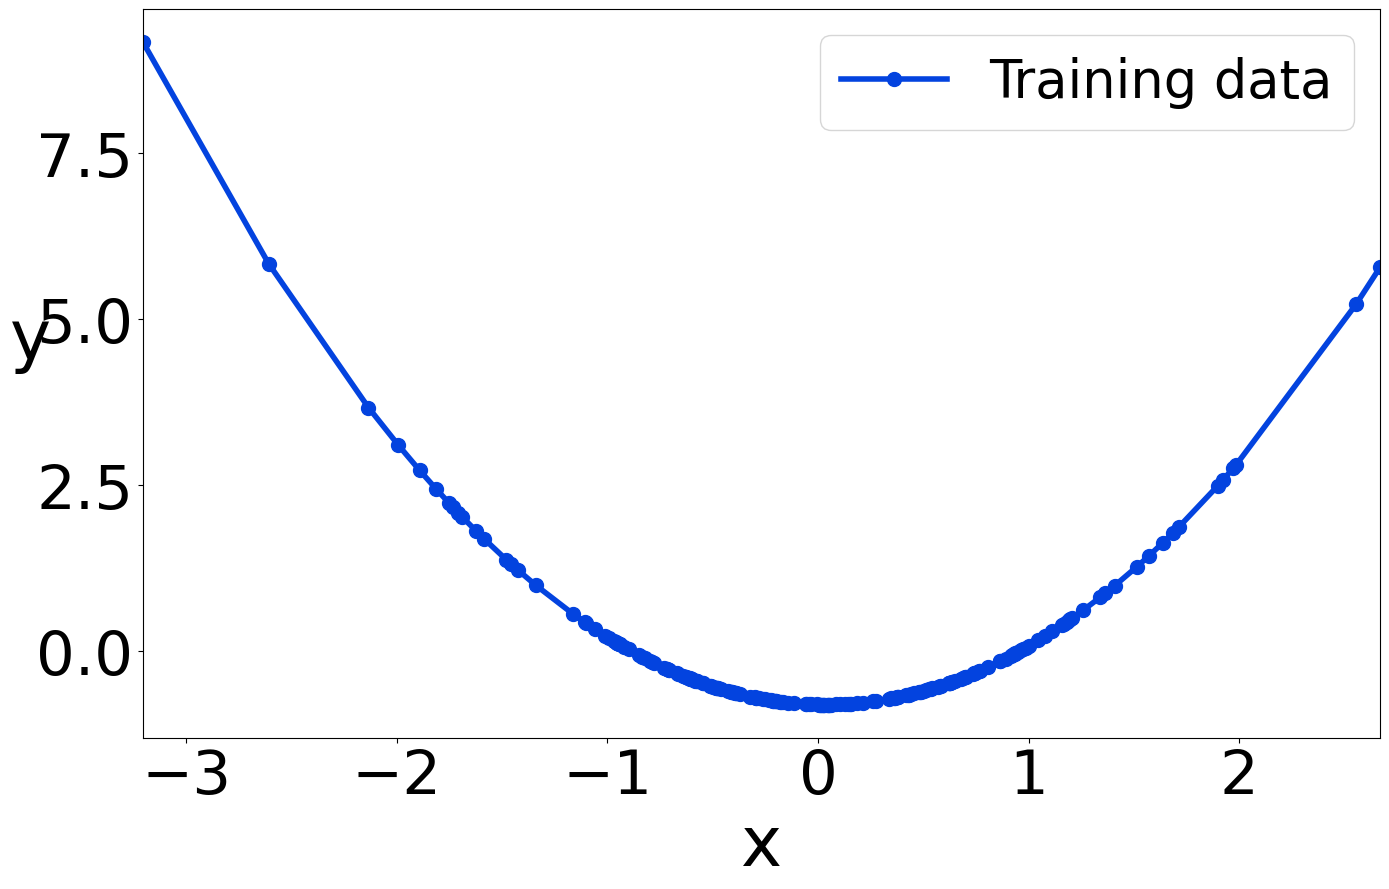

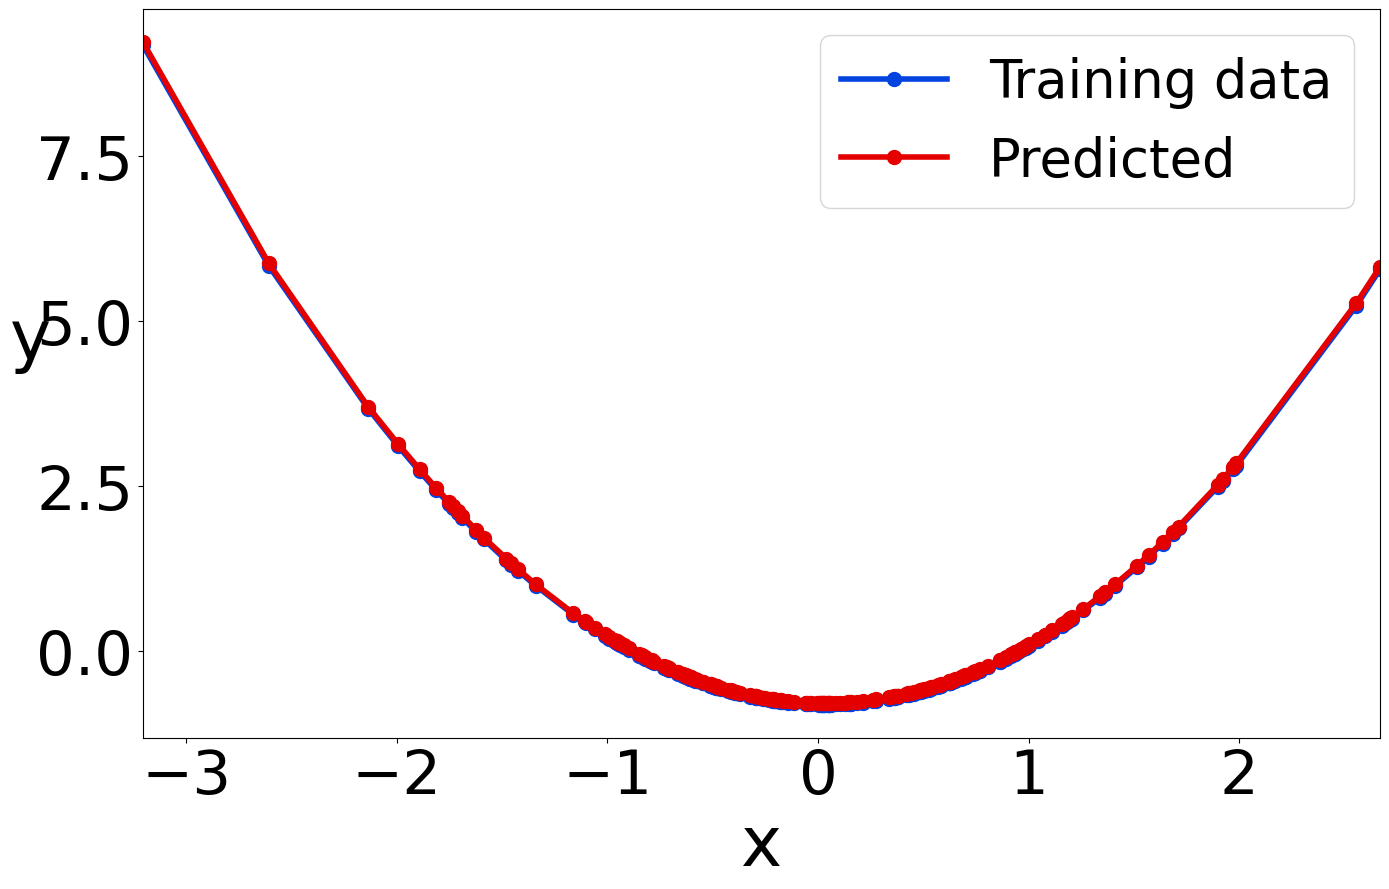

In [4]:
D1 = 800
DATA_SIZE = 200
DEGREE = 2
DISTANCE_EPOCH = 100
EPOCHS_NUM = 10000
LR = .1
RUNS_NUM = 4

#######################################################################################################
#######################################################################################################
def plot(x, y, pred_y=None):
    fig = plt.figure(figsize=(14, 9), dpi=100)
    ax = fig.add_subplot(111)
    ax.tick_params(axis='both', which='major', labelsize=44)
    ax.tick_params(axis='both', which='minor', labelsize=44)
    
    arr_ids = x.argsort(axis=0)
    sorted_x = np.take_along_axis(x, arr_ids, axis=0)
    sorted_y = np.take_along_axis(y, arr_ids, axis=0)
    plt.plot(sorted_x, sorted_y, linewidth=4, color='xkcd:blue', marker='o', markersize=10,
             label='Training data')
    
    if pred_y is not None:
        sorted_pred_y = np.take_along_axis(pred_y, arr_ids, axis=0)
        plt.plot(sorted_x, sorted_pred_y, linewidth=4, color='xkcd:red', marker='o', markersize=10,
                 label='Predicted')
        
    plt.ylabel('y', size=50, rotation=0)
    plt.xlabel('x', size=50)
    plt.xlim(xmin=min(x), xmax=max(x))

    plt.legend(loc='upper right', fontsize=38, title_fontsize=42)

    plt.tight_layout()
#     plt.savefig(f'images/gradients_during_training/fc_mnist_quartiles.png')
#######################################################################################################
#######################################################################################################

# Generate data
gen_x, gen_y = get_gaussian_data(d0=1, data_size=DATA_SIZE,
                         target_fn=PolynomialRegression(coef_lb=-1., coef_ub=1., degree=DEGREE))
plot(gen_x, gen_y)
x = torch.tensor(gen_x, dtype=torch.float)
y = torch.tensor(gen_y, dtype=torch.float)

total_loss = []
total_ranks = []
total_a_ranks = []
total_distances = []
total_ratios = []

for run_id in range(RUNS_NUM):
    print(f'=== Run {run_id + 1}/{RUNS_NUM} ===')
    model = TwoLayerNet(d0=1, d1=D1, d2=1)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#     optimizer = torch.optim.SGD(model.parameters(), lr=LR)

    loss_arr, rank_arr, ratio_arr, pattern_arr, distance_arr, a_rank_arr = train(
        model=model, 
        optimizer=optimizer, 
        loss_fn=loss_fn, 
        x=x, 
        y=y, 
        epochs_num=EPOCHS_NUM,
        distance_epoch=DISTANCE_EPOCH
    )

#     print(f'rank_arr: {rank_arr}')
#     print(f'a_rank_arr: {a_rank_arr}')
#     print(f'ratio_arr: {ratio_arr}')
    total_loss.append(loss_arr)
    total_ranks.append(rank_arr)
    total_a_ranks.append(a_rank_arr)
    total_ratios.append(ratio_arr)
    total_distances.append(distance_arr)

# Plot the trained model predictions
model.train(False)
pred_y = model(x)
plot(gen_x, gen_y, pred_y.detach().numpy())

In [ ]:
def plot_metric(x, y, y_std, ylabel, log, timestamp):
    fig = plt.figure(figsize=(16, 9), dpi=100)
    ax = fig.add_subplot(111)
    ax.tick_params(axis='both', which='major', labelsize=44)
    ax.tick_params(axis='both', which='minor', labelsize=44)
    
    if log:
        ax.set_yscale('log')
    
    plt.plot(x, y, linewidth=4, color='xkcd:blue', label=ylabel)
    plt.fill_between(x, y - y_std, y + y_std, facecolor='xkcd:blue', alpha=0.1)

    plt.xlabel('Epoch', size=50)
    plt.xlim(xmin=x[0], xmax=x[-1])
    ax.yaxis.get_offset_text().set_fontsize(30)
    if ylabel == 'Jacobian rank':
        plt.ylim(ymin=int(np.floor(np.min(y))) - 1, ymax=int(np.ceil(np.max(y))) + 1)

    if ylabel == 'Distance to the closest boundary':
        xticks = [0] + [i * 10 for i in range(1, len(x))]
        ax.set_xticks(x, xticks)
        plt.ylabel('Distance', size=50)
    else:
        plt.ylabel(ylabel, size=50)

    plt.legend(loc='upper left', fontsize=38, title_fontsize=42)
    plt.tight_layout()
    
    plt.savefig(f'images/jacobian_and_linear_regions/{timestamp}_{ylabel}.png')

def plot_histogram(x, epoch, timestamp):
    bins = 50
    
    fig = plt.figure(figsize=(16, 11), dpi=100)
    ax = fig.add_subplot(111)
    ax.tick_params(axis='both', which='major', labelsize=44)
    ax.tick_params(axis='both', which='minor', labelsize=44)
    
    plt.title(f'Epoch {epoch}', fontsize=50, pad=80)
    hist, bins = np.histogram(x, bins=bins)
    plt.suptitle(f'Smallest values: {hist[0]} values in [{round(bins[0], 7)}, {round(bins[1], 7)}]',
                 fontsize=30, y=.87, x=.55)
    
    plt.hist(x, bins=bins, facecolor='xkcd:blue', edgecolor='xkcd:powder blue', linewidth=3, alpha=0.8)
    plt.xlabel('Distance to the boundary', size=50)
    plt.ylabel('Frequency', size=50)
    plt.locator_params(axis='x', nbins=4)
    
    plt.grid()
    plt.tight_layout()
    
    plt.savefig(f'images/jacobian_and_linear_regions/{timestamp}_distance_to_boundary_epoch{epoch}.png')
    
# #######################################################################################################
# #######################################################################################################

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# ################################################
# # Generate the plots
# ################################################

loss_mean = np.mean(total_loss, axis=0)
loss_std = np.std(total_loss, axis=0)
plot_metric(x=list(range(EPOCHS_NUM + 1)), y=loss_mean, y_std=loss_std, ylabel='Loss', log=True,
           timestamp=timestamp)

# rank_mean = np.mean(total_ranks, axis=0)
# rank_std = np.std(total_ranks, axis=0)
# plot_metric(x=list(range(EPOCHS_NUM + 1)), y=rank_mean, y_std=rank_std, ylabel='Jacobian rank',
#             log=False, timestamp=timestamp)

ratio_mean = np.mean(total_ratios, axis=0)
ratio_std = np.std(total_ratios, axis=0)
plot_metric(x=list(range(EPOCHS_NUM + 1)), y=ratio_mean, y_std=ratio_std,
            ylabel='Singular values ratio', log=False, timestamp=timestamp)

a_rank_mean = np.mean(total_a_ranks, axis=0)
a_rank_std = np.std(total_a_ranks, axis=0)
plot_metric(x=list(range(EPOCHS_NUM + 1)), y=a_rank_mean, y_std=a_rank_std,
            ylabel='Rank of matrix $A$', log=False, timestamp=timestamp)

# The last pattern_arr is plotted
# tp_arr = [tuple(pattern.reshape(-1)) for pattern in pattern_arr]
# pattern_dict = {}
# for tp in tp_arr:
#     if tp not in pattern_dict:
#         pattern_dict[tp] = len(pattern_dict)

pattern_dict = {}
for pattern in pattern_arr:
    tp = tuple(pattern.reshape(-1))
    if tp not in pattern_dict:
        pattern_dict[tp] = len(pattern_dict)
# pattern_id_arr = np.asarray([pattern_dict[tp] for tp in tp_arr])
# plot_metric(x=list(range(EPOCHS_NUM + 1)), y=pattern_id_arr, y_std=np.zeros(EPOCHS_NUM + 1),
#             ylabel='Activation pattern id', log=False, timestamp=timestamp)

# # Distance to the boundary
# for e_id, da in enumerate(distance_arr):
#     plot_histogram(x=da, epoch=e_id * DISTANCE_EPOCH, timestamp=timestamp)
    
# ################################################
# # Store data for the later reference
# ################################################
# np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_loss.txt', total_loss)
# # np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_rank.txt', total_ranks)
# np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_ratio.txt', total_ratios)
# np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_a_rank.txt', a_rank_arr)
# np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_pattern_id.txt', pattern_id_arr)
# np.savetxt(f'data/jacobian_and_linear_regions/{timestamp}_distance_to_boundary.txt', distance_arr)